# 5.6 Catastrophe Analysis

## 5.6.1 El origen del problema

El datawarehouse reside en una base de datos Oracle, donde gran cantidad de campos están definidos como NOT NULL y con initial value = 0  
<br>Cada mes se crea una partición la que es inicializada automáticamente
<br>Cada mes corren decenas de procesos que populan campos específicos de la partición yendo a buscar los datos a los sistemas transacciones
<br>Si esos scripts no son corridos, y fallan,  los campos que debían modificar quedan en su initial value = 0

En el mes de 2020-06 ocurrio una gran falla en la construcción del dataset y decenas de campos no se calcularon quedando en el DataWarehouse el valor por default de cero para TODOS los registros de esos campos.

#### 5.6.2  Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab
*   Bajar el **dataset_historico** al Google Drive y tambien al disco local de la virtual machine que esta corriendo Google Colab



*  Si usted eligió modalidad *Gerencial* entonces NO debe modificar nada, su liderazgo logró que merecidamente otras personas trabajaron por usted
*  Si usted eligió modalidad de *Analista Junior*, entonces donde dice archivo="gerencial_competencia_2025.csv.gz"  lo debe cambiar por  archivo="analistajr_competencia_2025.csv.gz"
*  Si usted eligió modalidad *Analista Senior*,  ya se las ingenierá SIN preguntar !

In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/dm"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dm" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/itba2025-8d0a/gerencial_competencia_2025.csv.gz"
archivo_destino="/content/datasets/gerencial_competencia_2025.csv.gz"
archivo_destino_bucket="/content/buckets/b1/datasets/gerencial_competencia_2025.csv.gz"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


--2025-08-02 00:14:54--  https://storage.googleapis.com/open-courses/itba2025-8d0a/gerencial_competencia_2025.csv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16778888 (16M) [application/x-gzip]
Saving to: ‘/content/buckets/b1/datasets/gerencial_competencia_2025.csv.gz’

/content/buckets/b1 100%[===================>]  16.00M  46.3MB/s    in 0.3s    

2025-08-02 00:14:55 (46.3 MB/s) - ‘/content/buckets/b1/datasets/gerencial_competencia_2025.csv.gz’ saved [16778888/16778888]



### 5.6.3  Analisis de los daños al dataset

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

used    (Mb) gc trigger (Mb) max used (Mb)
Ncells  656417 35.1 1454465    77.7 1321192  70.6
Vcells 1219191  9.4 8388608    64.0 1975128  15.1

In [2]:
# cargo las librerias que necesito
require("data.table")

if( !require("R.utils")) install.packages("R.utils")
require("R.utils")

Loading required package: data.table

Loading required package: R.utils

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘R.utils’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.




Si es gerente, no cambie nada
<br>Si es Analista, cambie el nombre del dataset

In [3]:
PARAM <- list()
PARAM$experimento <- 6300
PARAM$dataset <- "gerencial_competencia_2025.csv.gz"

In [4]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("CA", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [5]:
# lectura del dataset
dataset <- fread(paste0("/content/datasets/", PARAM$dataset))

In [6]:
# ordeno el dataset
setorder(dataset, foto_mes, numero_de_cliente)

In [7]:
# los campos que se van a utilizar
campos_buenos <- setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
)

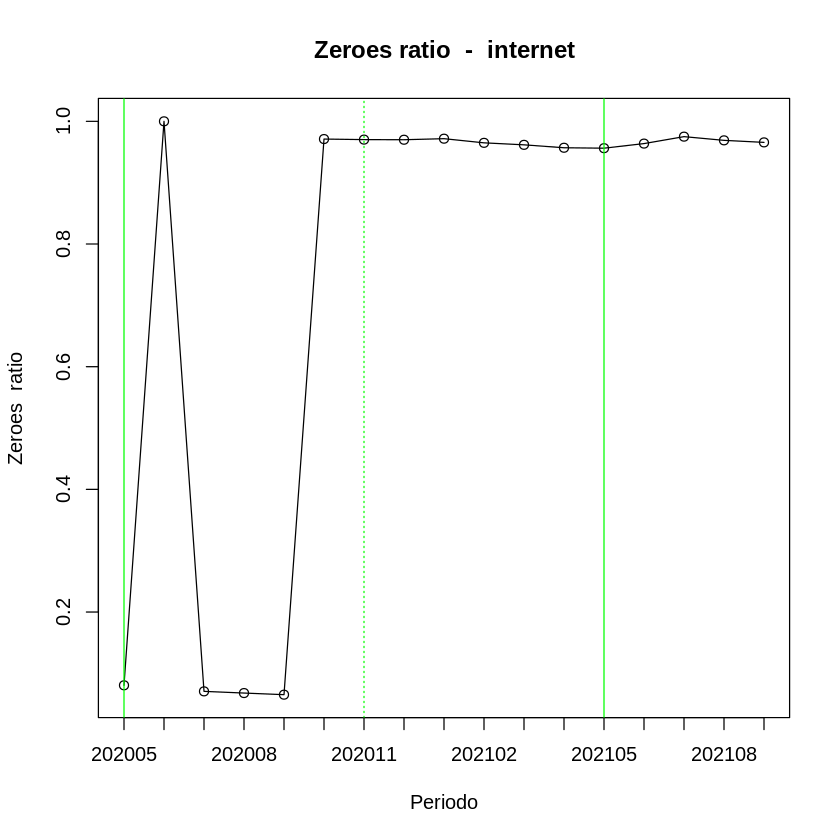

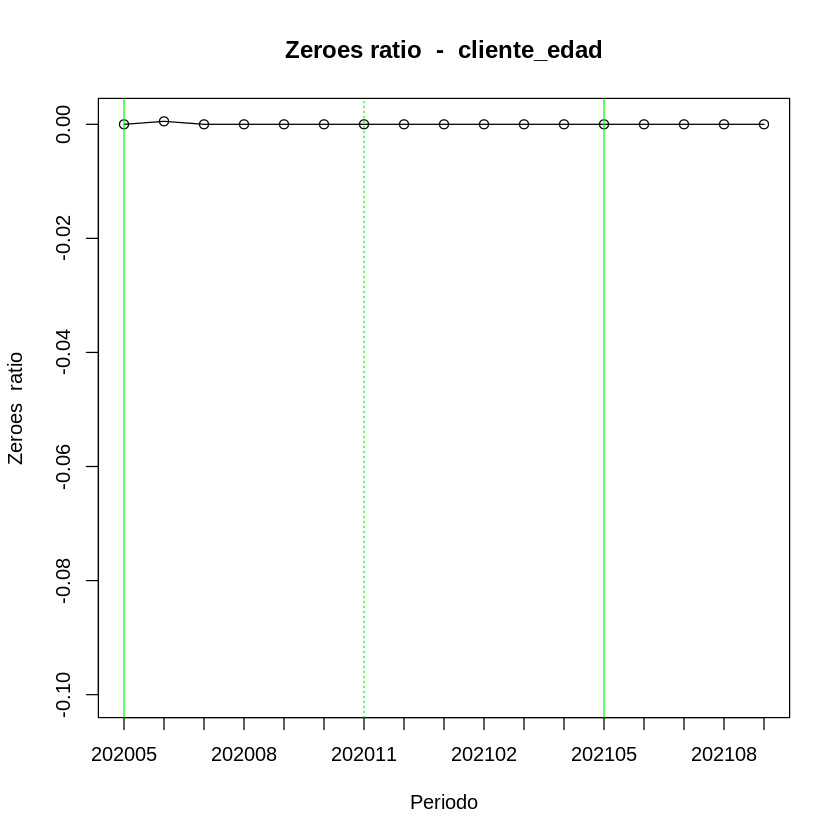

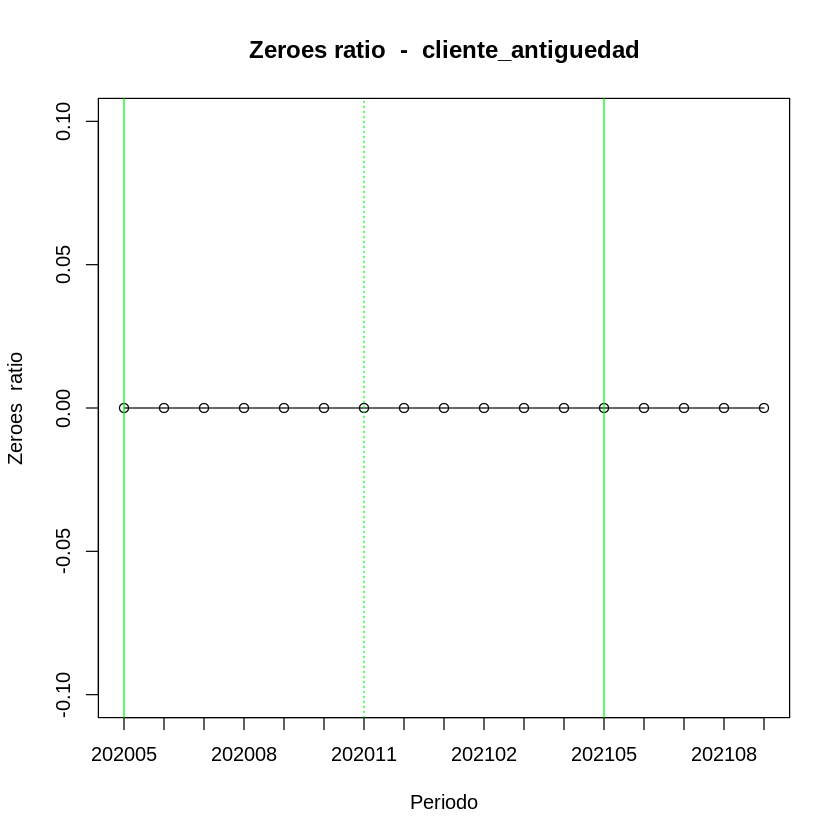

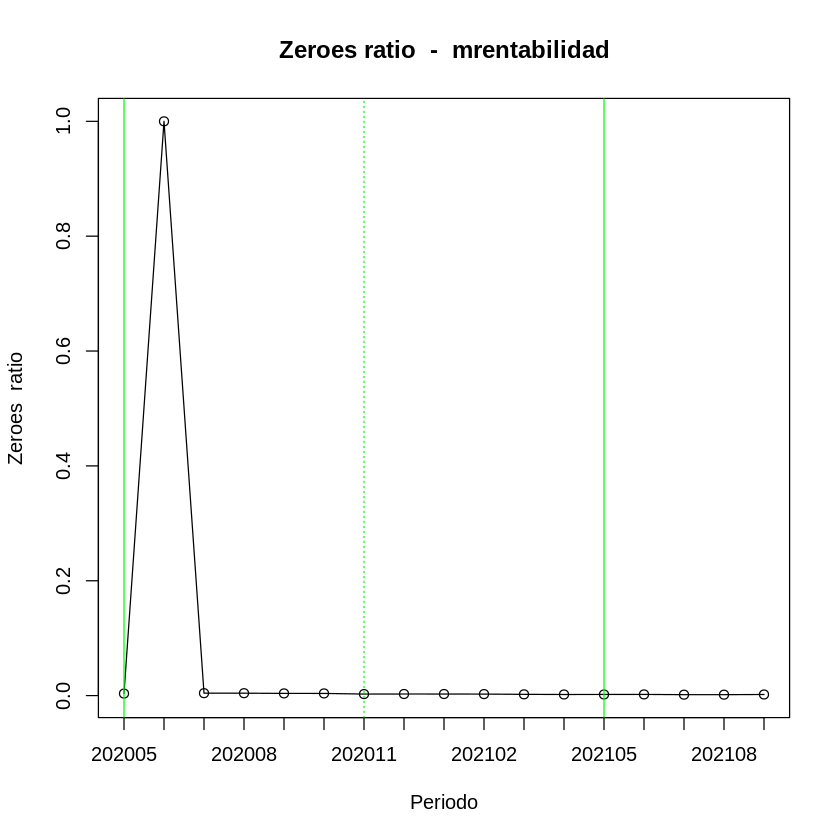

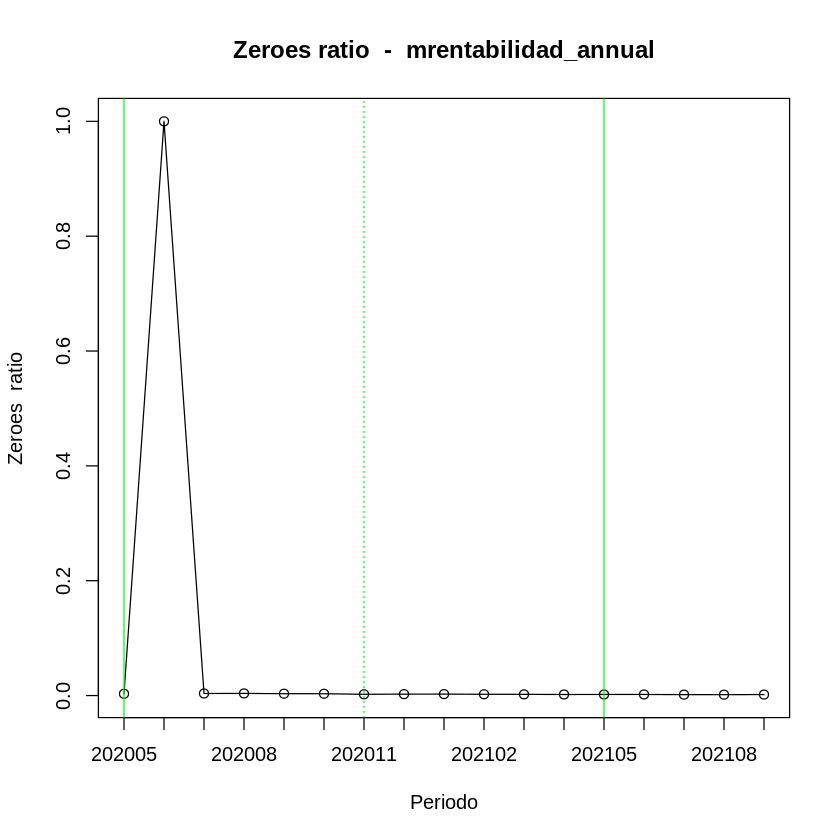

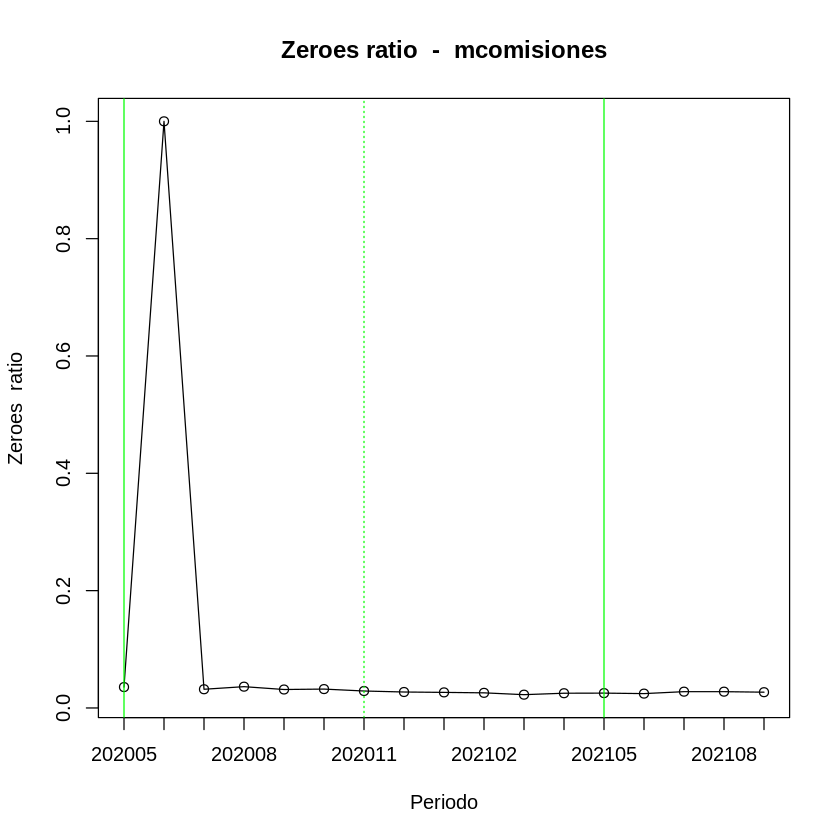

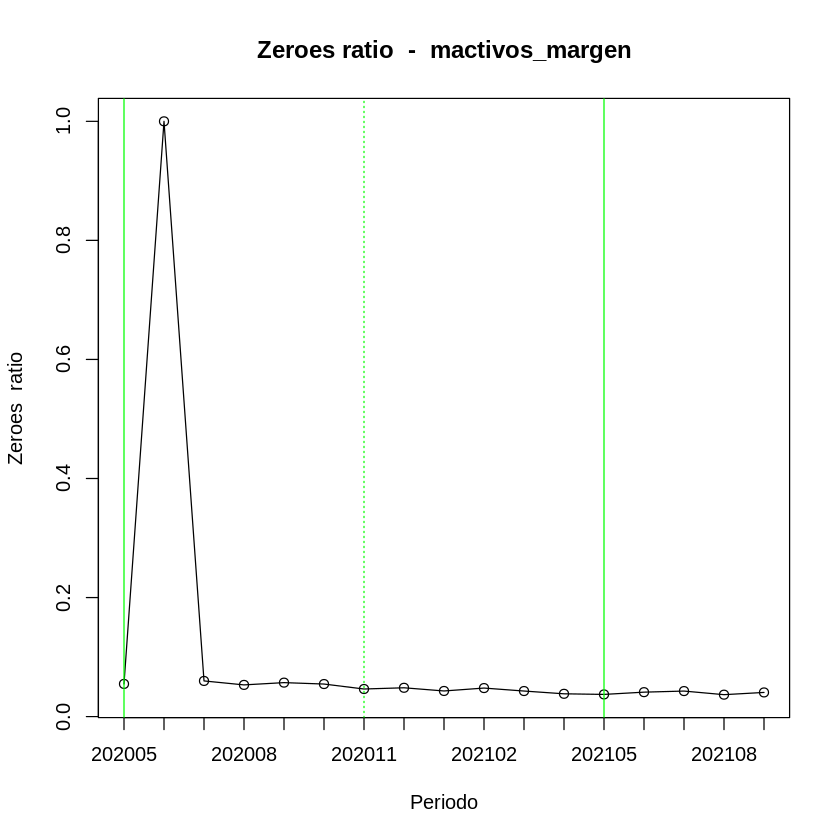

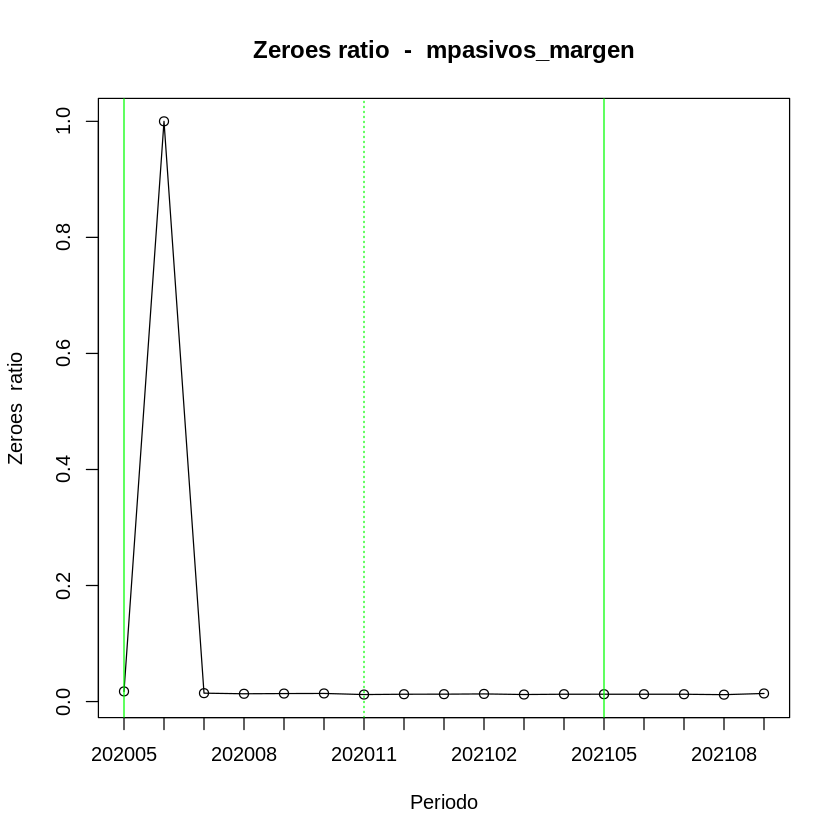

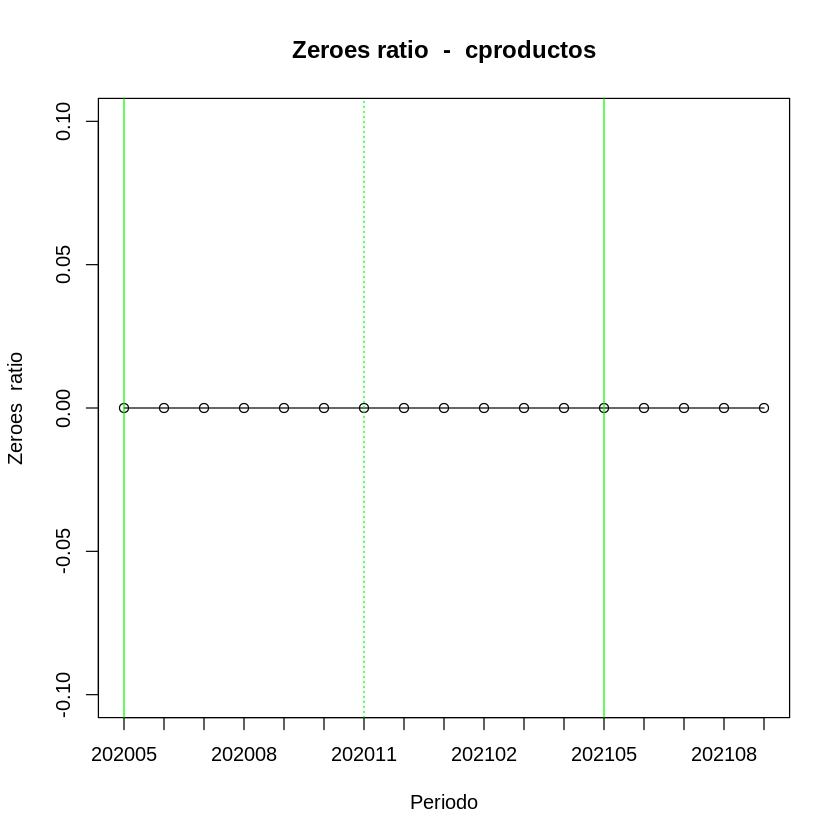

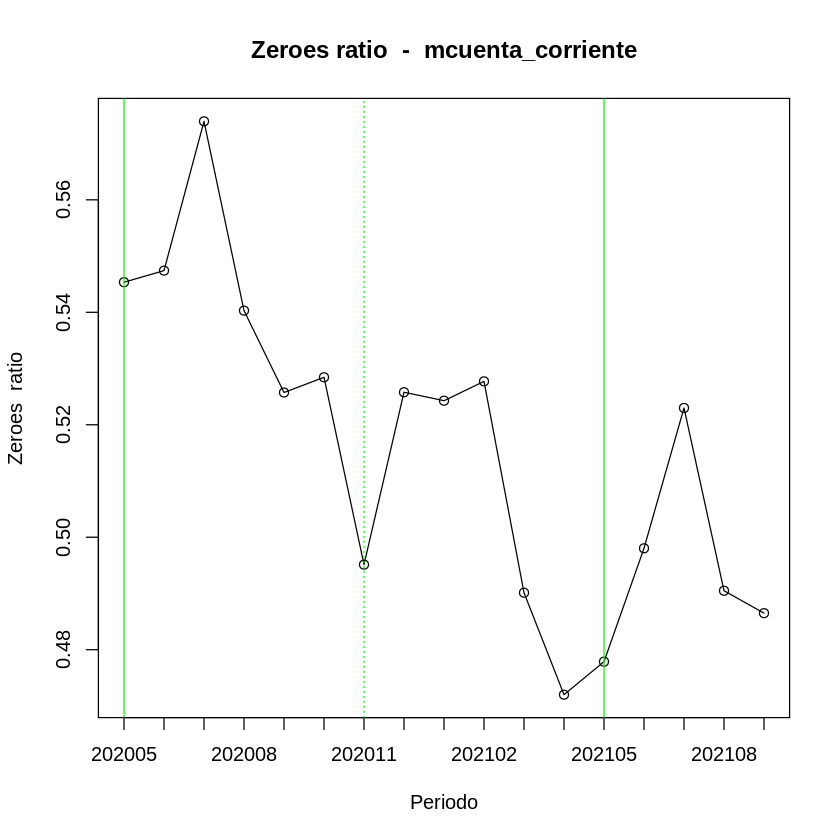

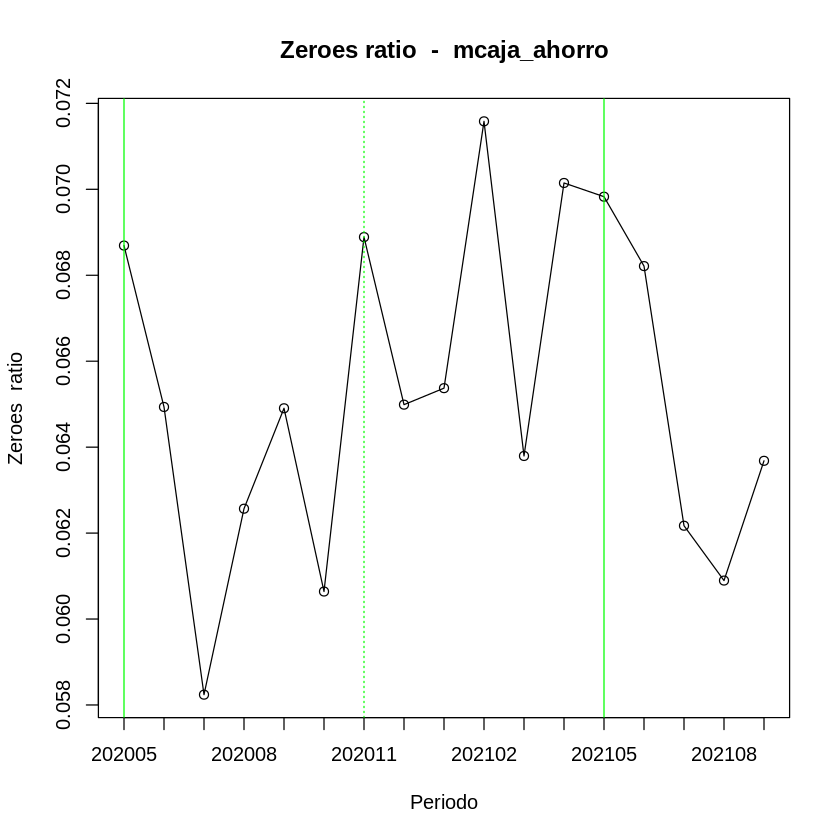

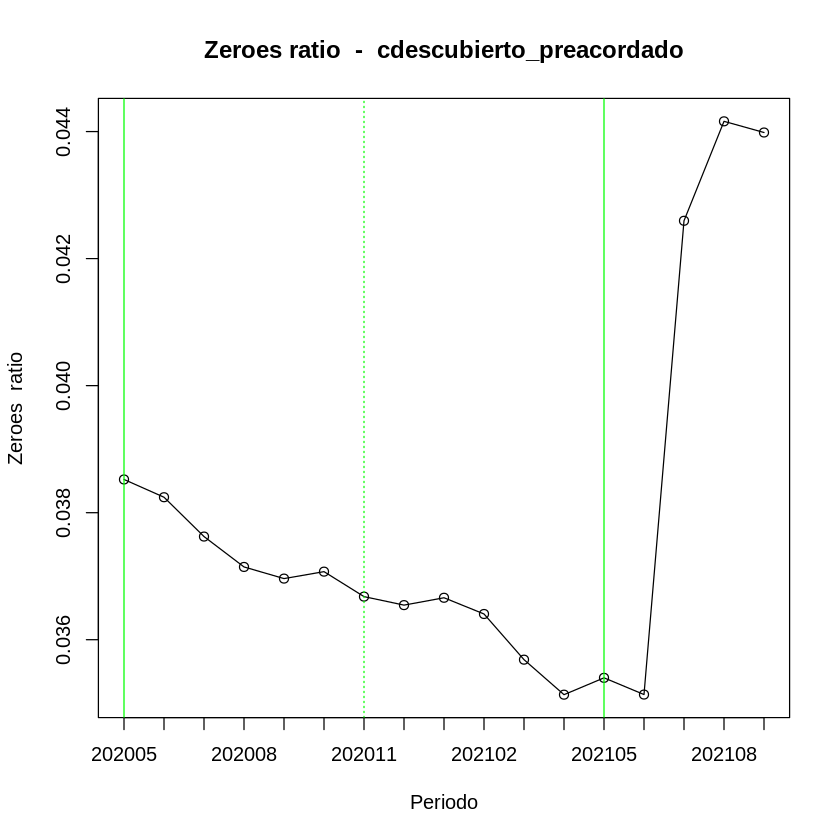

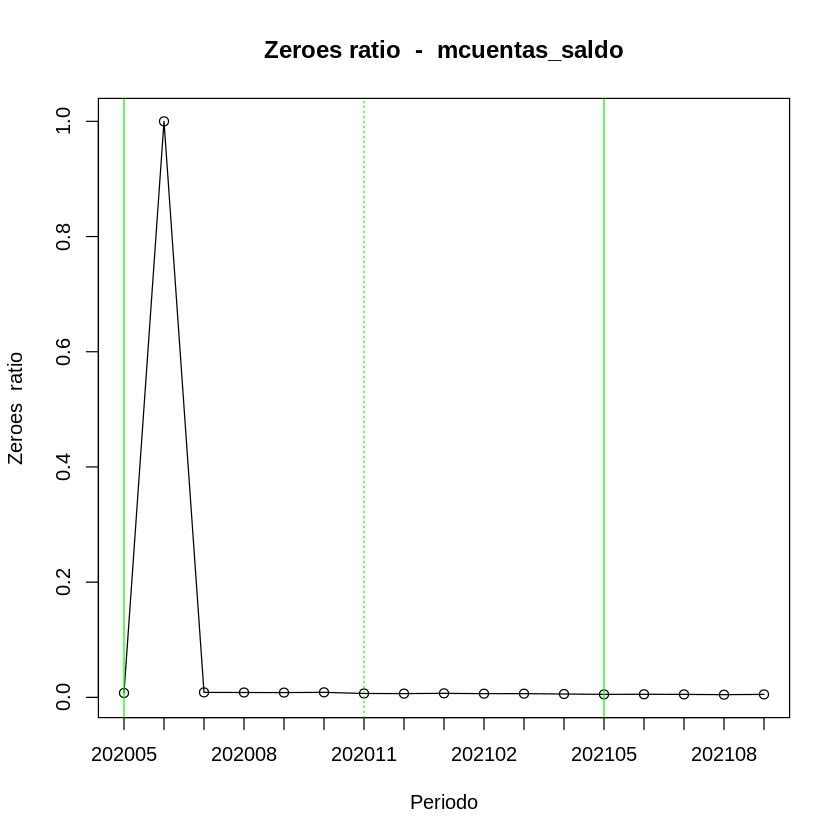

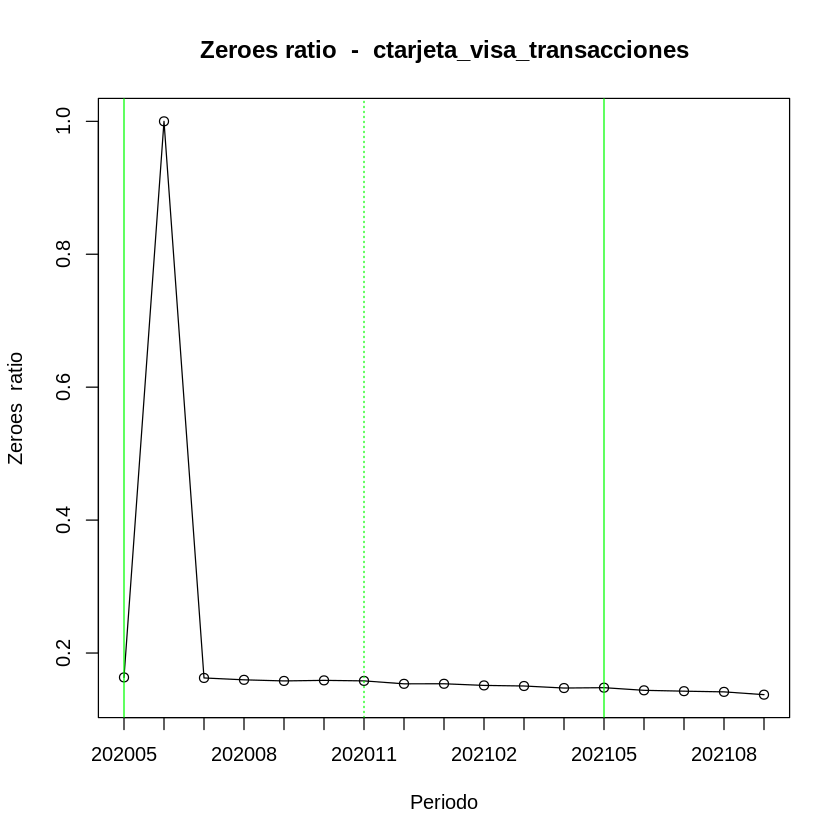

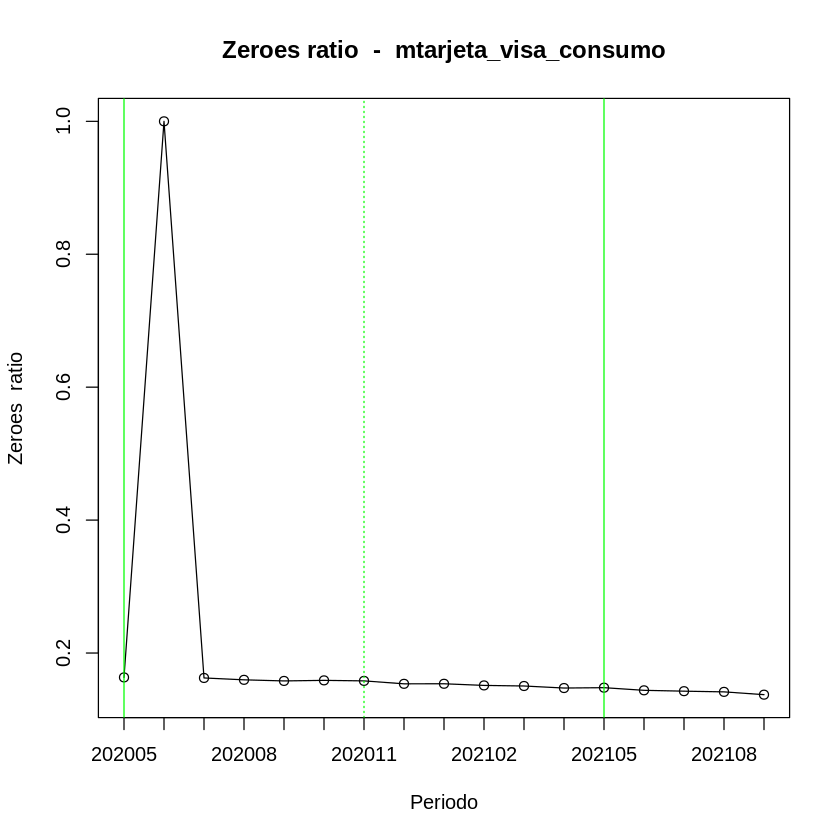

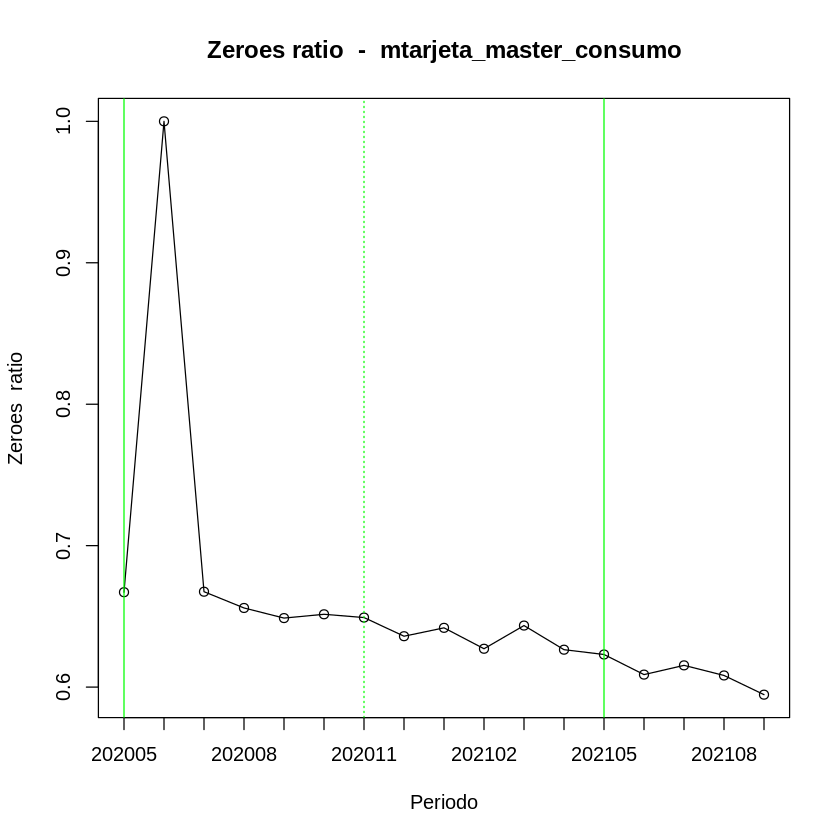

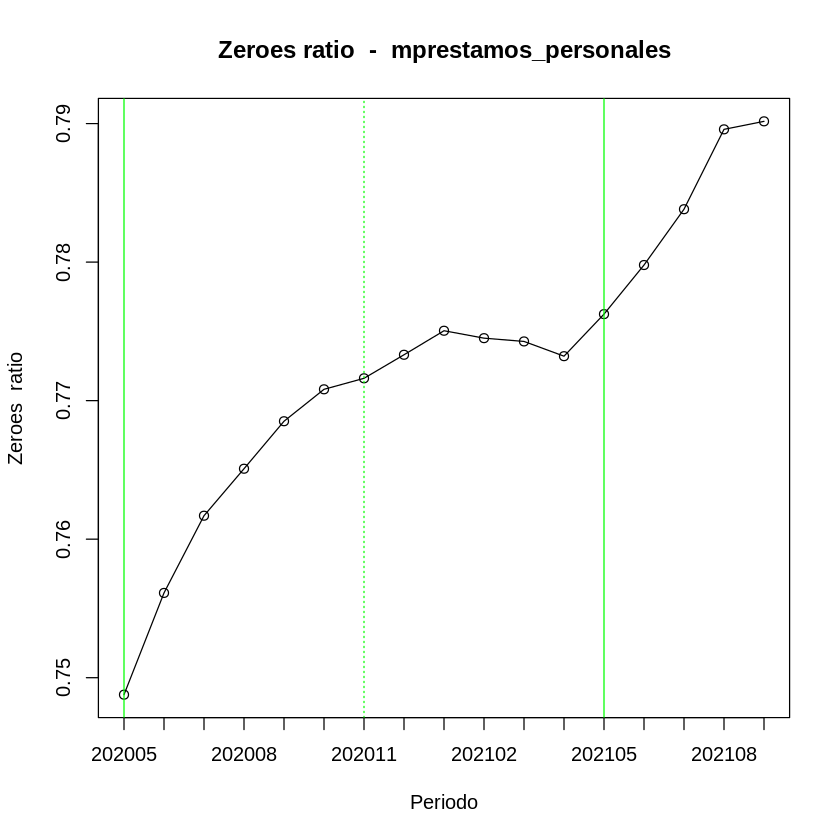

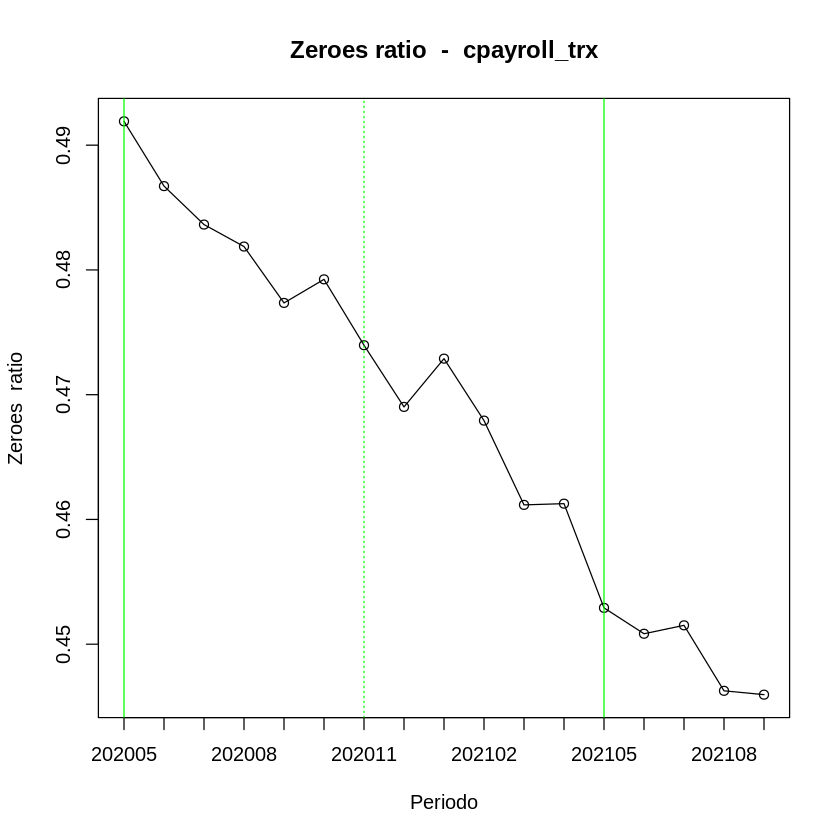

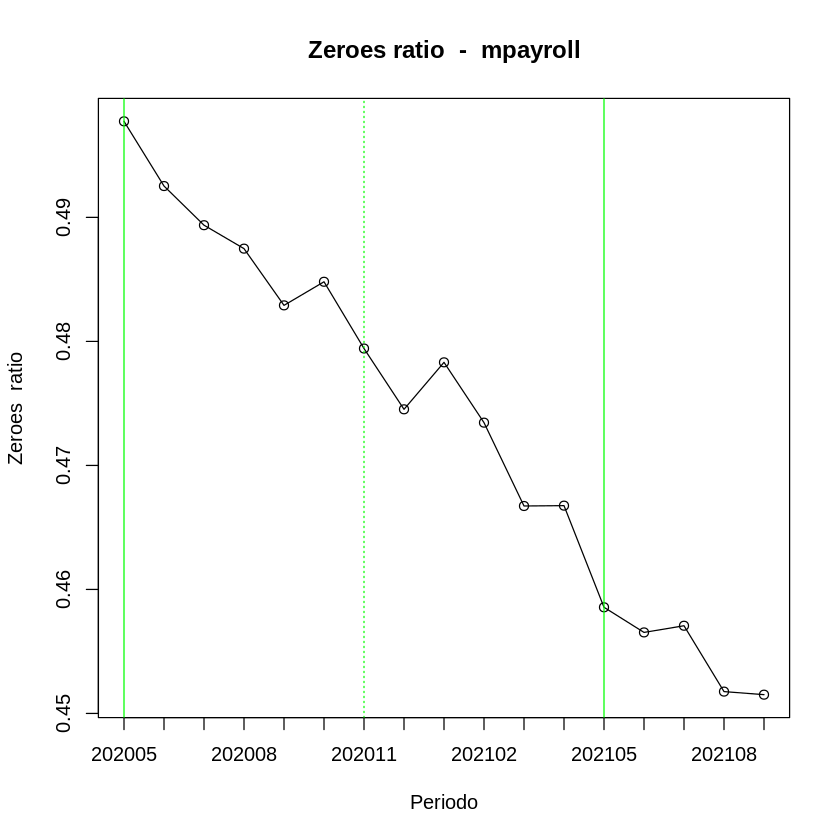

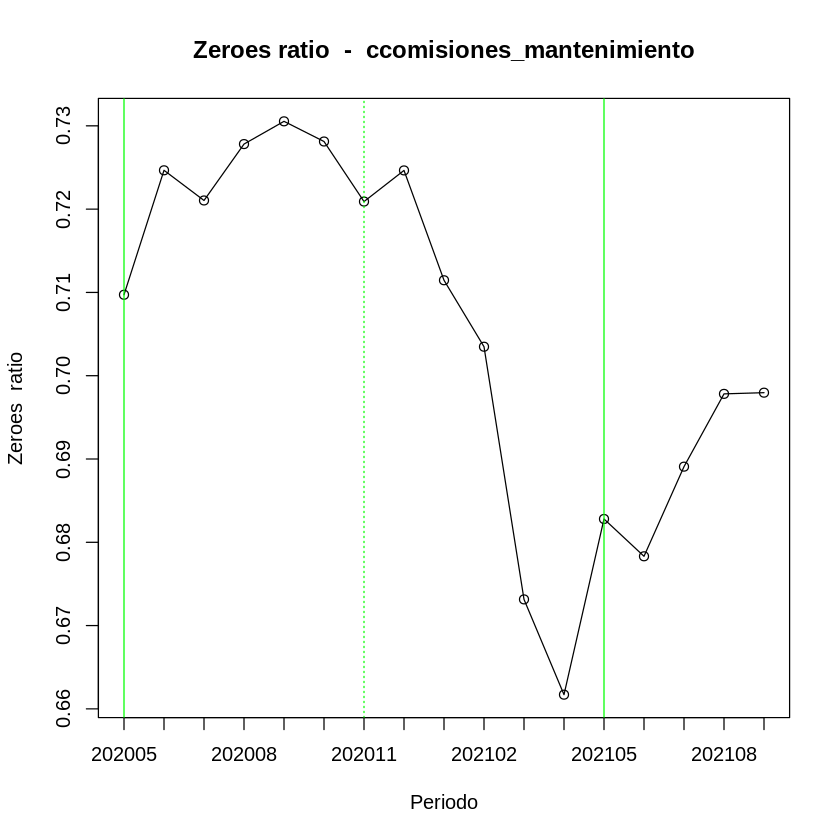

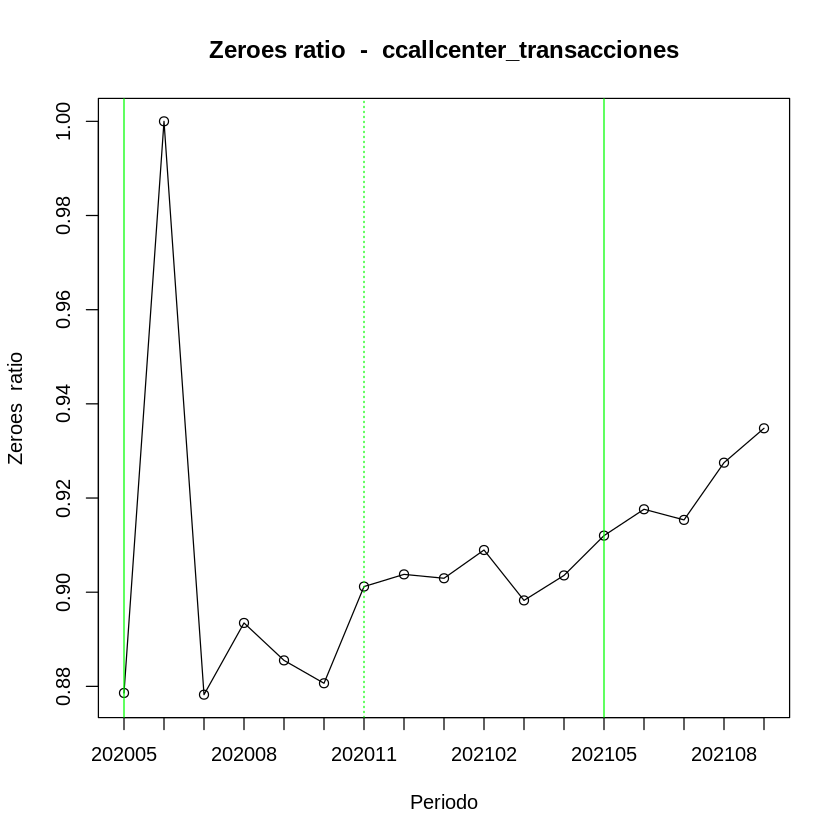

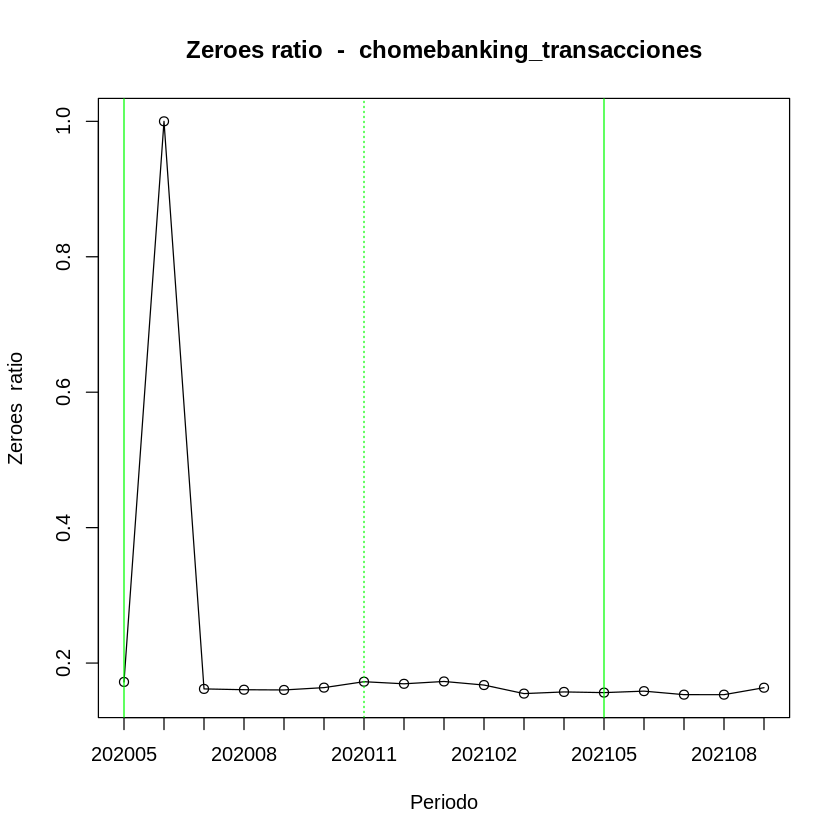

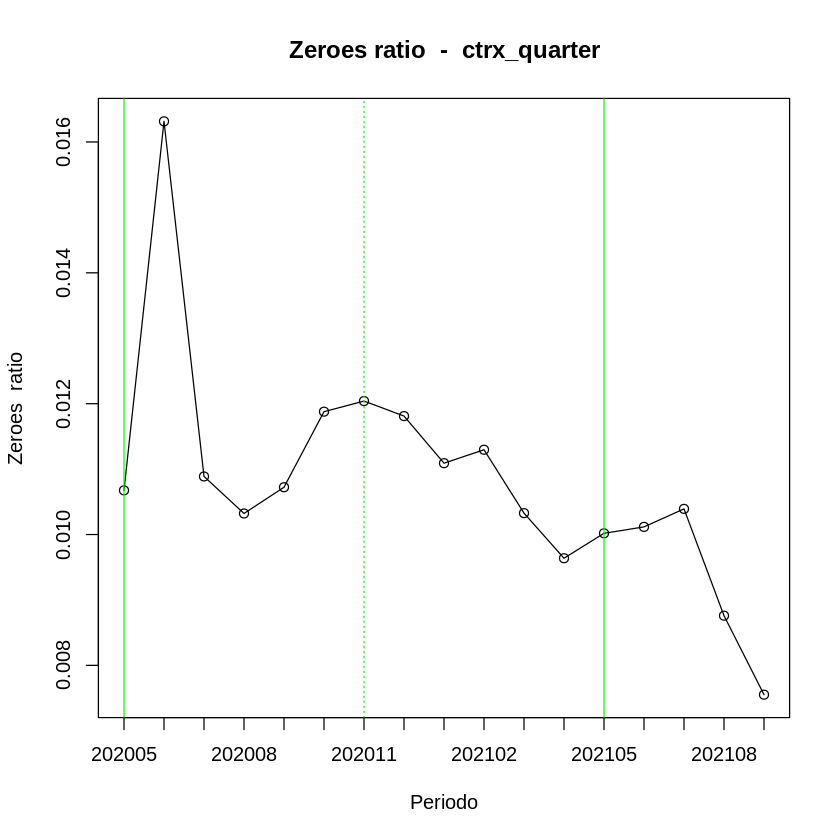

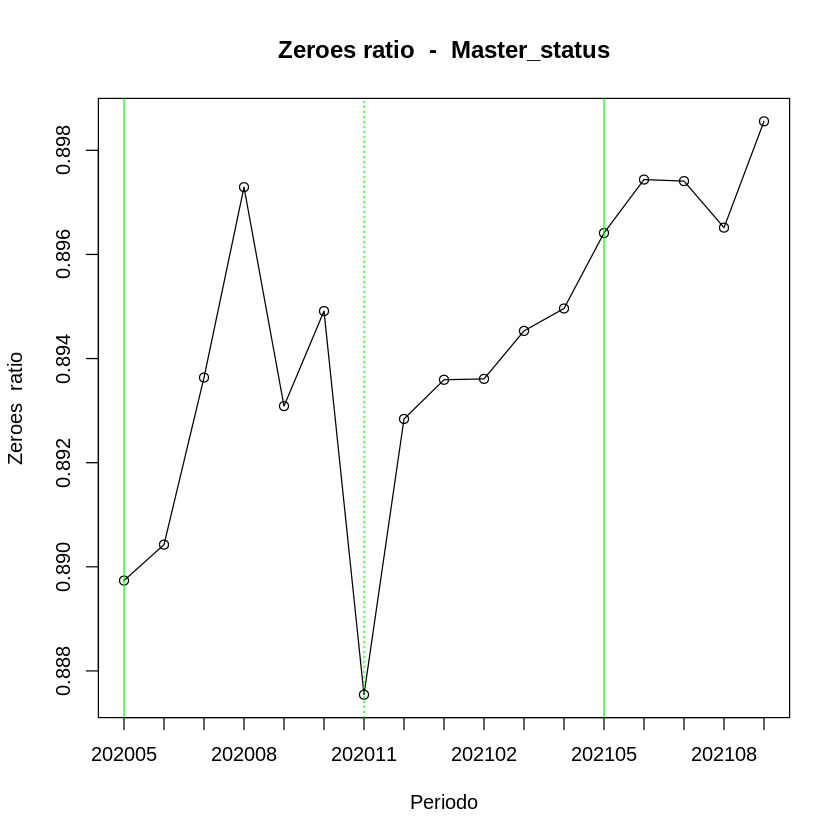

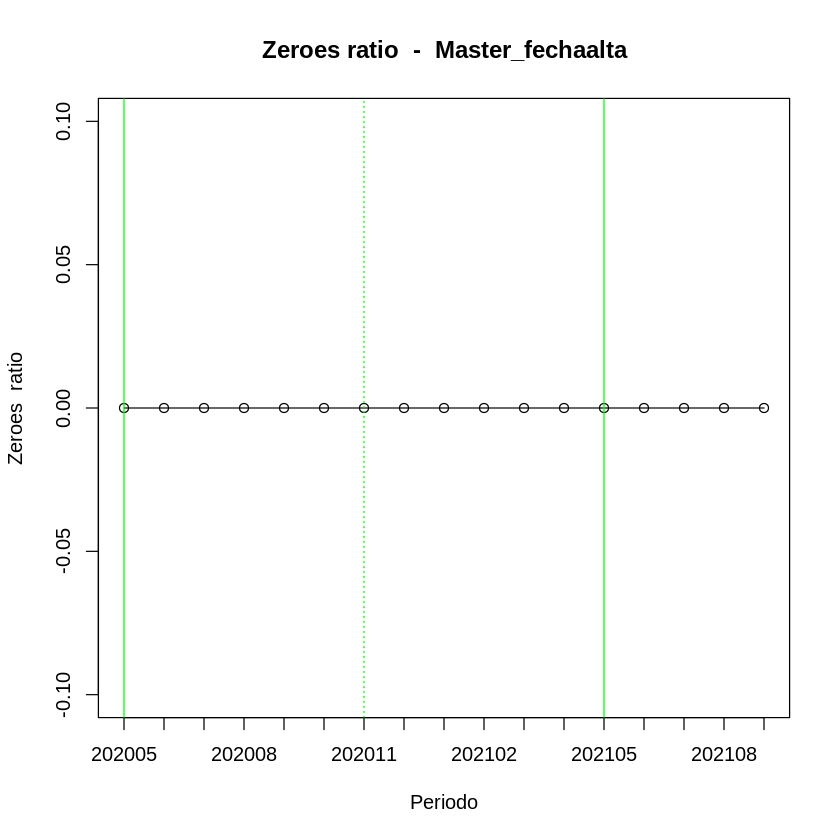

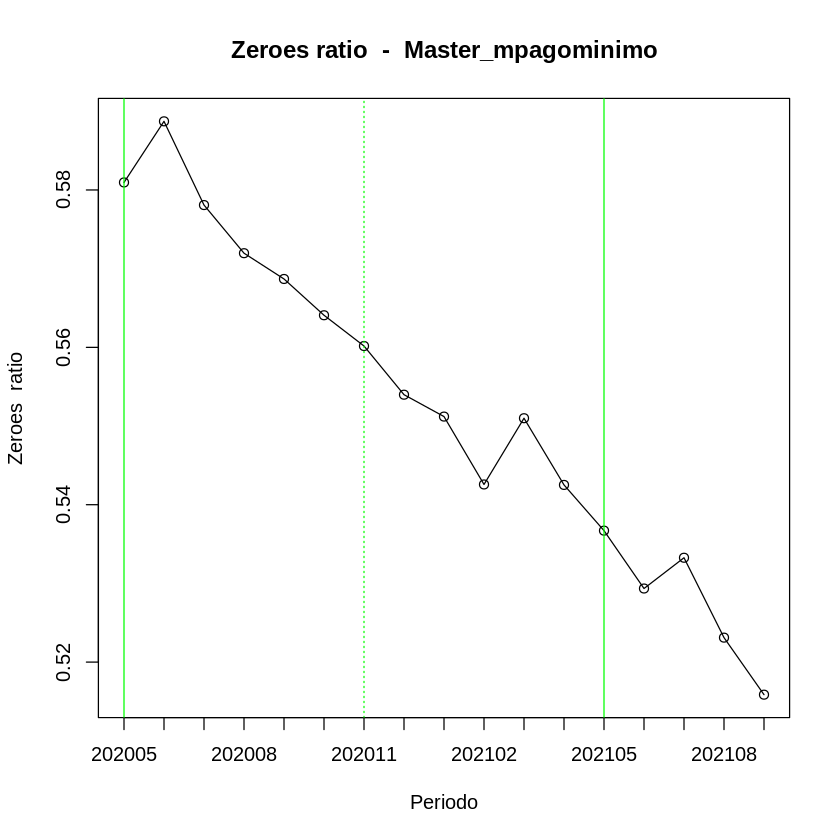

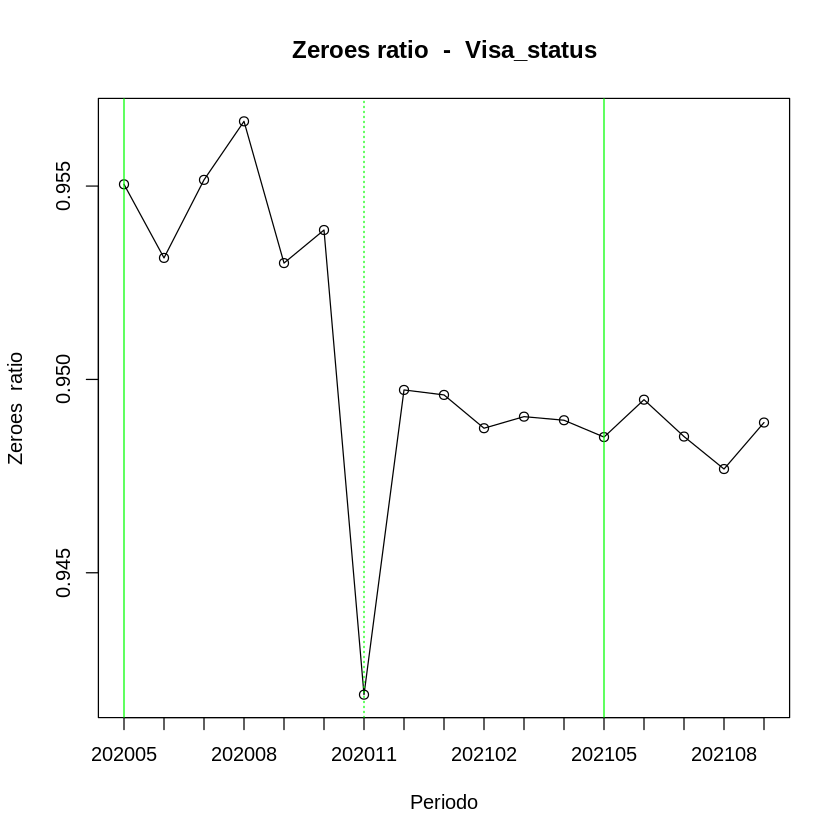

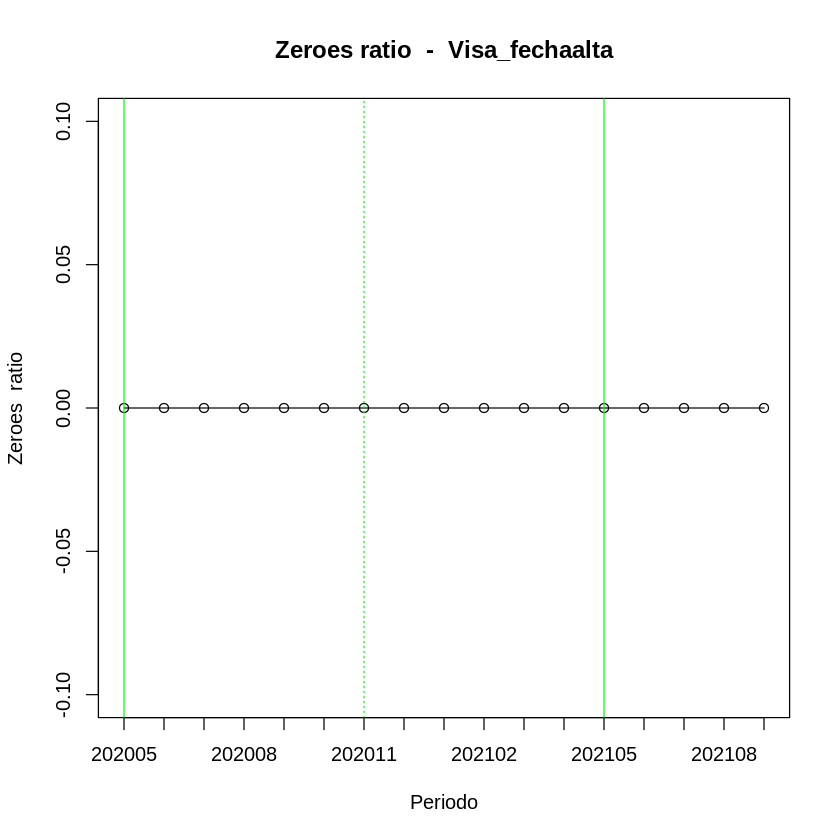

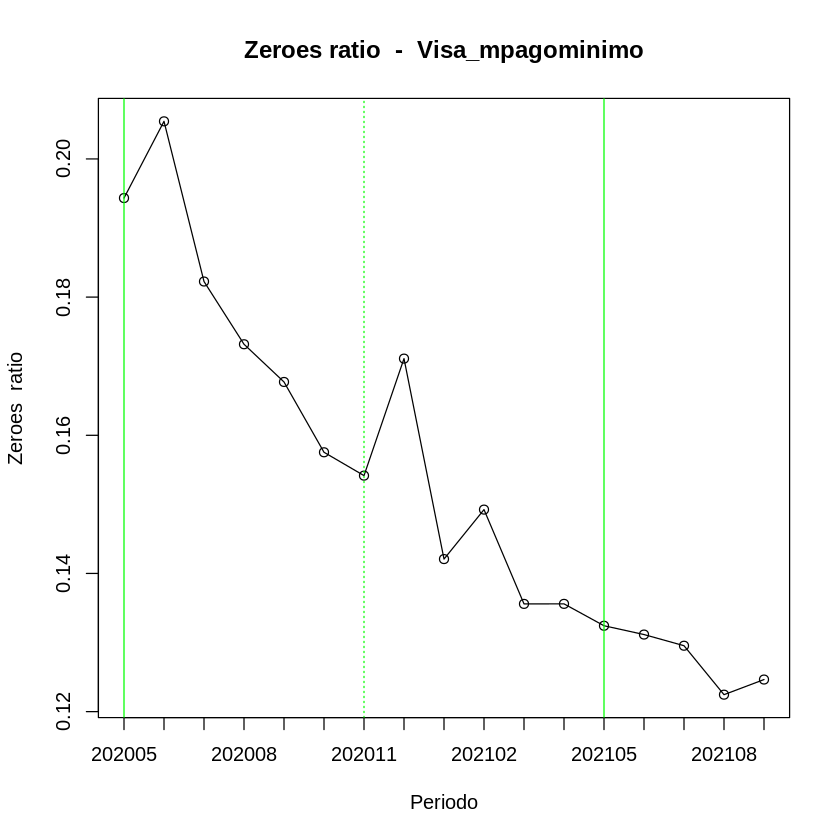

In [8]:
# Para cada variable ,
# grafico para cada mes el ratio de ceros que tiene esa variable
# el zeroes_ratio de una variable para un mes dado
# es el cociente entre
#   la cantidad de veces que la variable toma el valor cero ese mes
#   y la cantidad total de registros para ese mes

# pdf("zeroes_ratio.pdf")

for (campo in campos_buenos) {
  tbl <- dataset[
    ,
    list("zero_ratio" = sum(get(campo) == 0, na.rm = TRUE) / .N),
    foto_mes
  ]

  ymin <- min(tbl$zero_ratio)
  ymax <- max(tbl$zero_ratio)
  if (ymin == 0) ymin <- -0.1
  if (ymax == 0) ymax <- 0.1

  plot(
    x = 1:nrow(tbl),
    y = tbl$zero_ratio,
    type = "o",
    main = paste0("Zeroes ratio  -  ", campo),
    xlab = "Periodo",
    ylab = "Zeroes  ratio",
    ylim = c(ymin, ymax),
    xaxt = "n"
  )

  axis(1, at = 1:nrow(tbl), labels = tbl$foto_mes)

  abline(
    v = c(1, 13, 25),
    col = c("green", "green", "green"),
    lty = c(1, 1, 1),
    lwd = c(1, 1, 1)
  )

  abline(
    v = c(7, 19, 31),
    col = c("green", "green", "green"),
    lty = c(3, 3, 3),
    lwd = c(1, 1, 1)
  )
}

# dev.off()


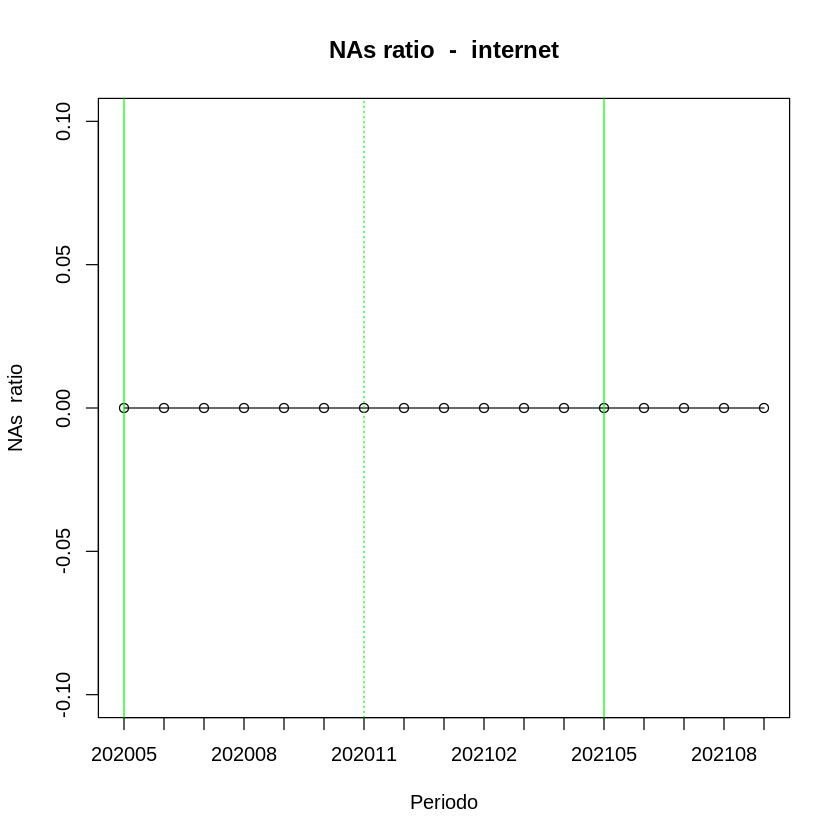

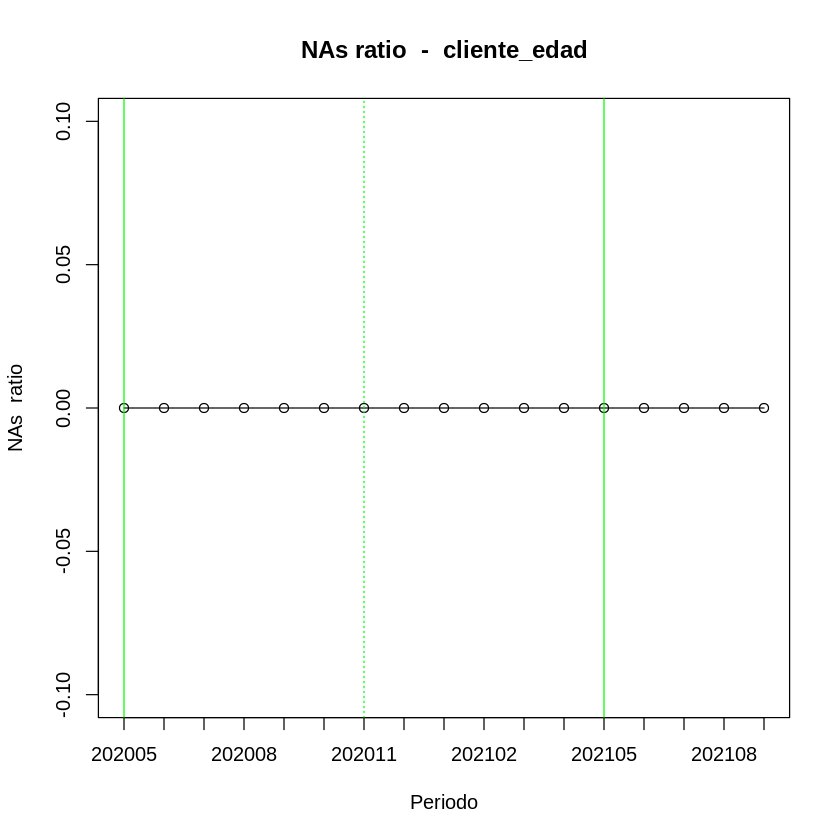

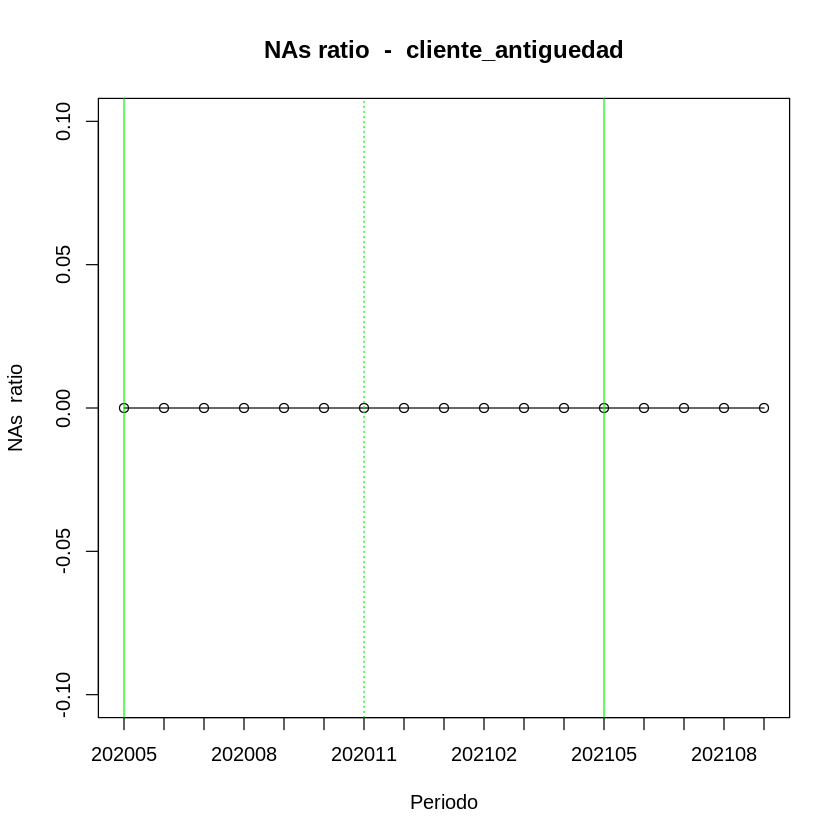

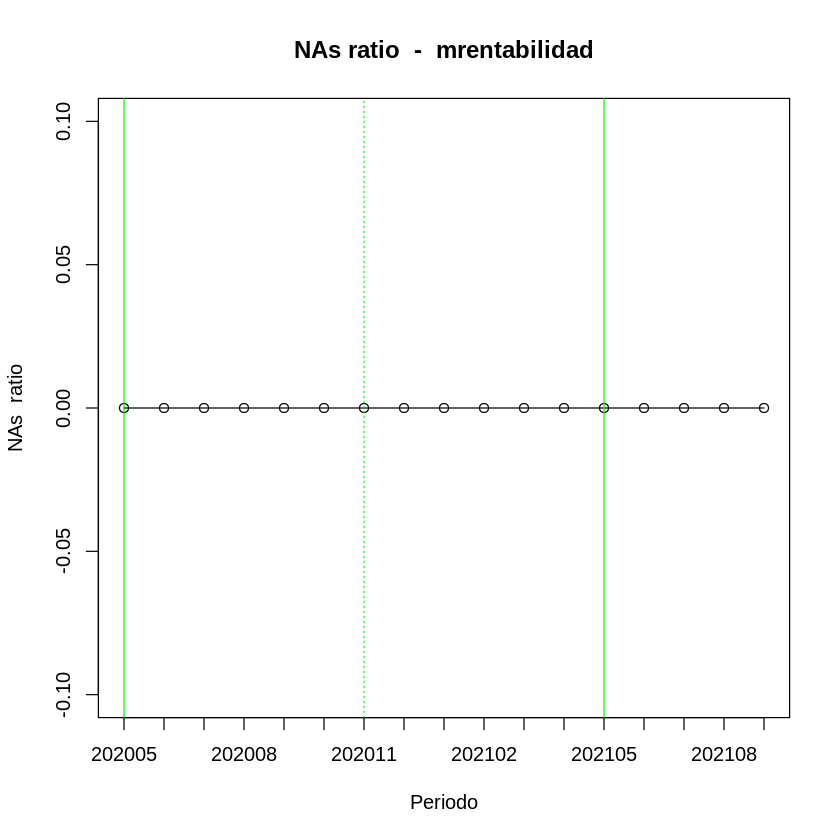

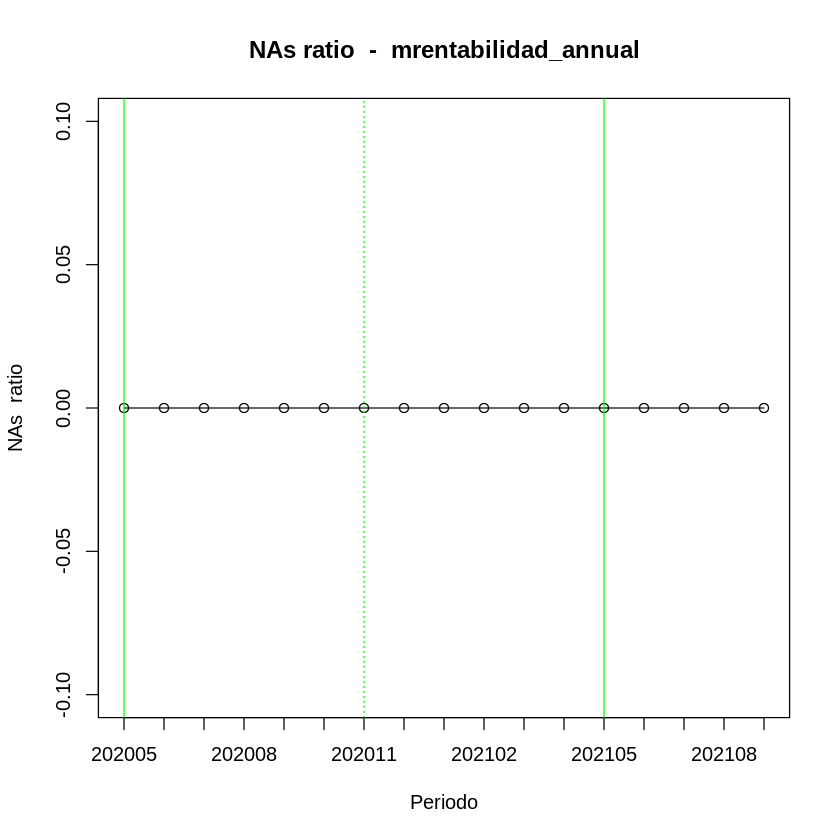

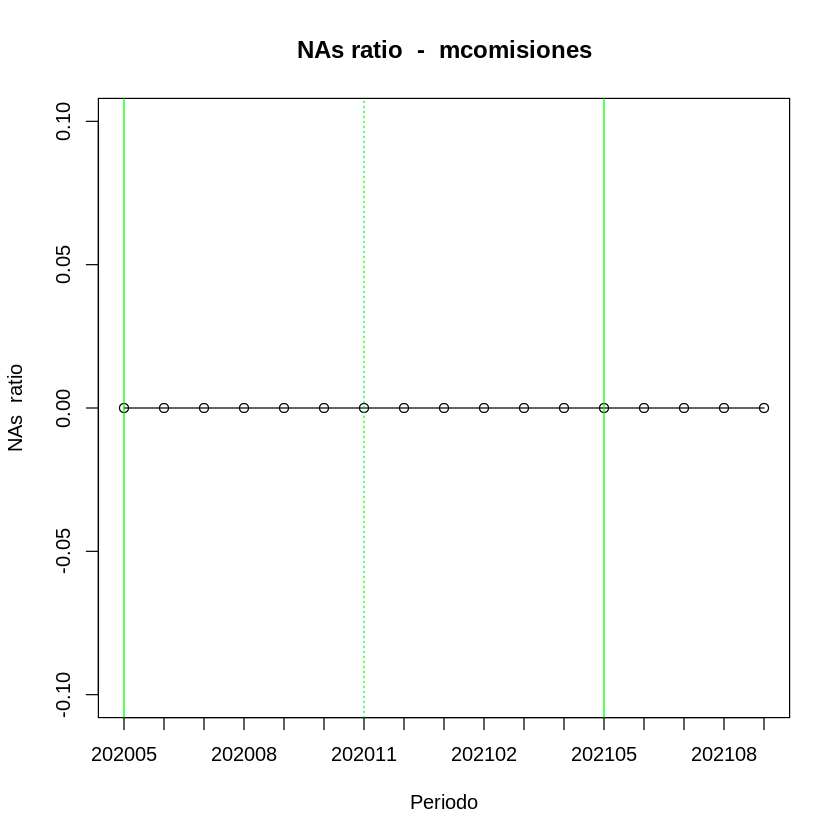

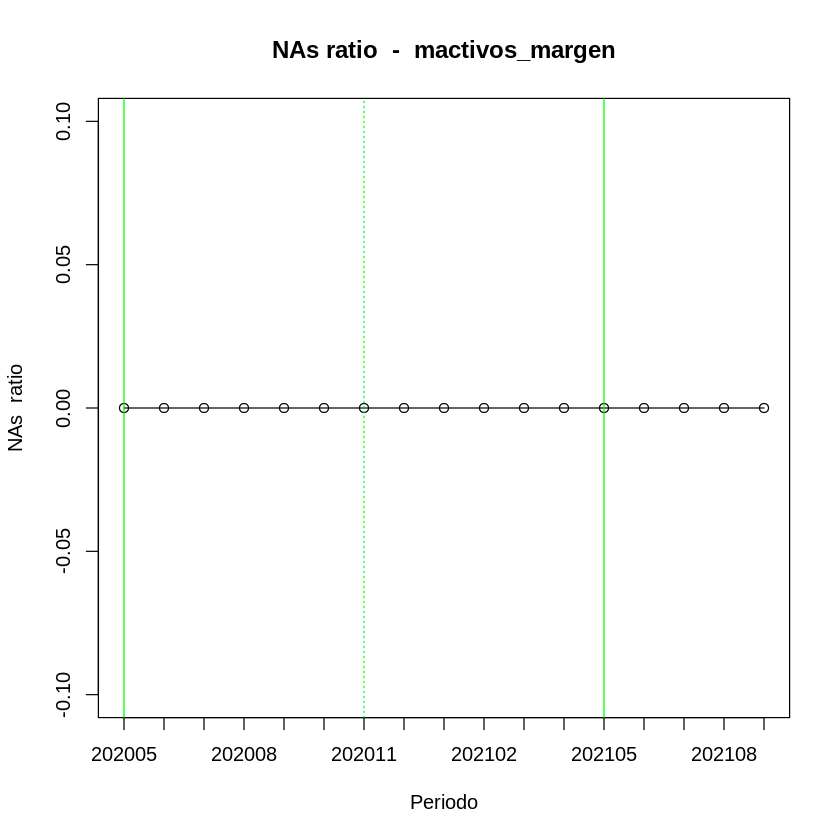

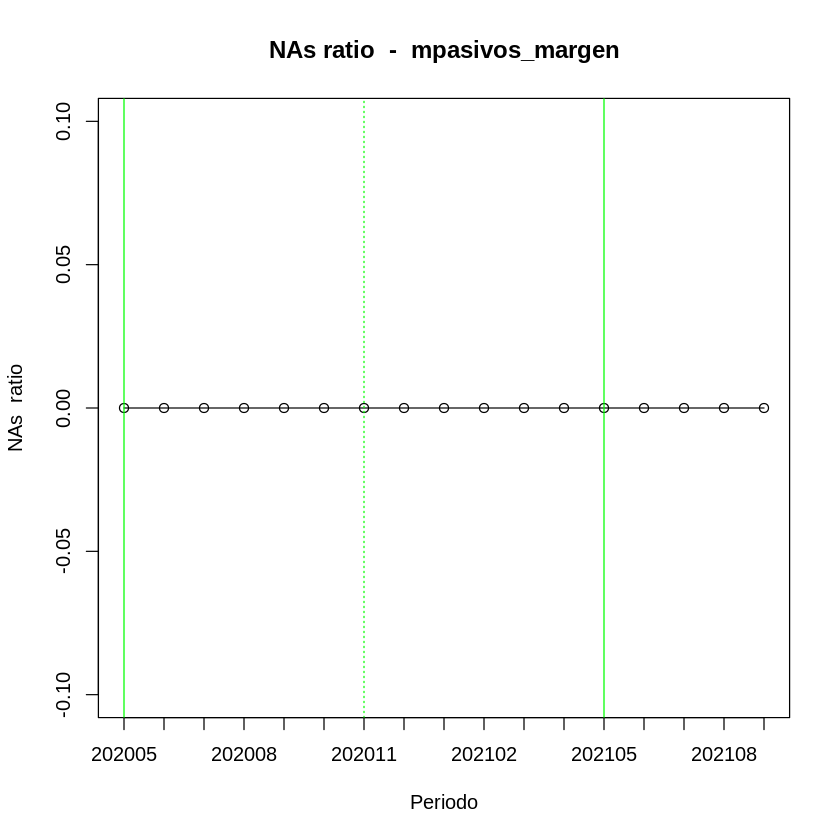

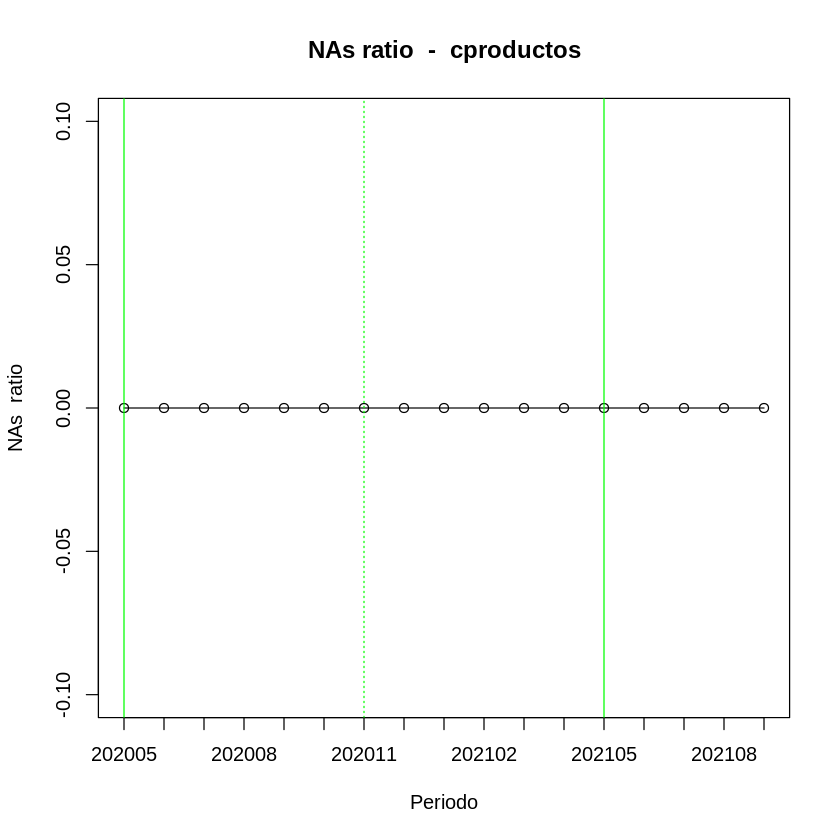

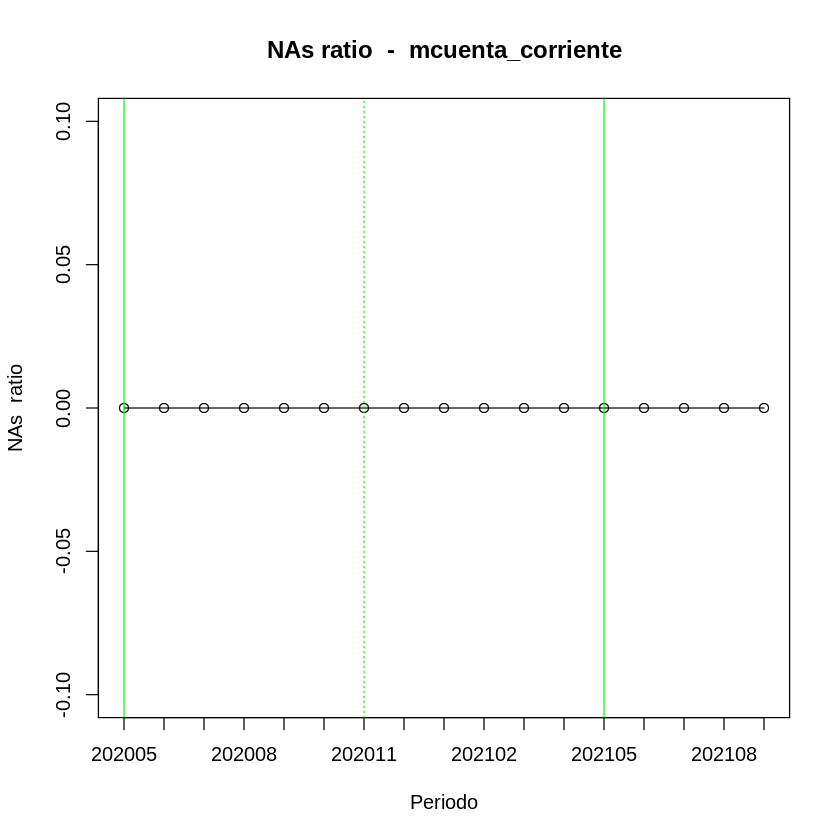

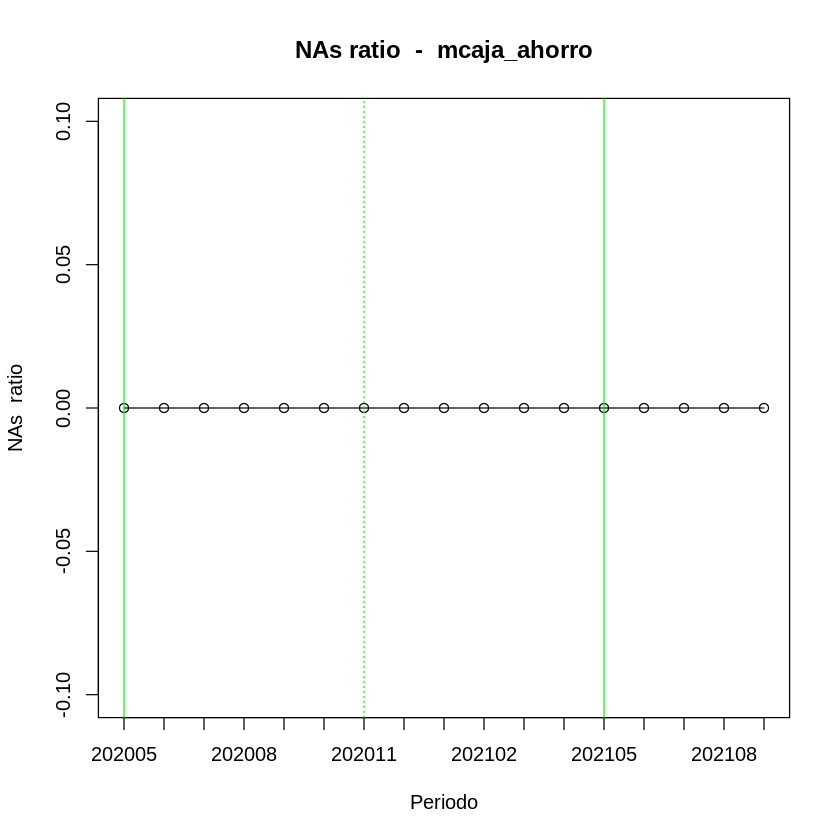

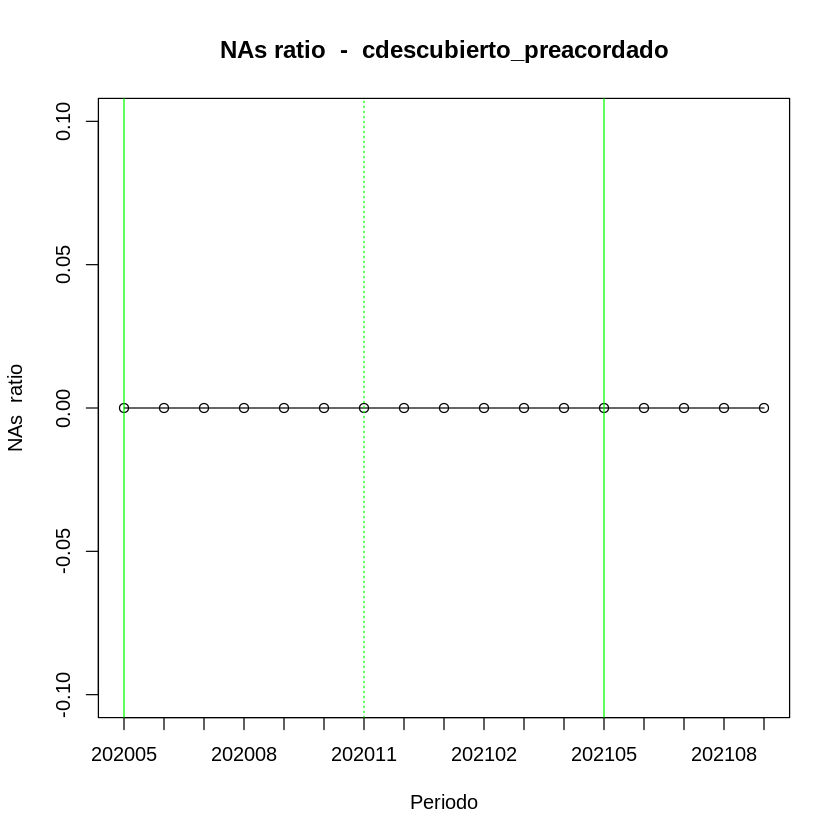

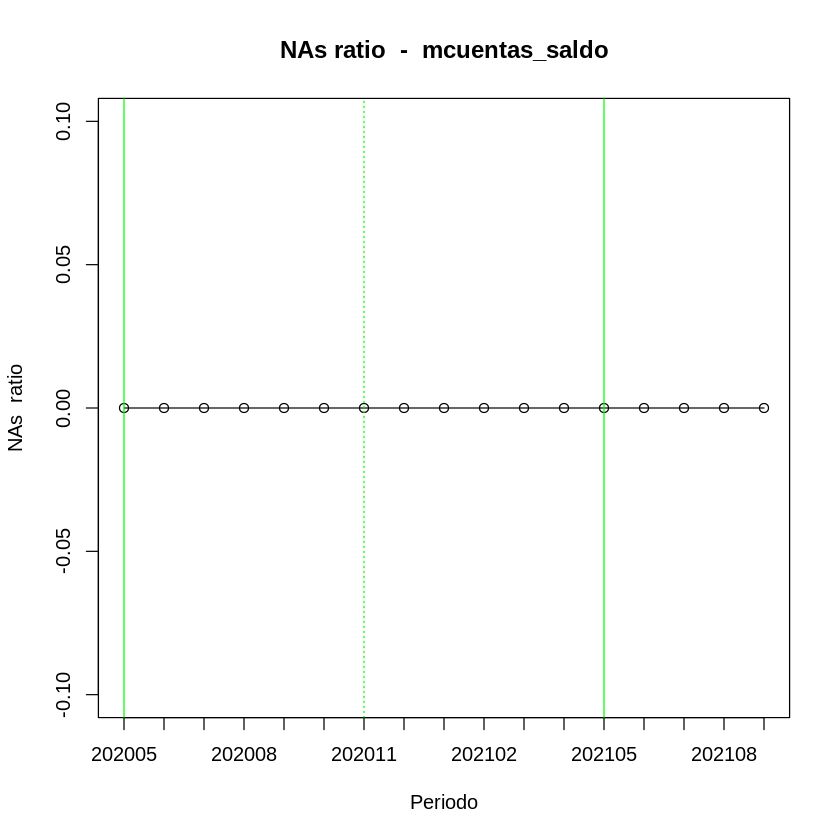

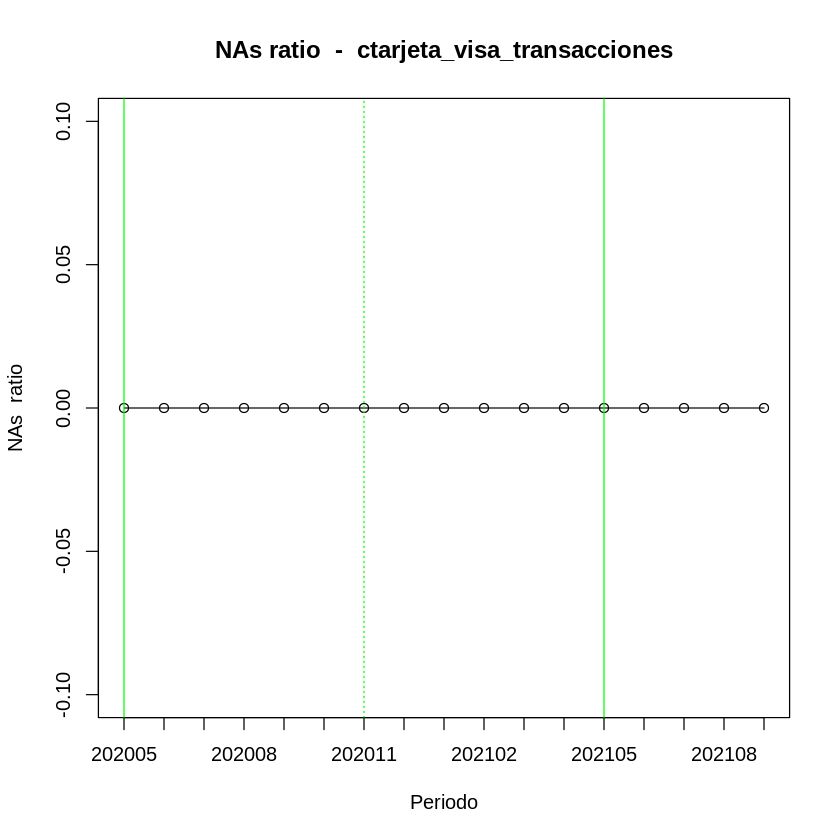

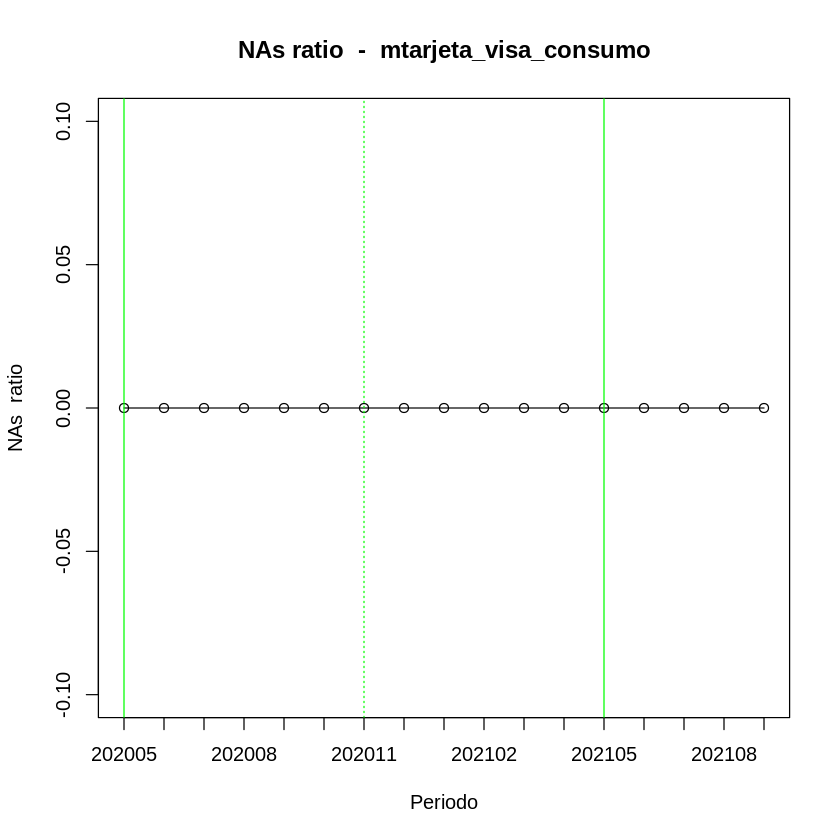

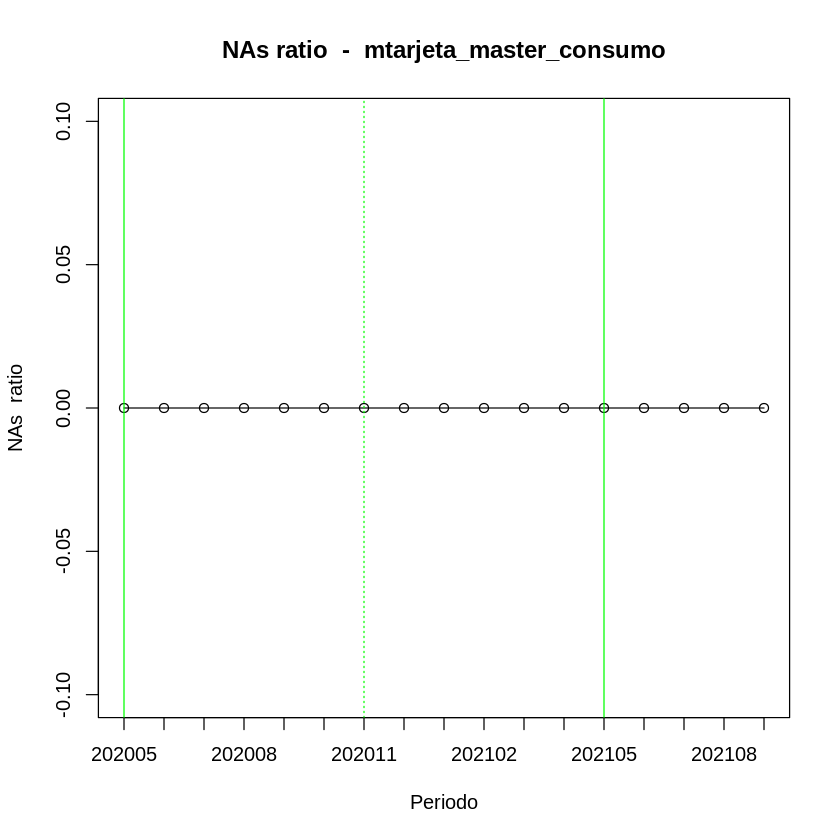

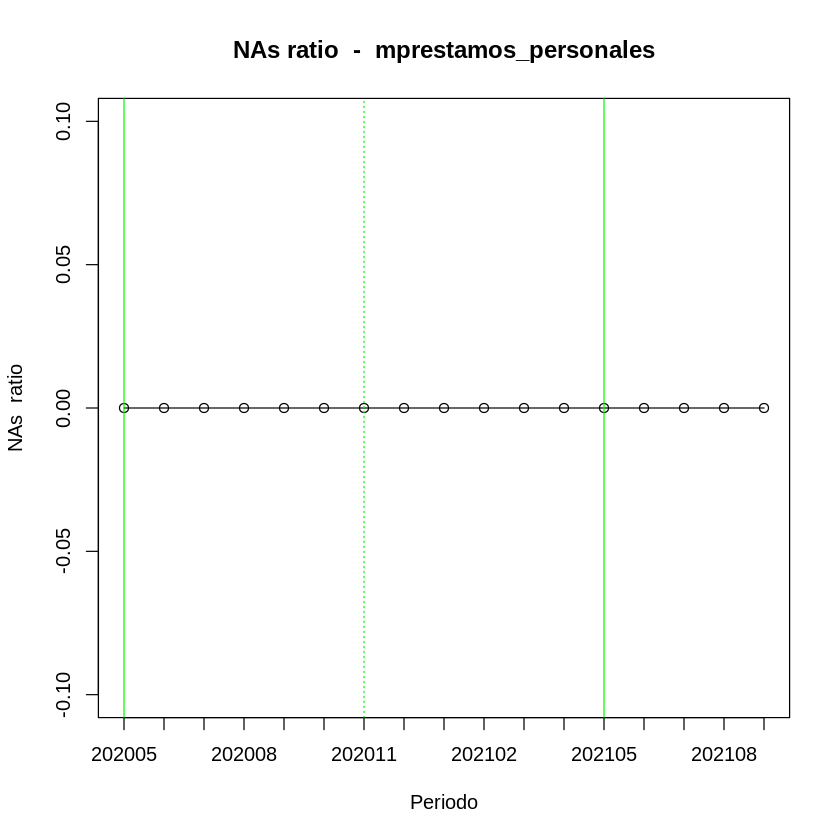

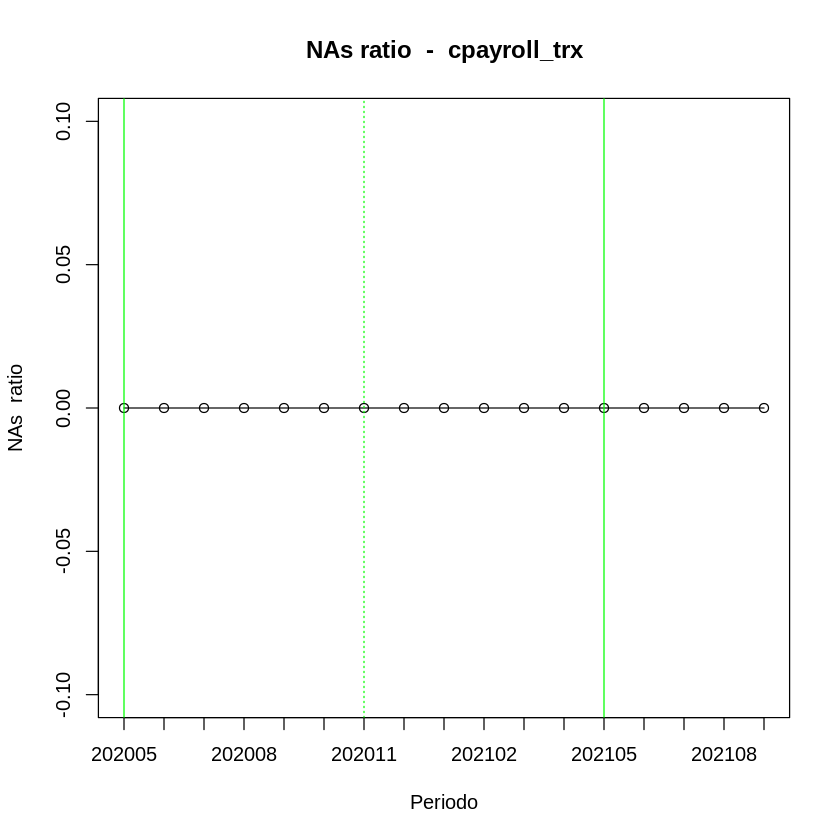

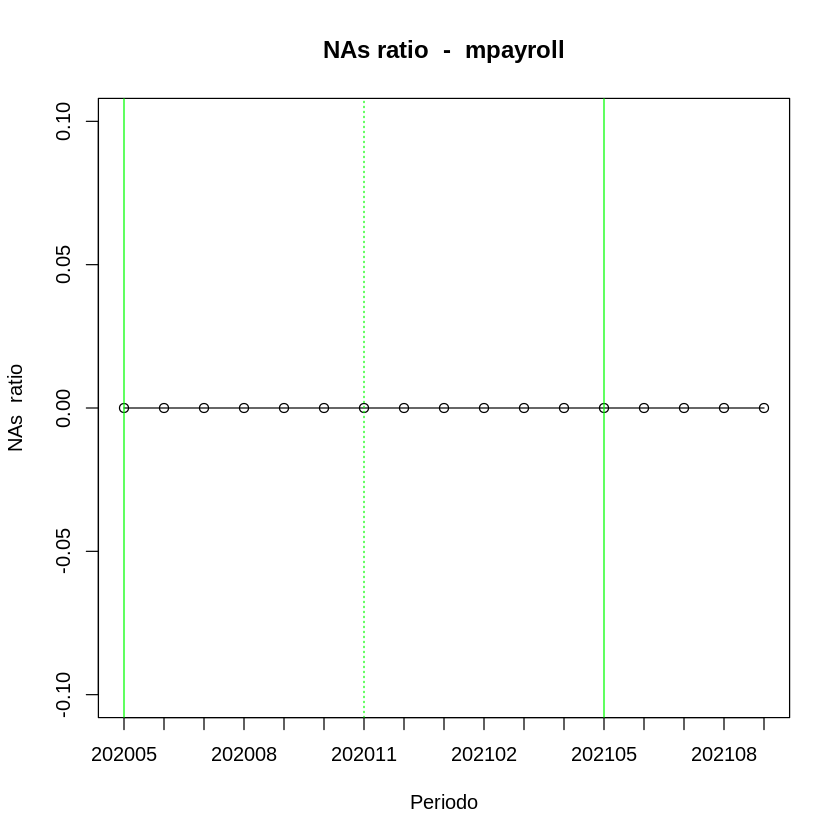

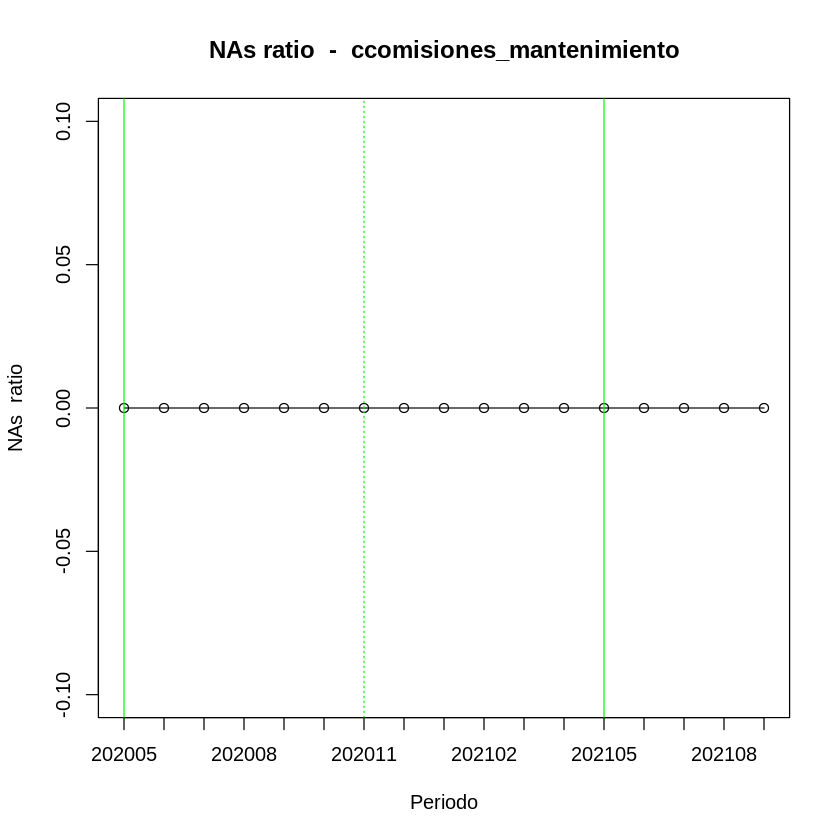

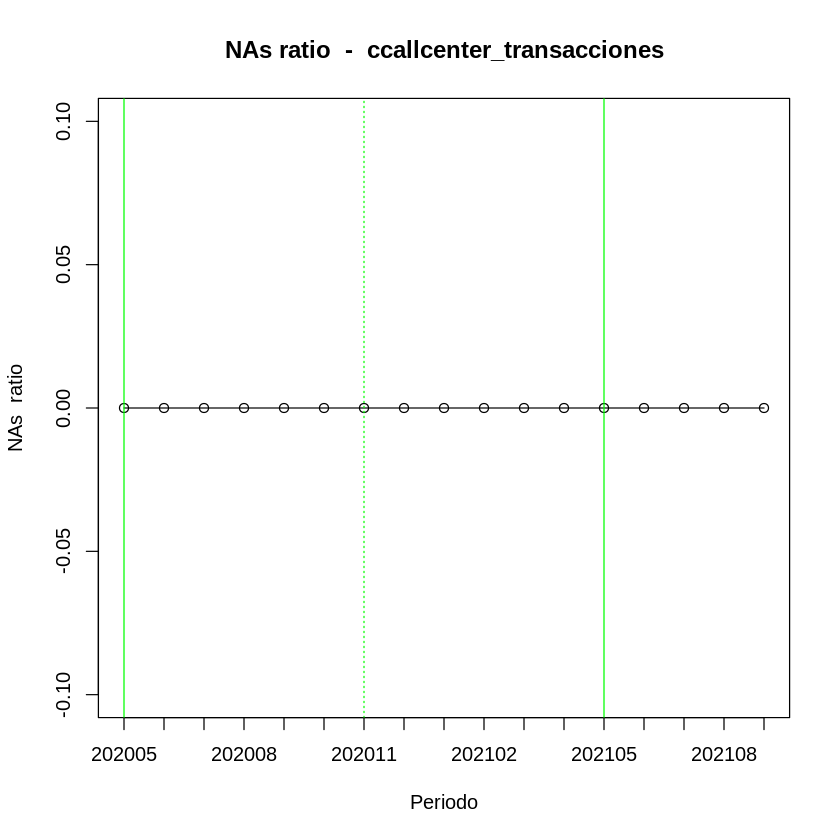

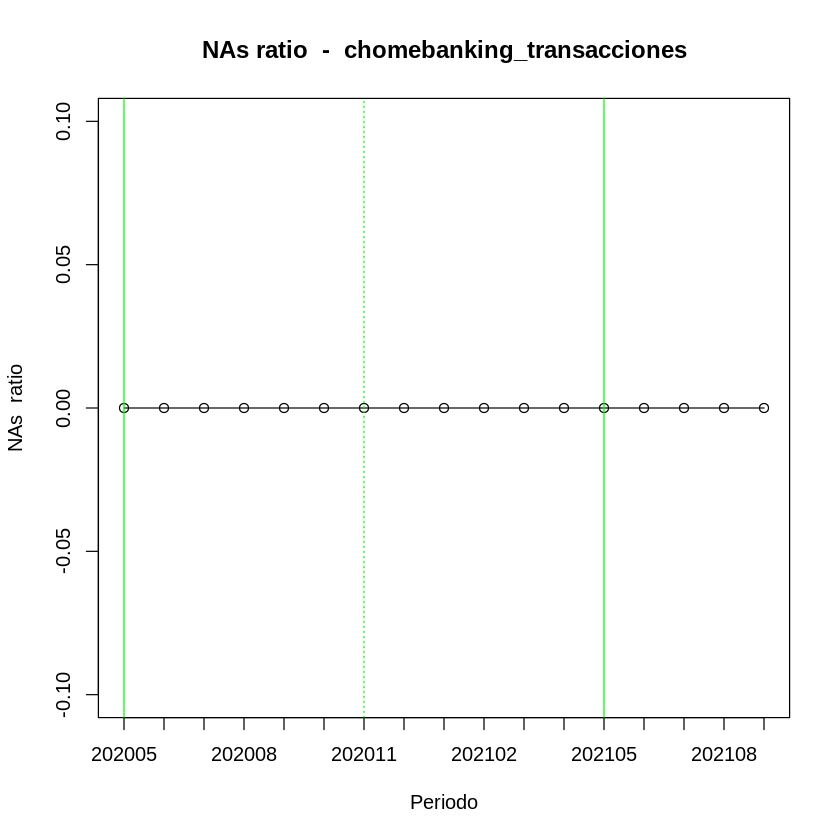

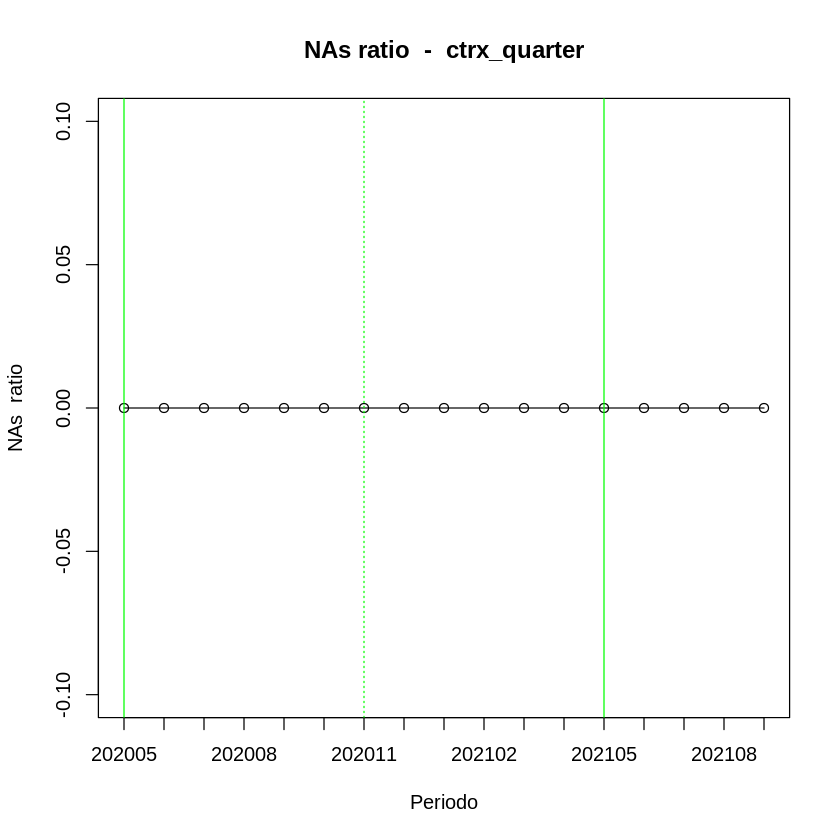

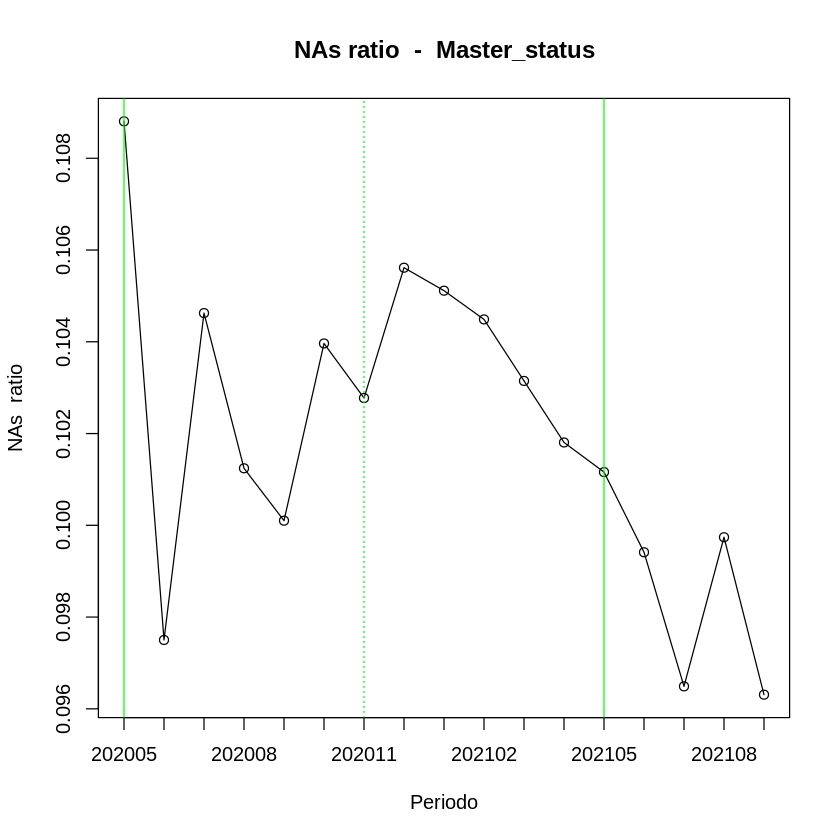

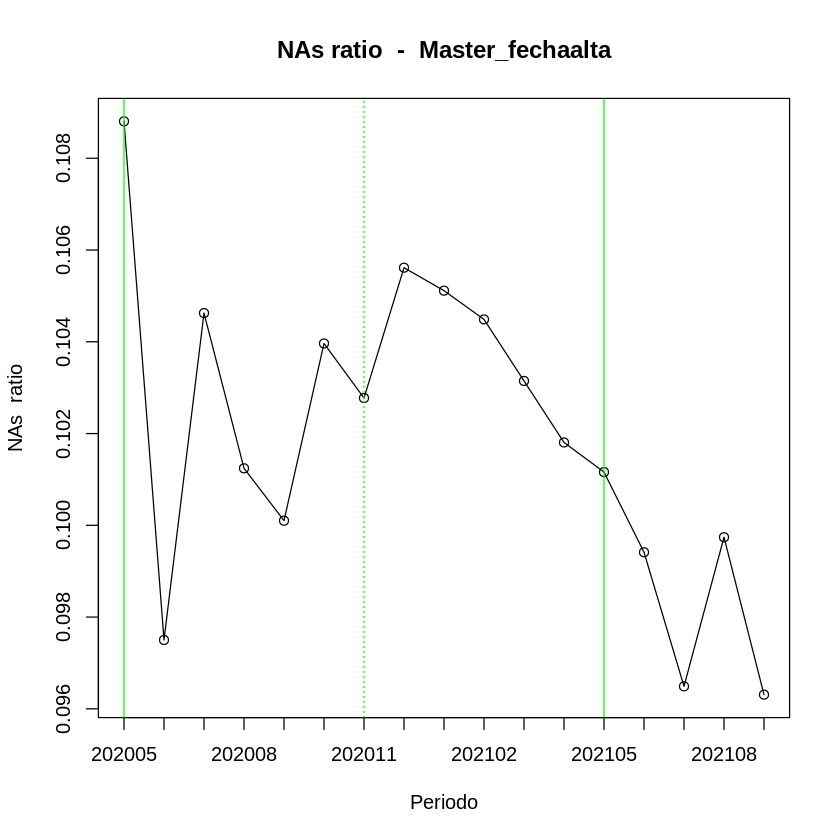

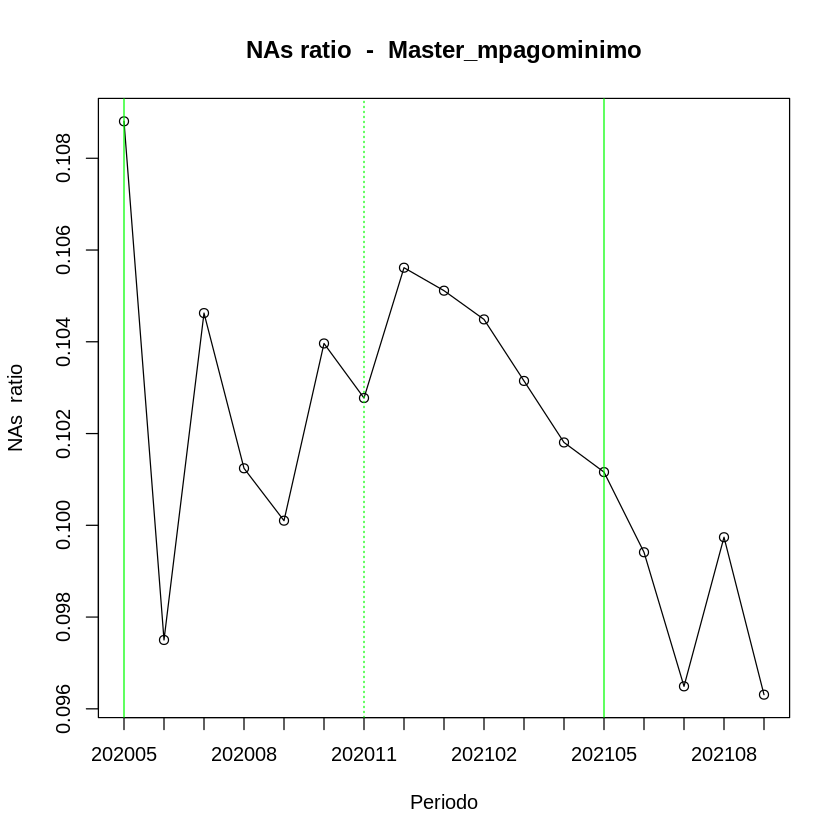

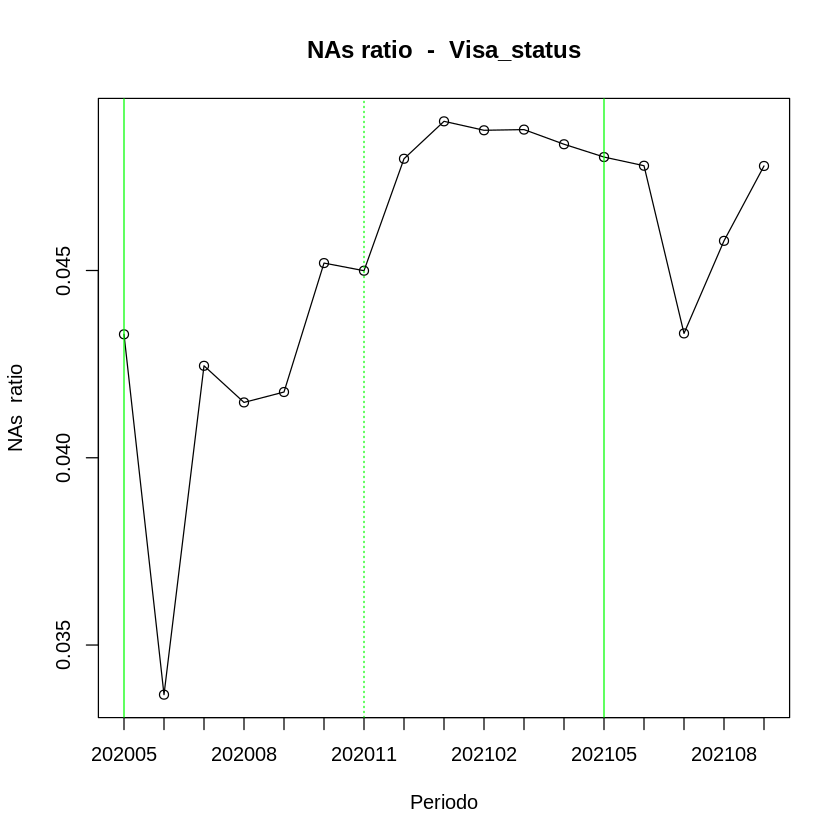

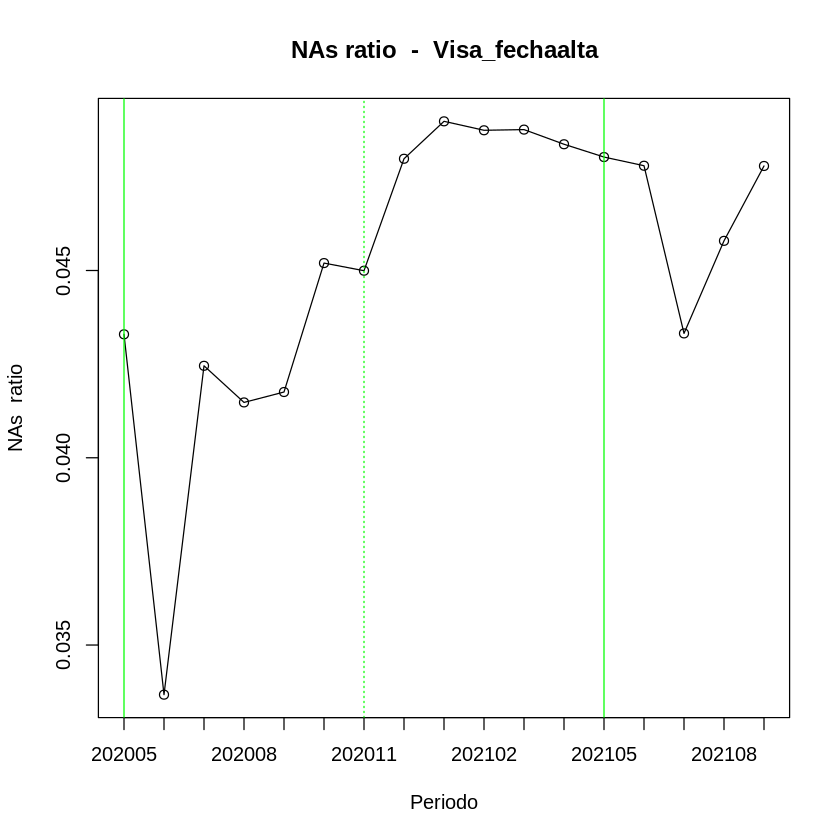

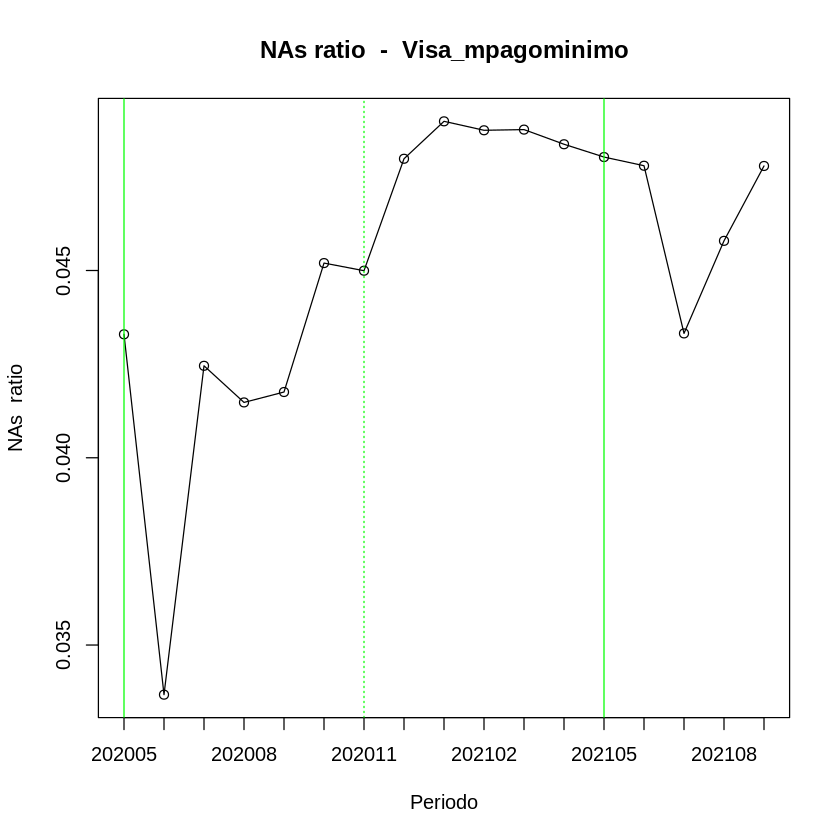

In [9]:
# Para cada variable ,
# grafico para cada mes el ratio de NAs que tiene esa variable
# el nas_ratio de una variable para un mes dado
# es el cociente entre
#   la cantidad de veces que la variable toma el valor nulo (NA) ese mes
#   y la cantidad total de registros para ese mes

# pdf("nas_ratio.pdf")

for (campo in campos_buenos) {
  tbl <- dataset[
    ,
    list("na_ratio" = sum(is.na(get(campo)), na.rm = TRUE) / .N),
    foto_mes
  ]

  ymin <- min(tbl$na_ratio)
  ymax <- max(tbl$na_ratio)
  if (ymin == 0) ymin <- -0.1
  if (ymax == 0) ymax <- 0.1

  plot(
    x = 1:nrow(tbl),
    y = tbl$na_ratio,
    type = "o",
    main = paste0("NAs ratio  -  ", campo),
    xlab = "Periodo",
    ylab = "NAs  ratio",
    ylim = c(ymin, ymax),
    xaxt = "n"
  )

  axis(1, at = 1:nrow(tbl), labels = tbl$foto_mes)

  abline(
    v = c(1, 13, 25),
    col = c("green", "green", "green"),
    lty = c(1, 1, 1),
    lwd = c(1, 1, 1)
  )

  abline(
    v = c(7, 19, 31),
    col = c("green", "green", "green"),
    lty = c(3, 3, 3),
    lwd = c(1, 1, 1)
  )
}

# dev.off()


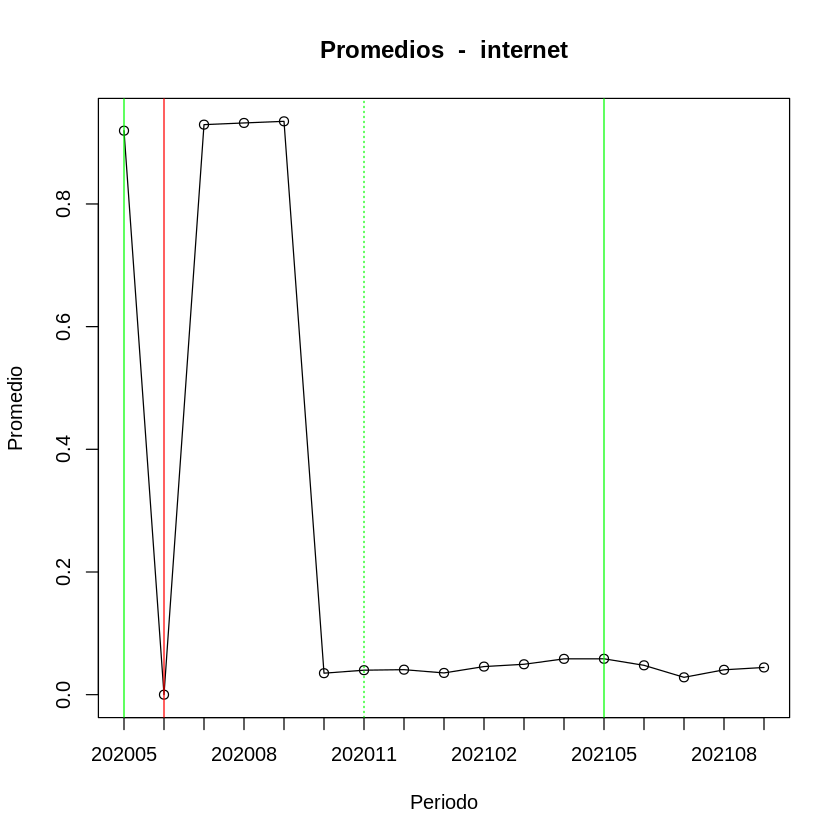

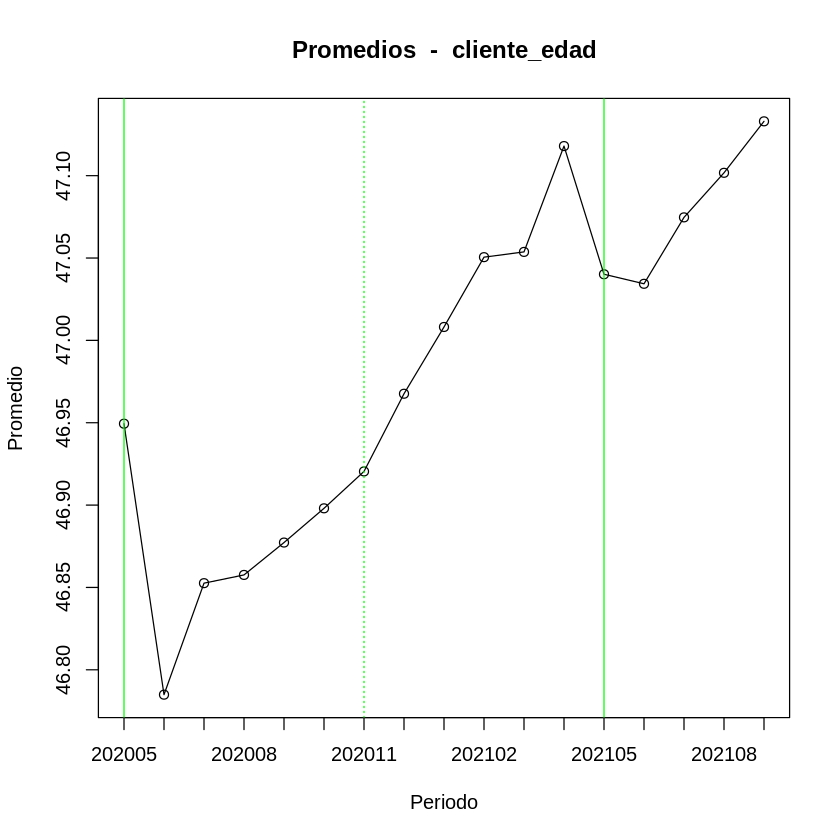

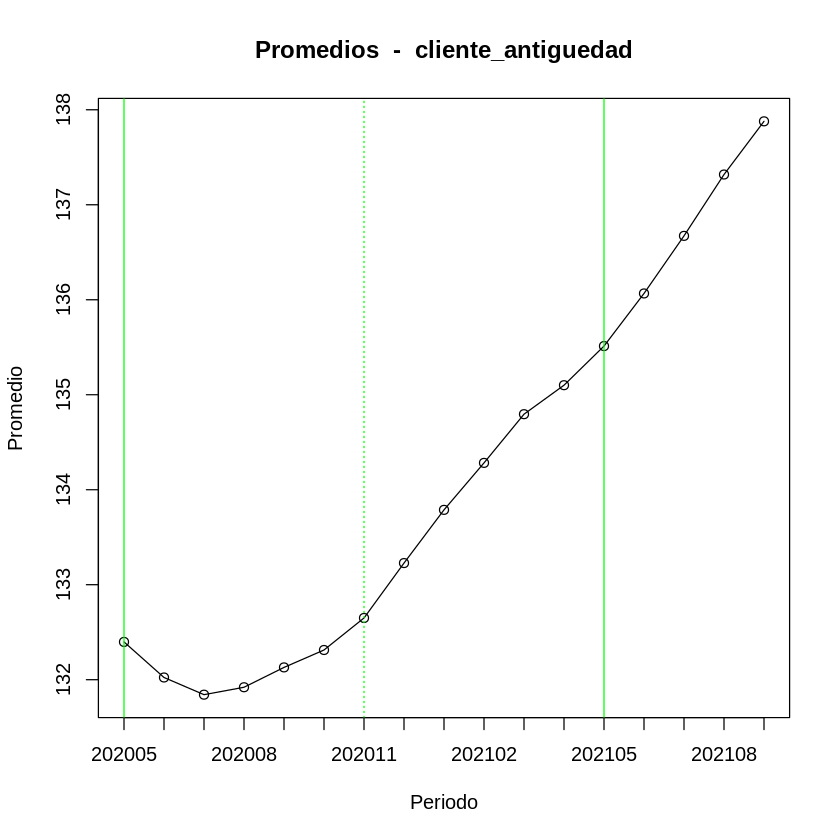

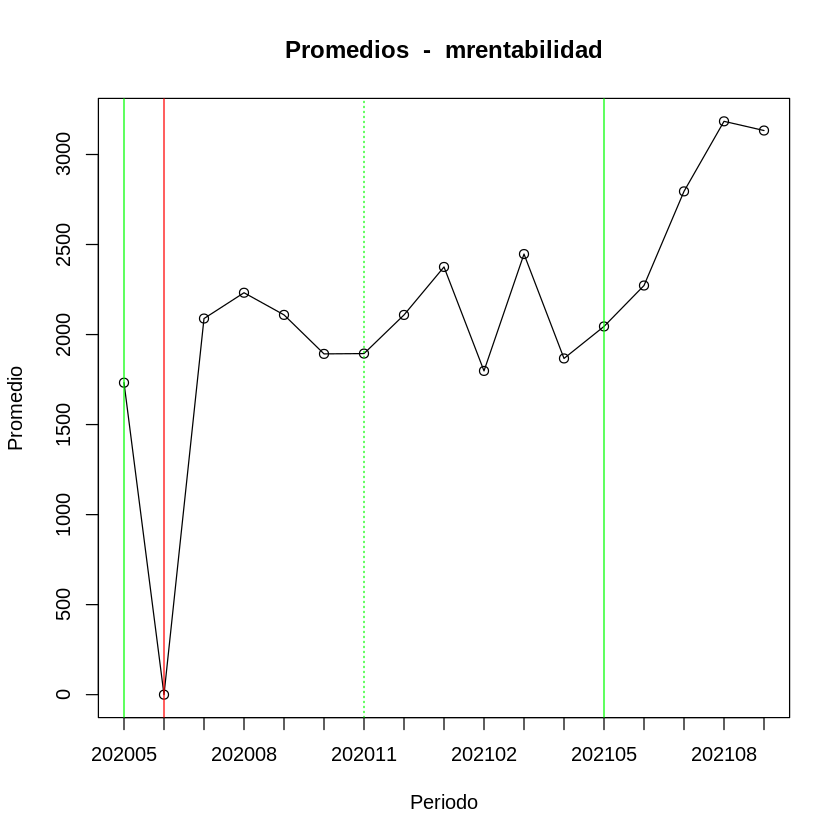

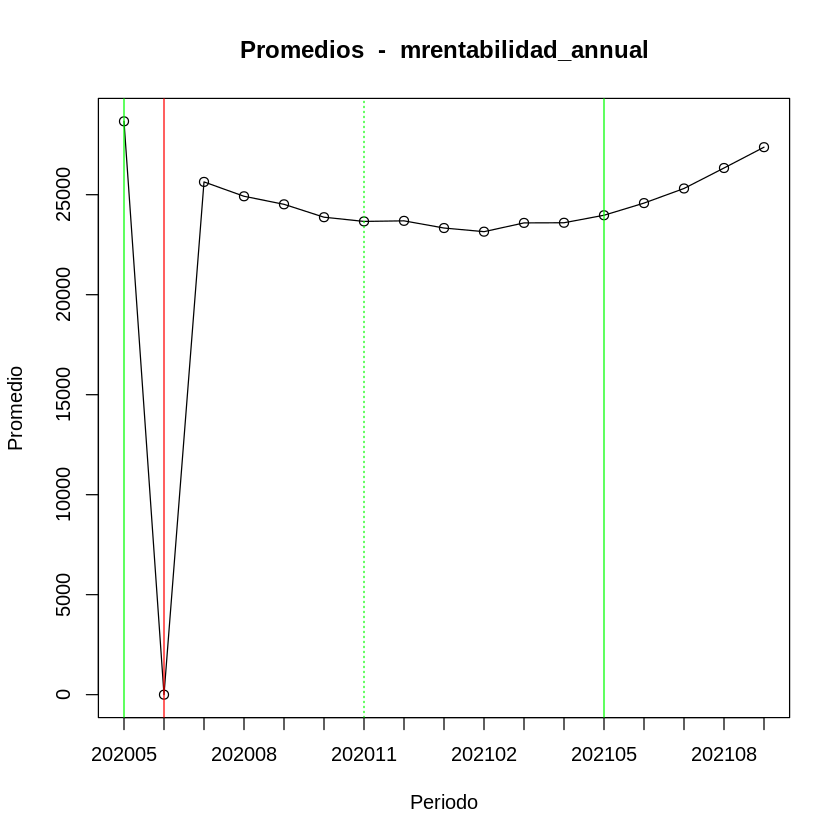

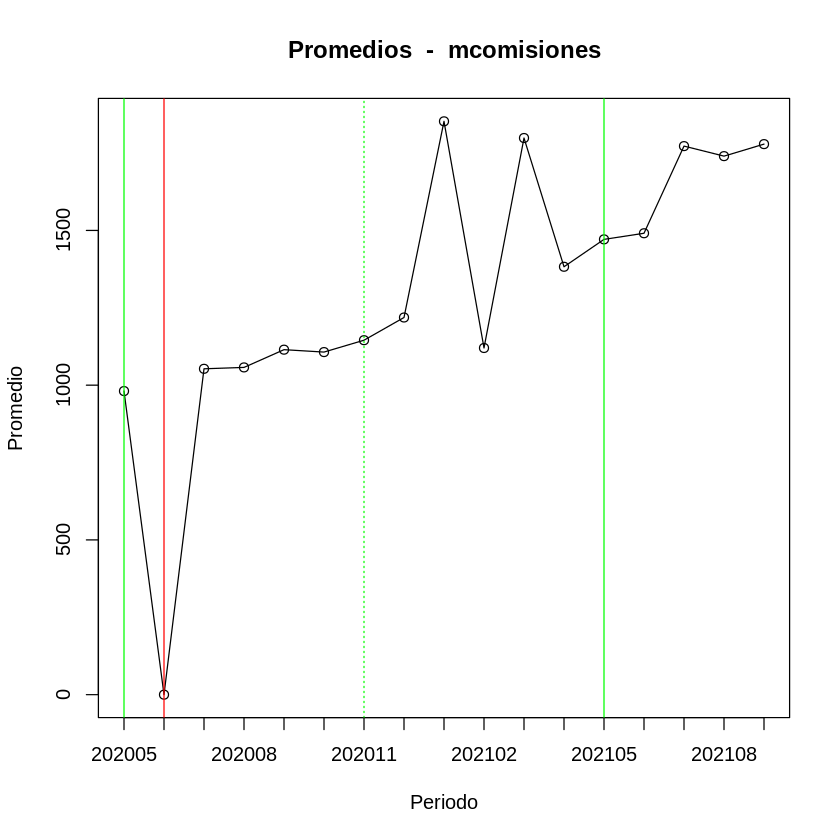

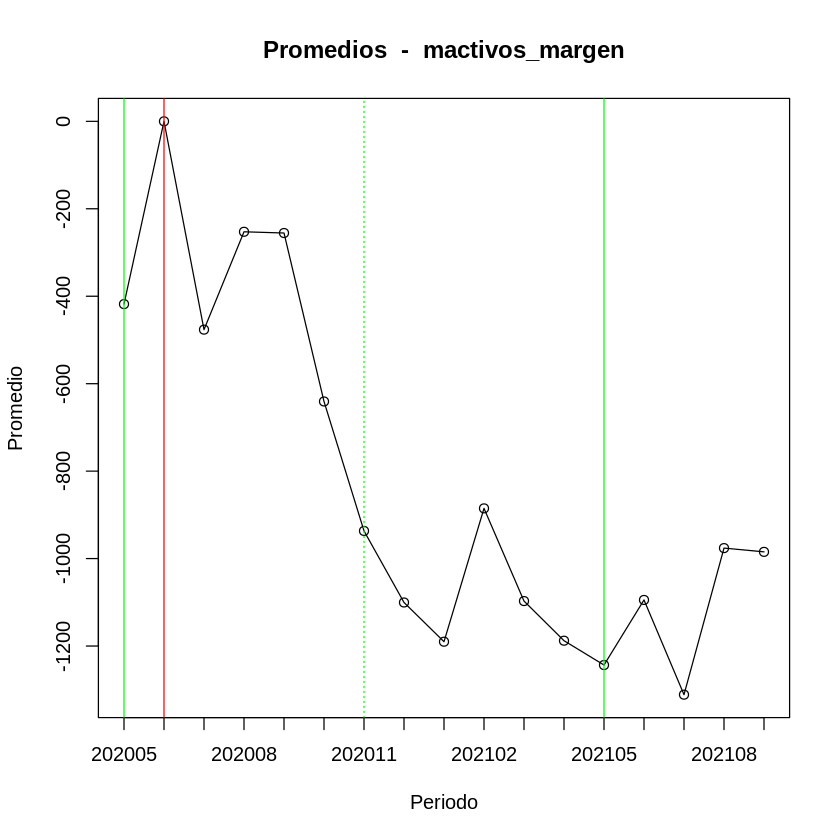

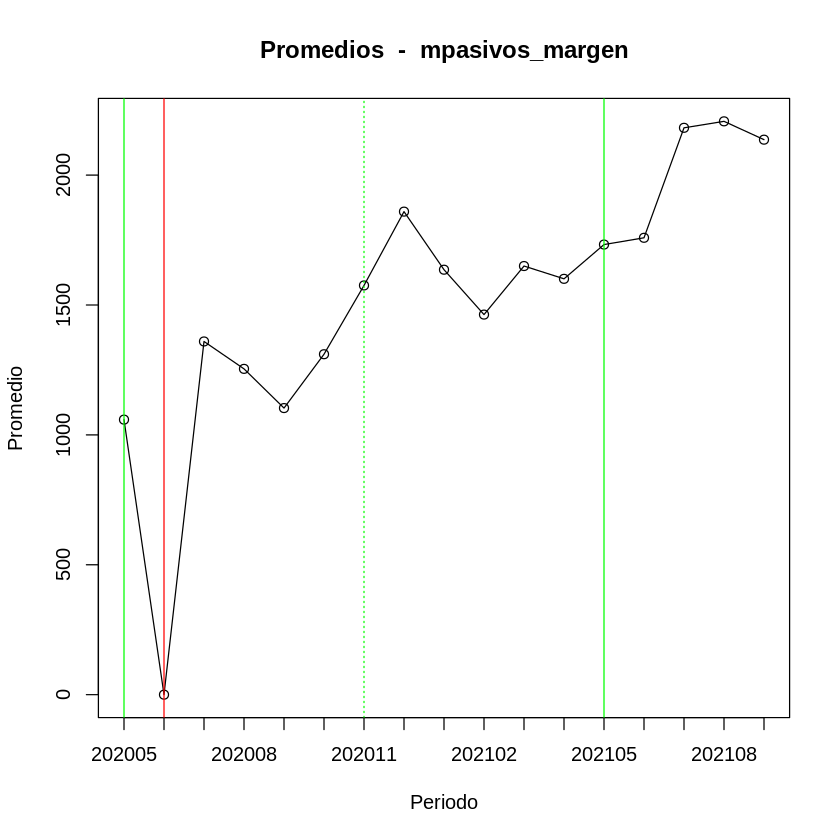

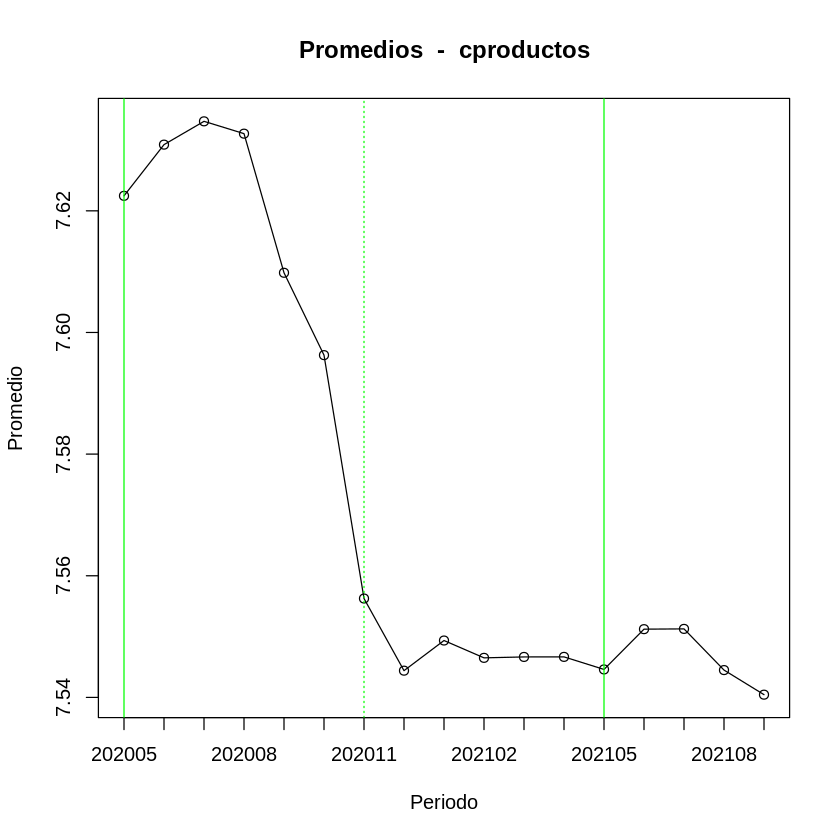

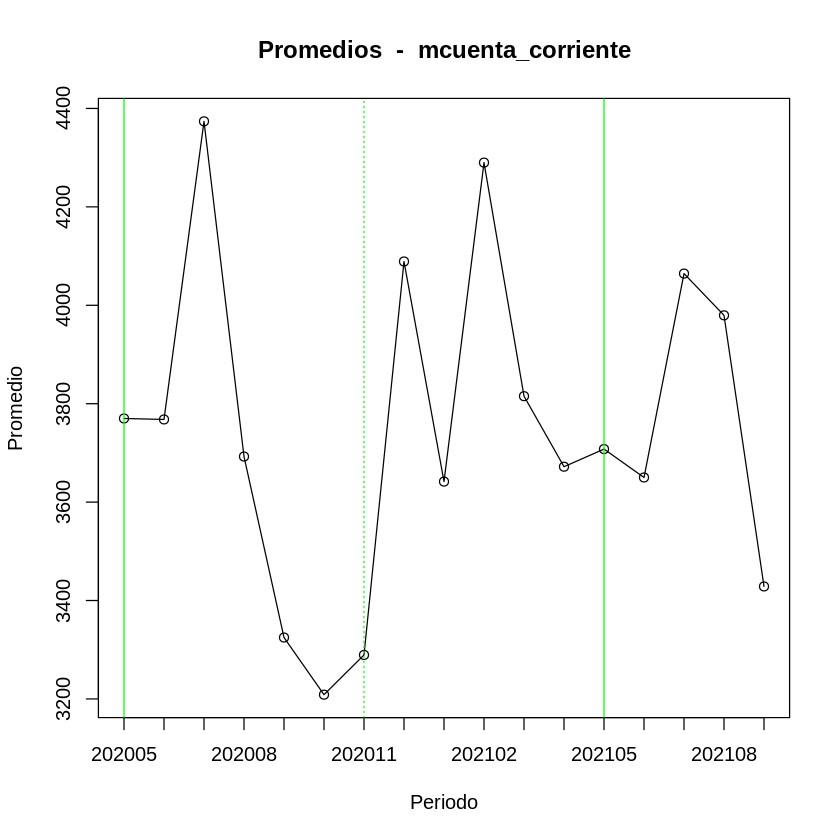

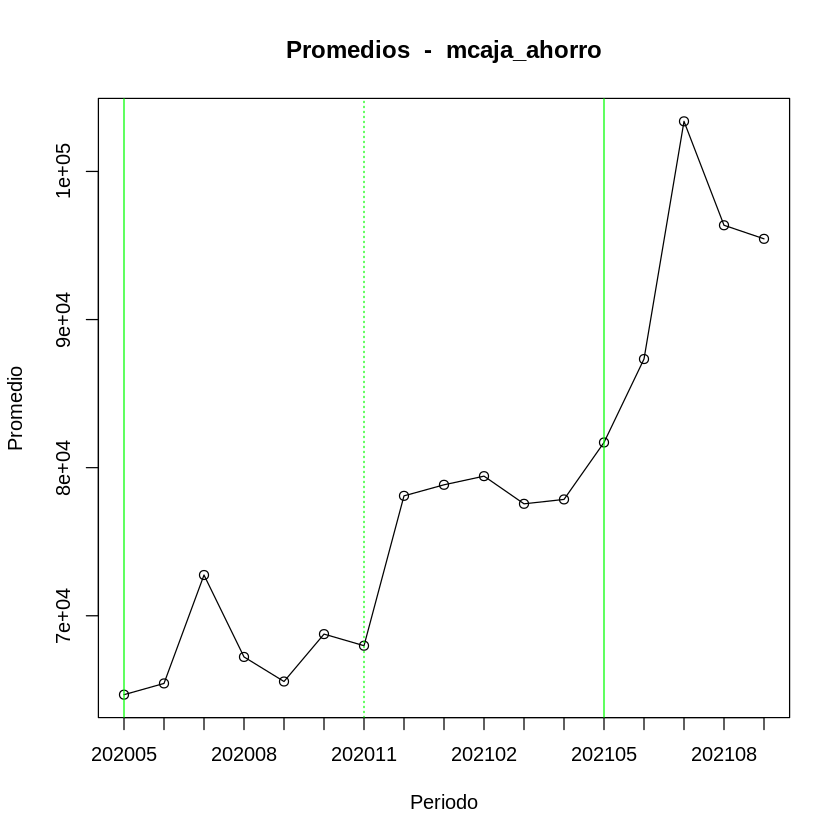

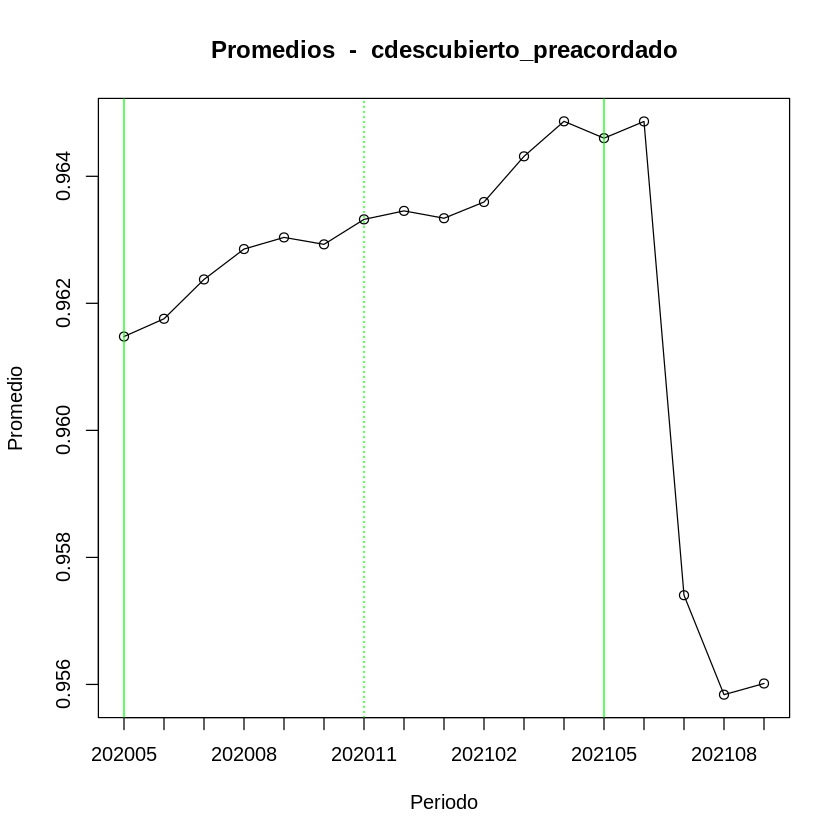

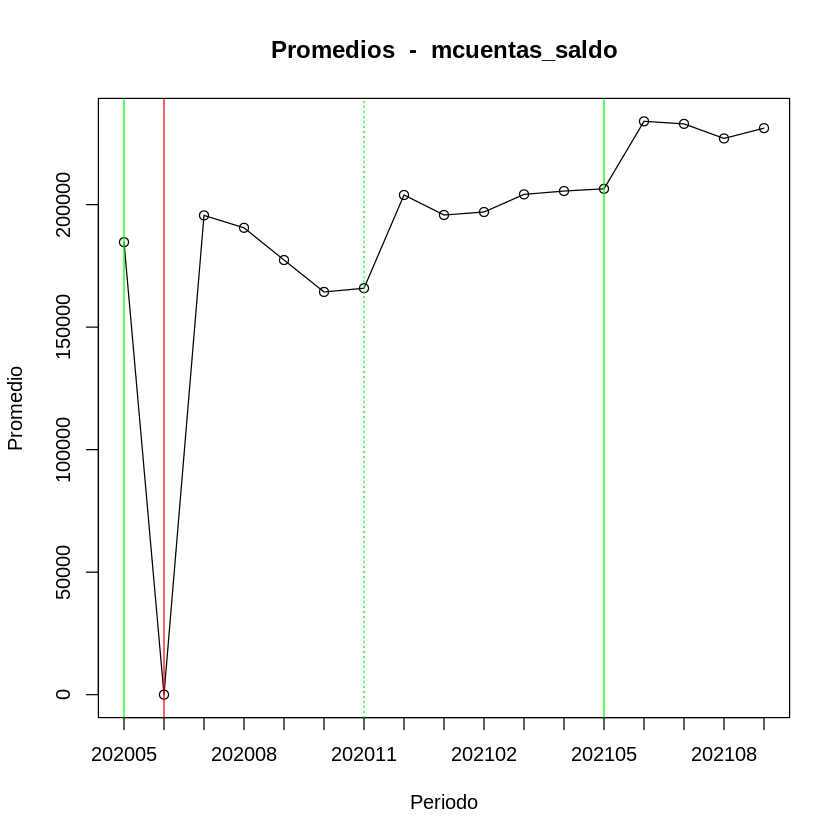

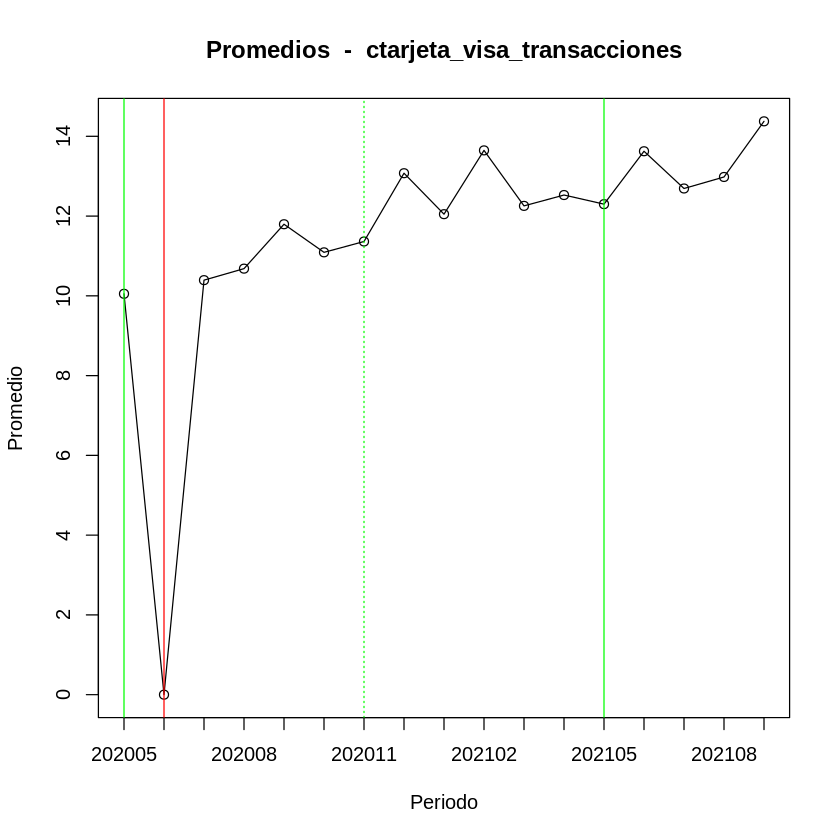

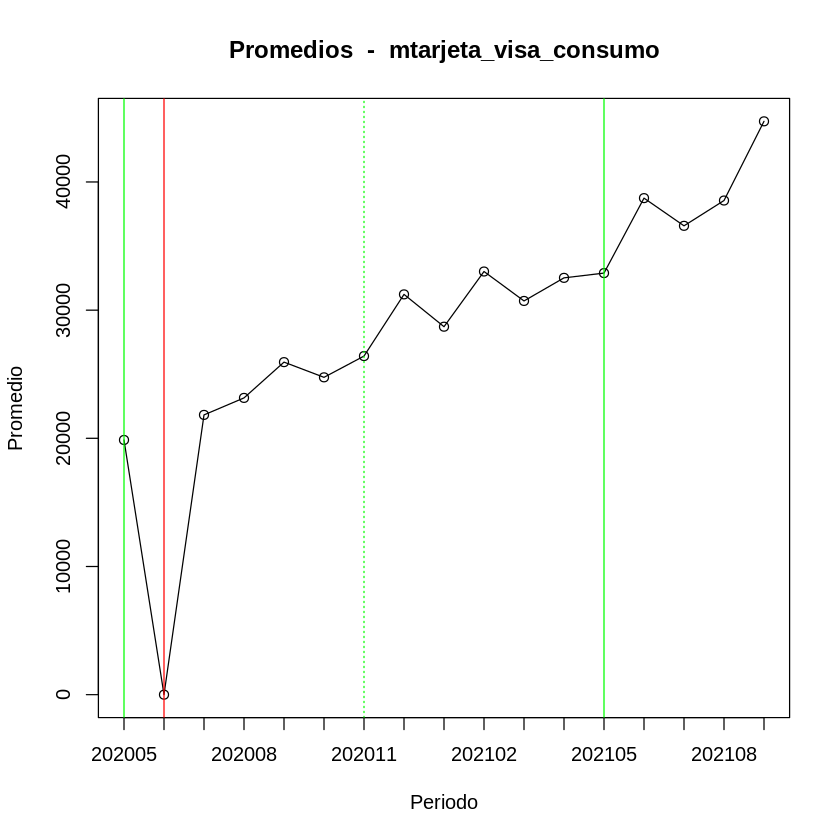

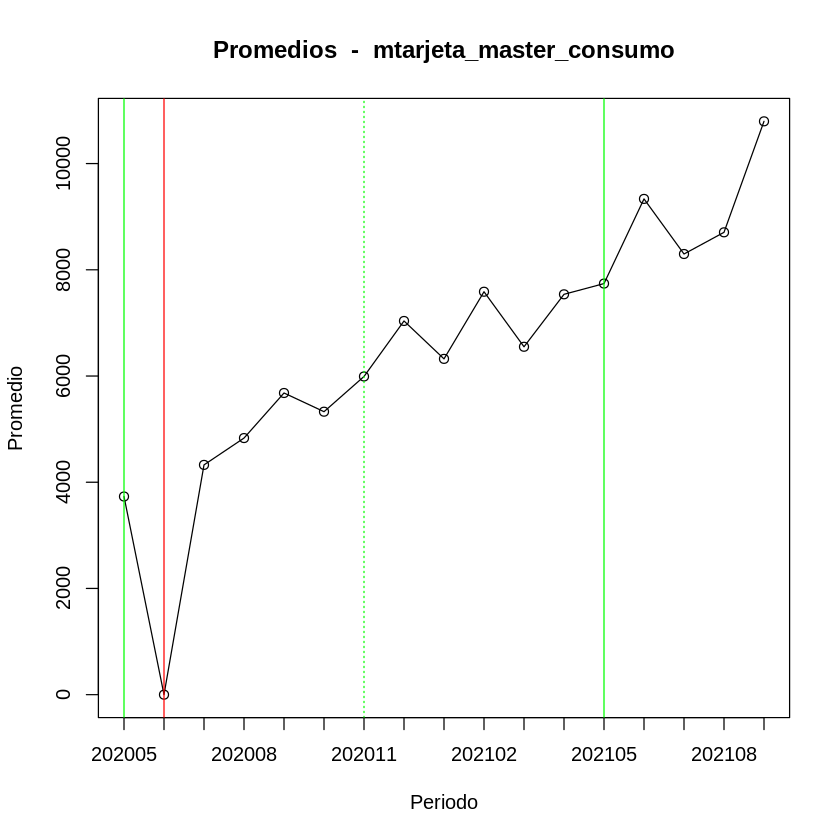

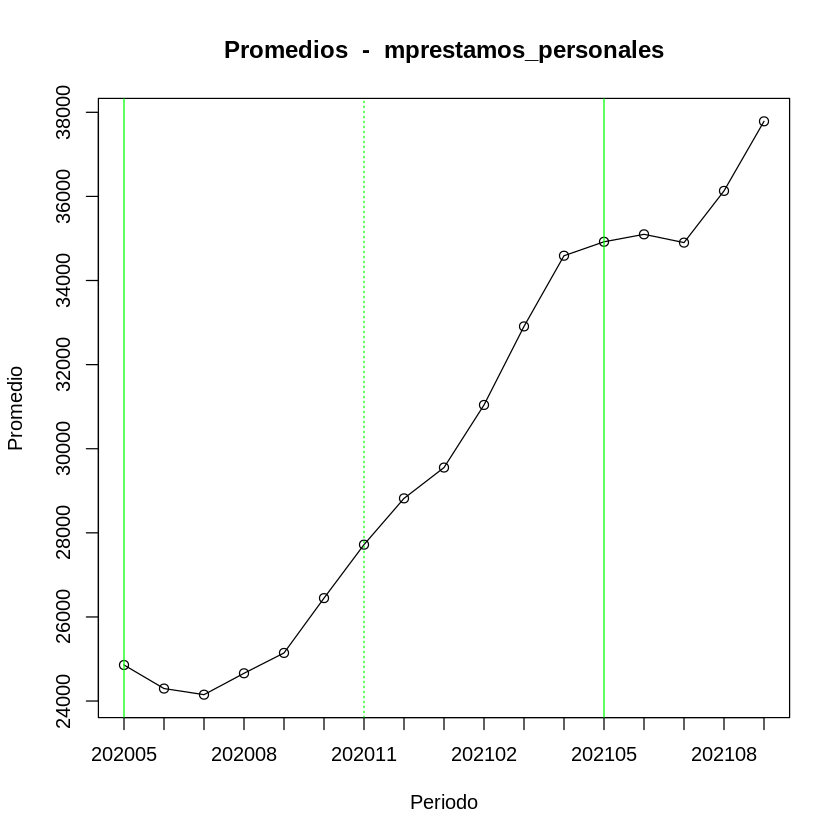

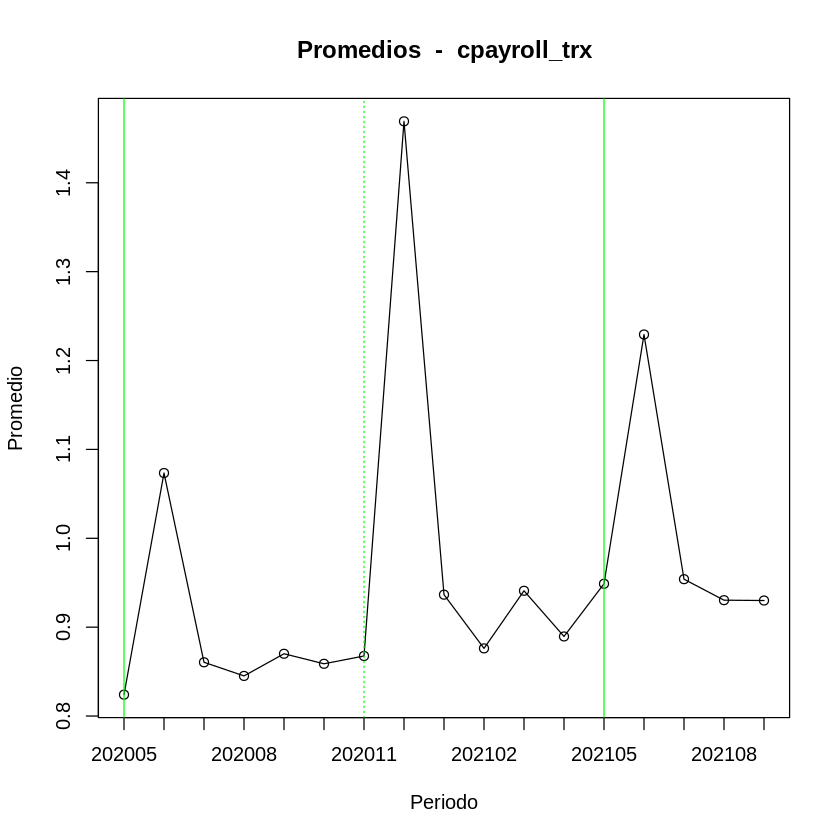

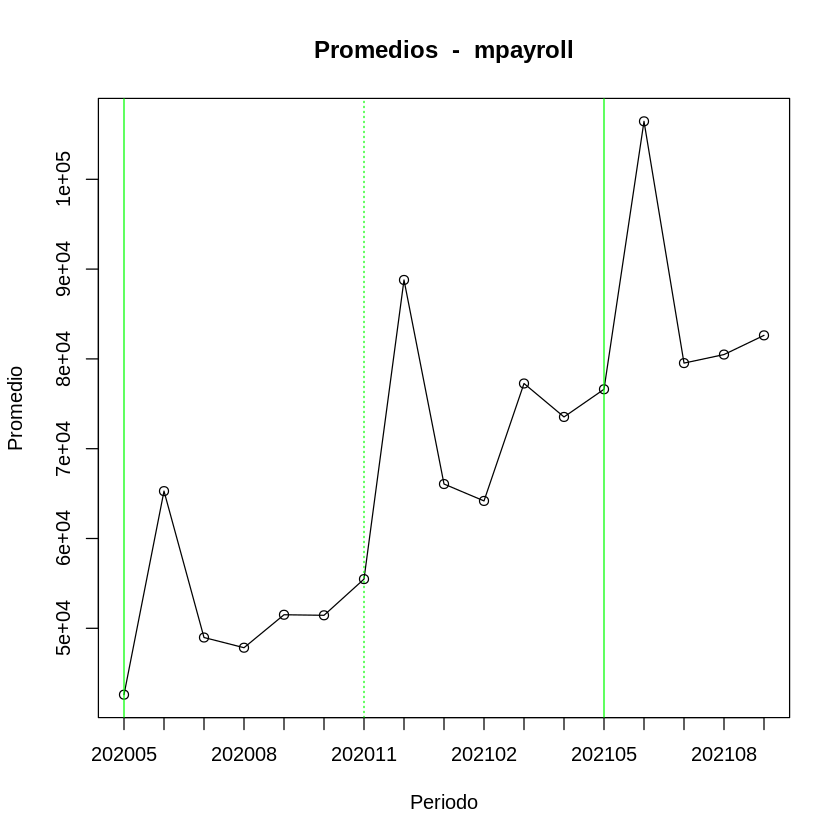

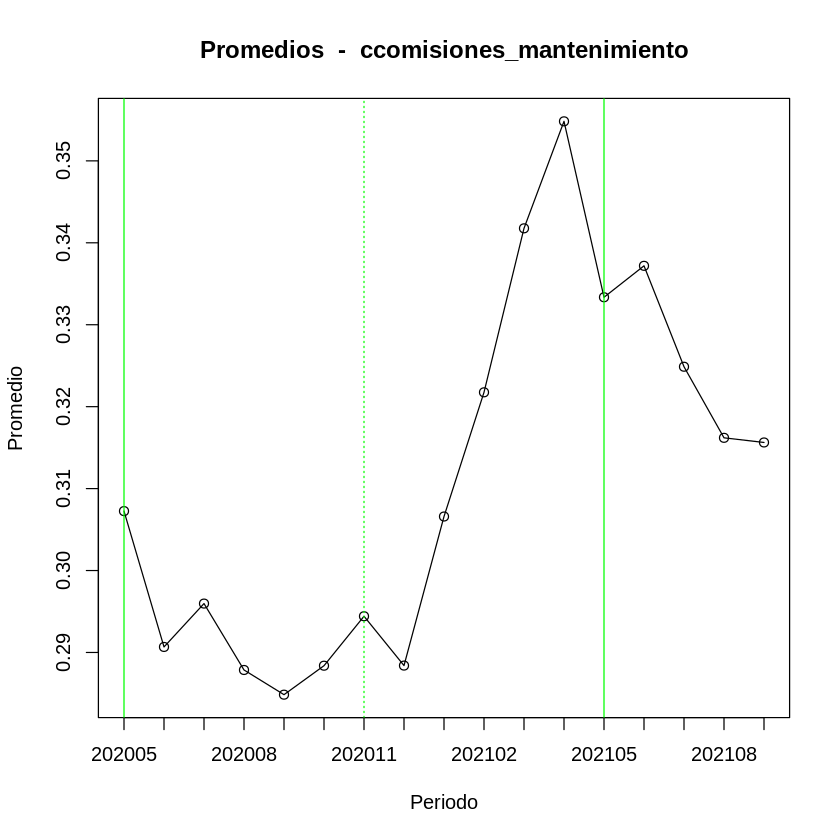

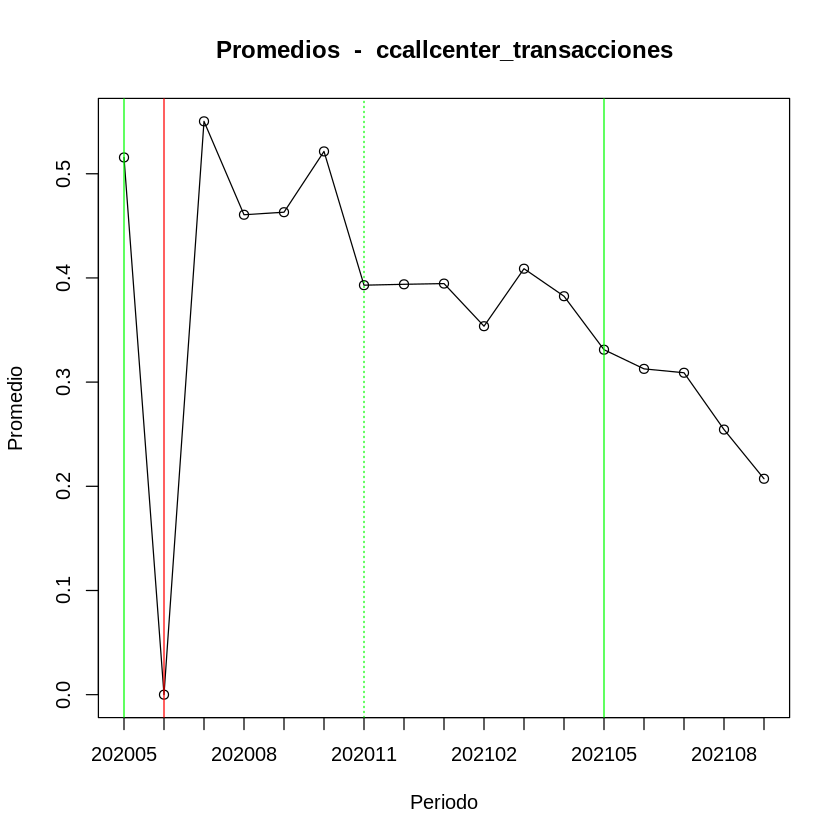

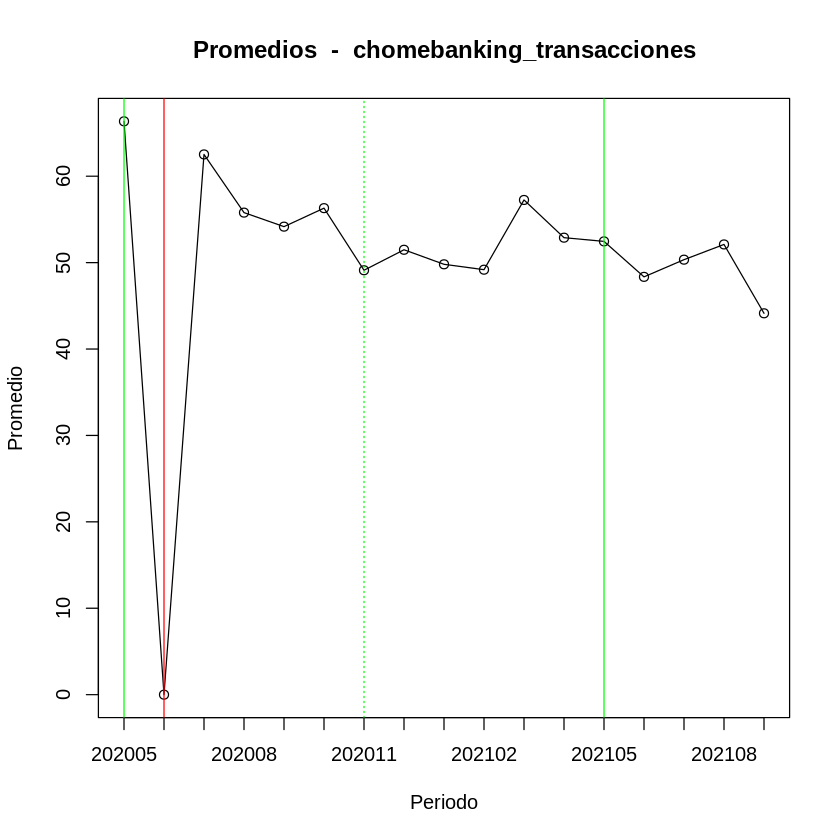

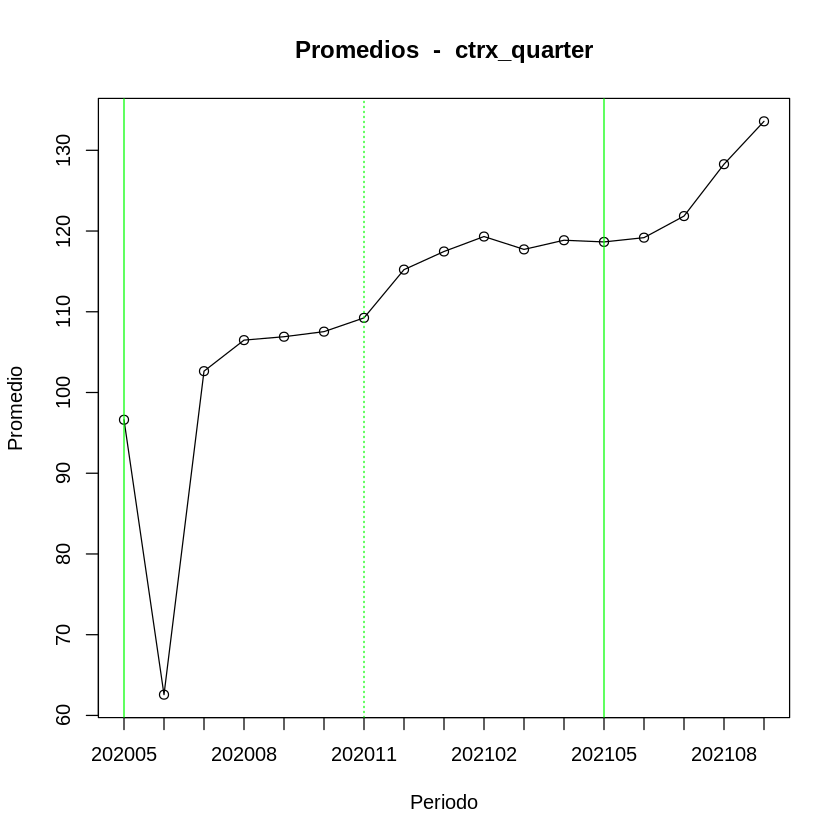

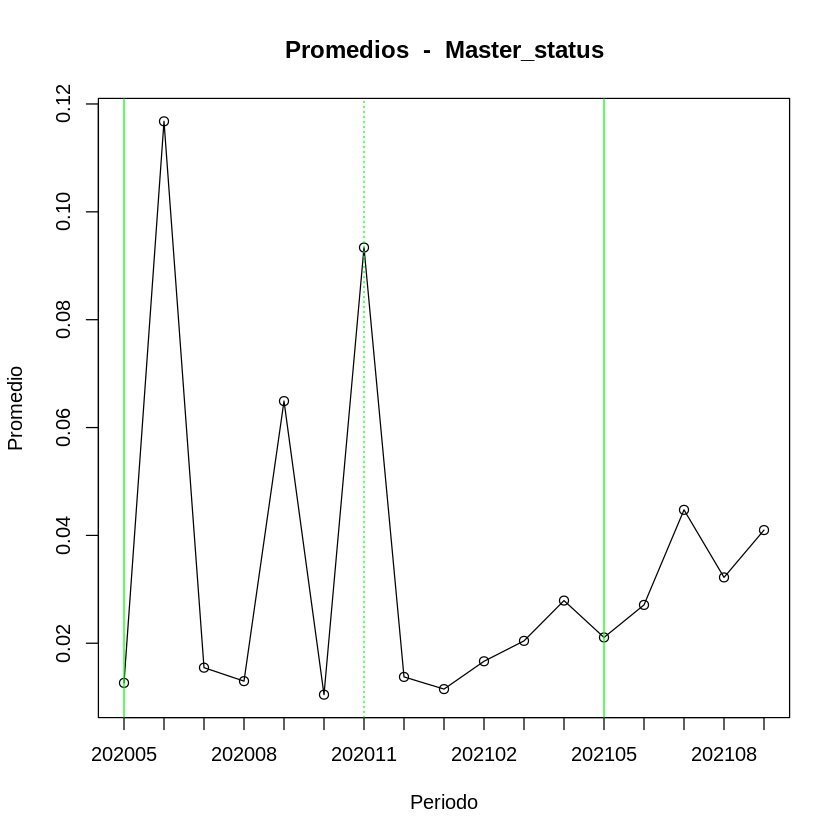

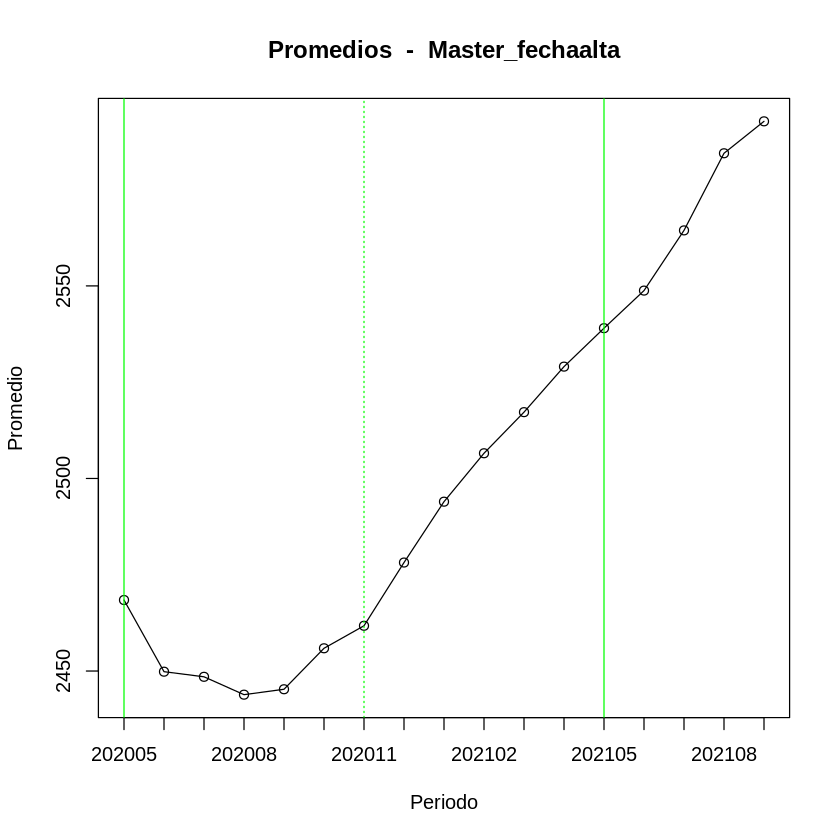

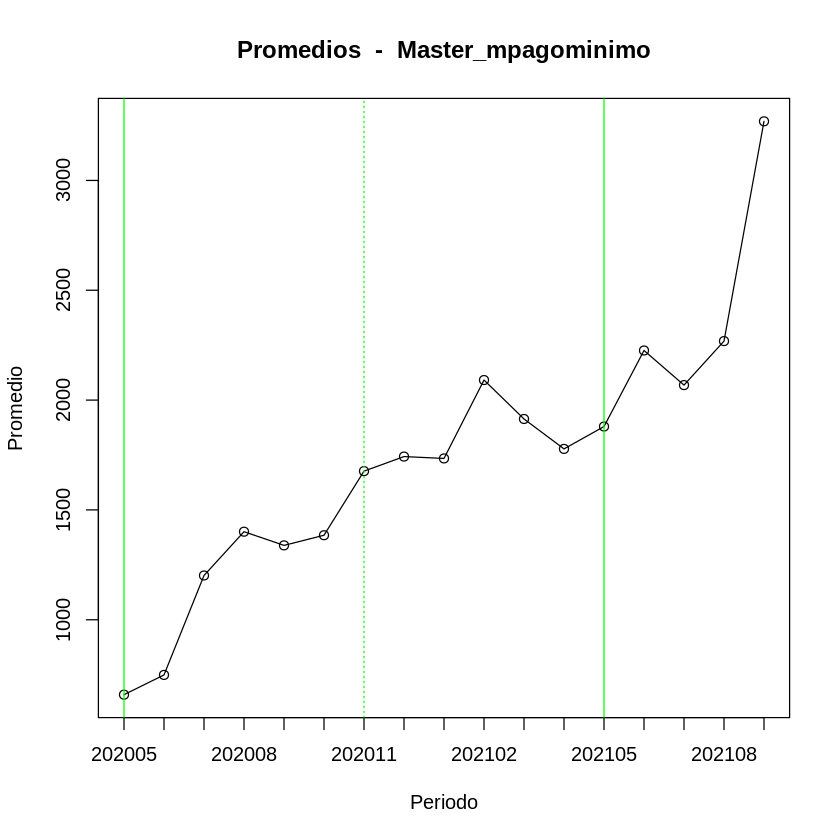

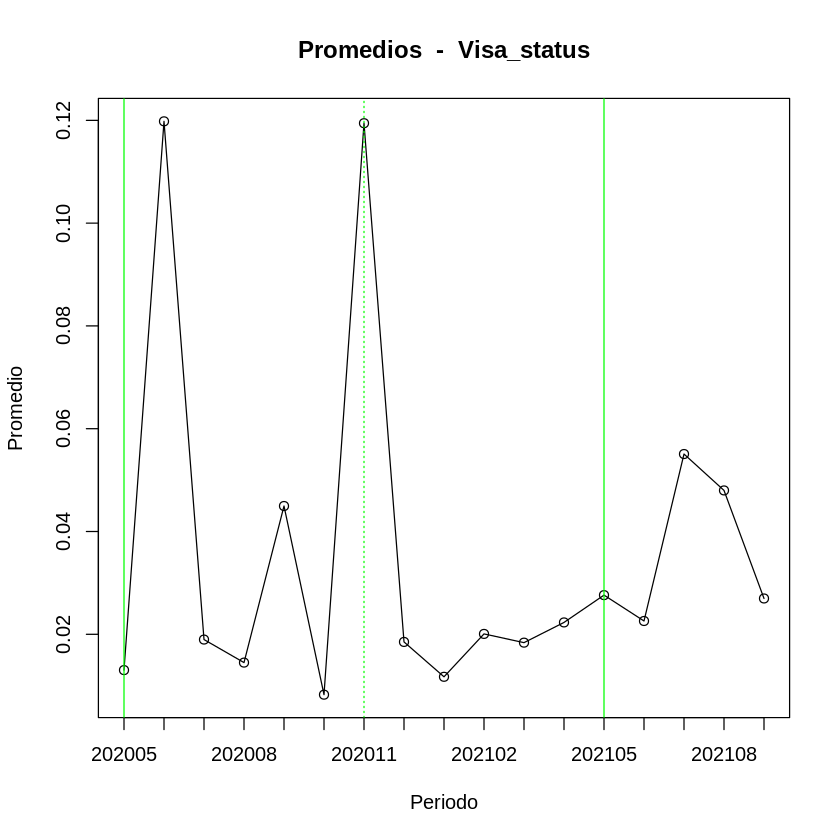

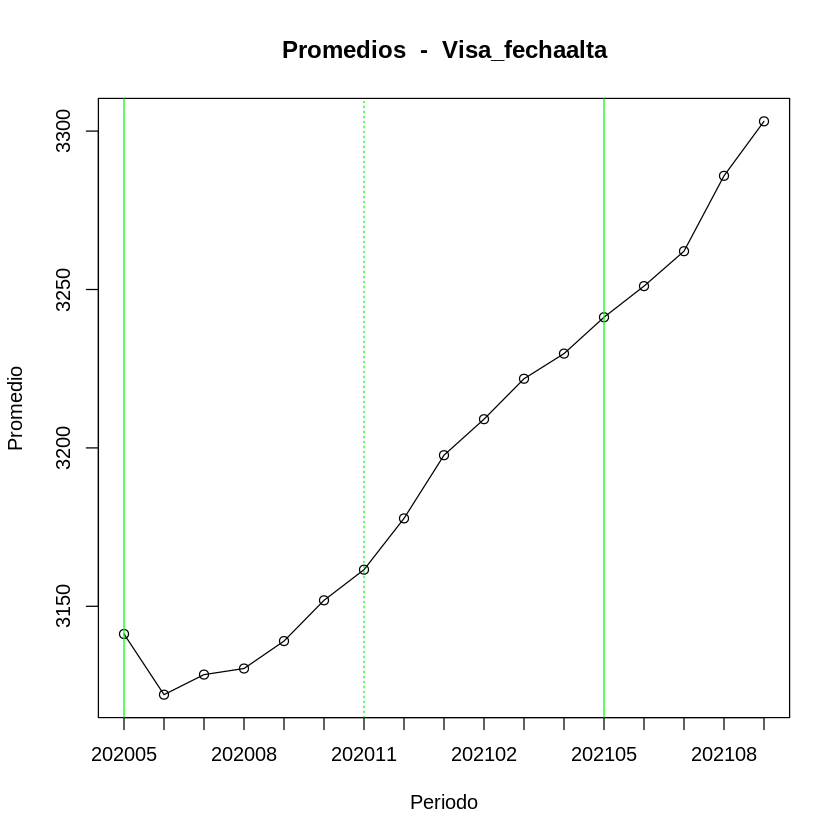

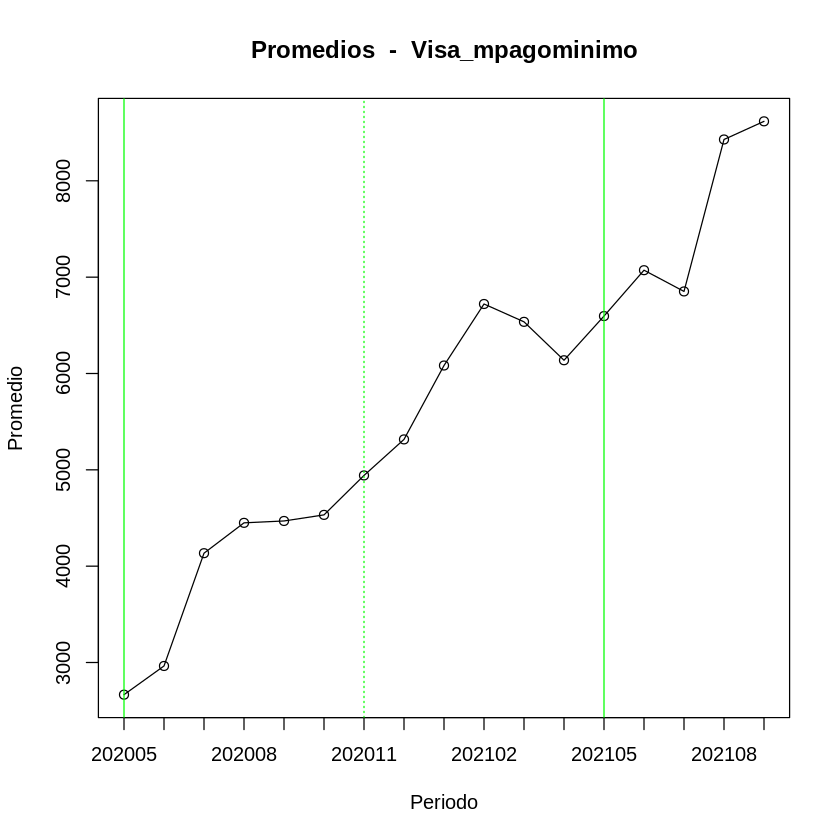

In [10]:
# Para cada variable , grafico para cada mes el promedio de esa variable
# el promedio de una variable para un mes dado es
# la definicion tradicional de promedio


# pdf("promedios.pdf")

for (campo in campos_buenos) {
  tbl <- dataset[
    ,
    list("promedio" = mean(get(campo), na.rm = TRUE)),
    foto_mes
  ]

  ceros <- dataset[
    ,
    list("zero_ratio" = sum(get(campo) == 0, na.rm = TRUE) / .N),
    foto_mes
  ]

  plot(
    x = 1:nrow(tbl),
    y = tbl$promedio,
    type = "o",
    main = paste0("Promedios  -  ", campo),
    xlab = "Periodo",
    ylab = "Promedio",
    xaxt = "n"
  )

  axis(1, at = 1:nrow(tbl), labels = tbl$foto_mes)

  abline(
    v = c(1, 13, 25),
    col = c("green", "green", "green"),
    lty = c(1, 1, 1),
    lwd = c(1, 1, 1)
  )

  abline(
    v = c(7, 19, 31),
    col = c("green", "green", "green"),
    lty = c(3, 3, 3),
    lwd = c(1, 1, 1)
  )

  for (i in 1:nrow(tbl)) {
    if (ceros[i, zero_ratio] > 0.99 & median(ceros[, zero_ratio]) < 0.99) {
      abline(
        v = c(i),
        col = c("red"), lty = c(1), lwd = c(1)
      )
    }
  }
}

# dev.off()


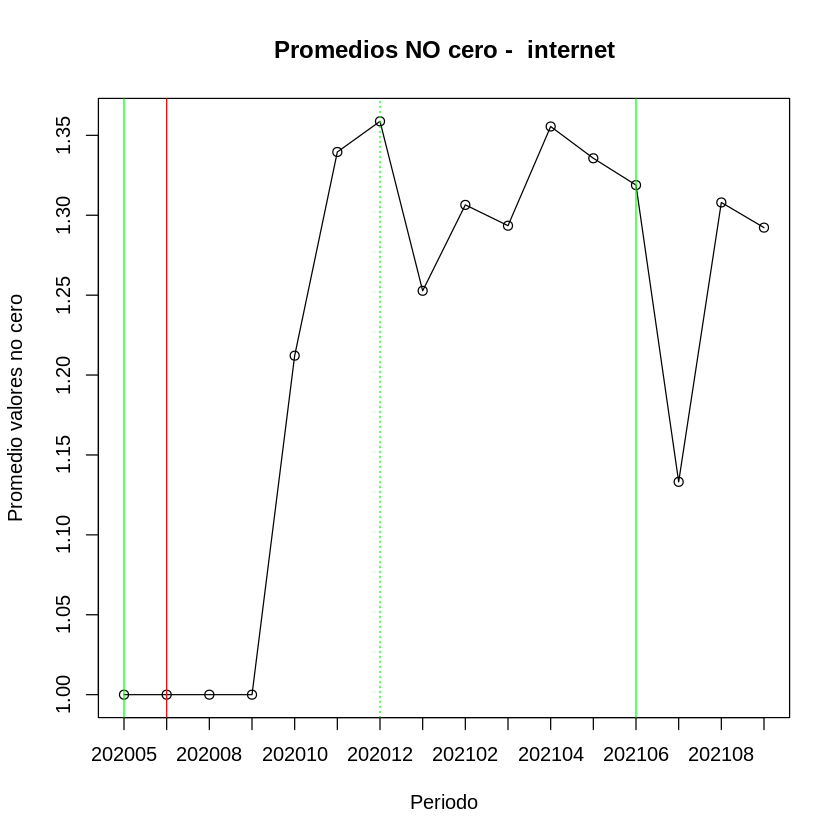

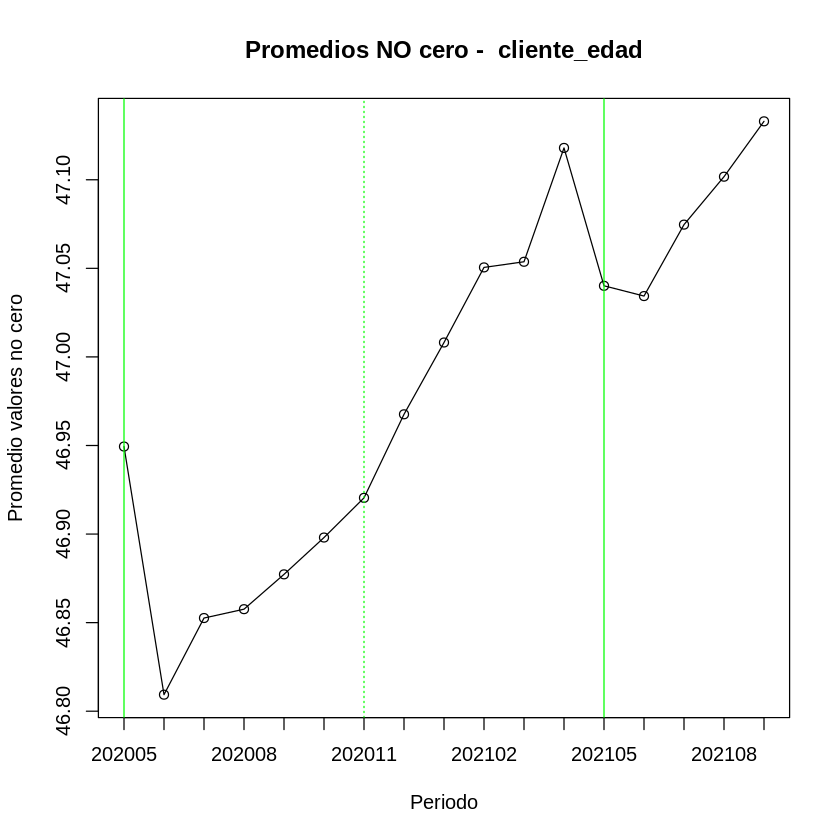

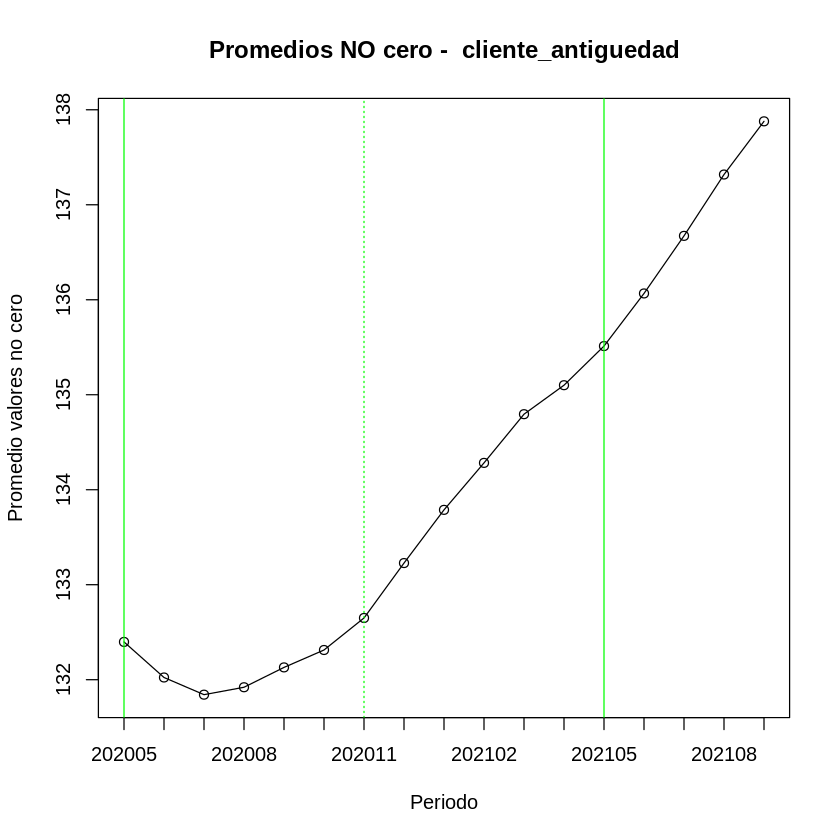

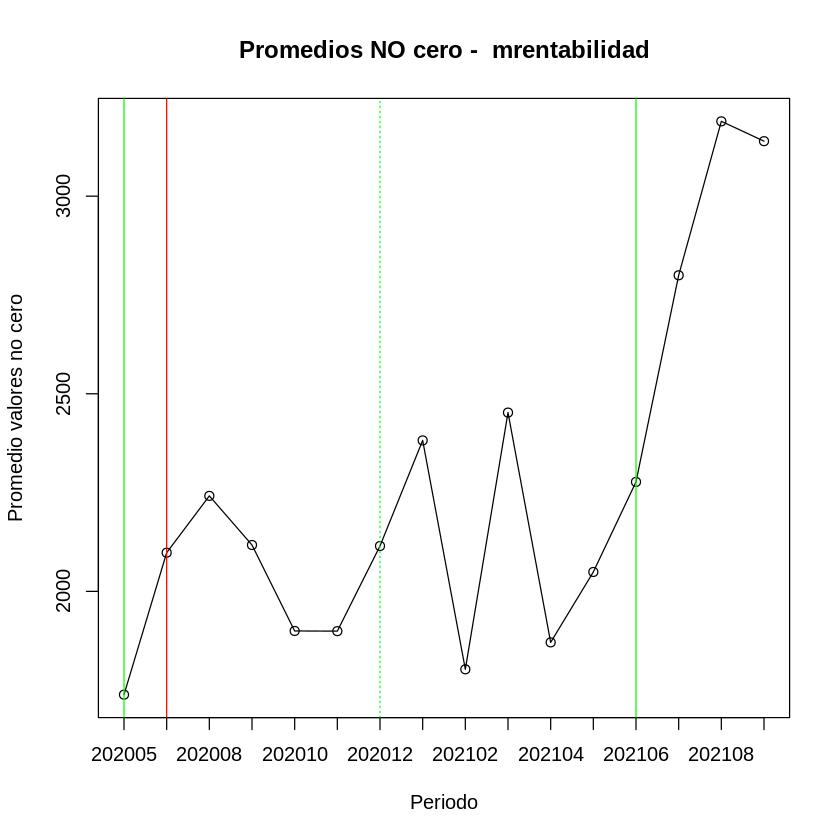

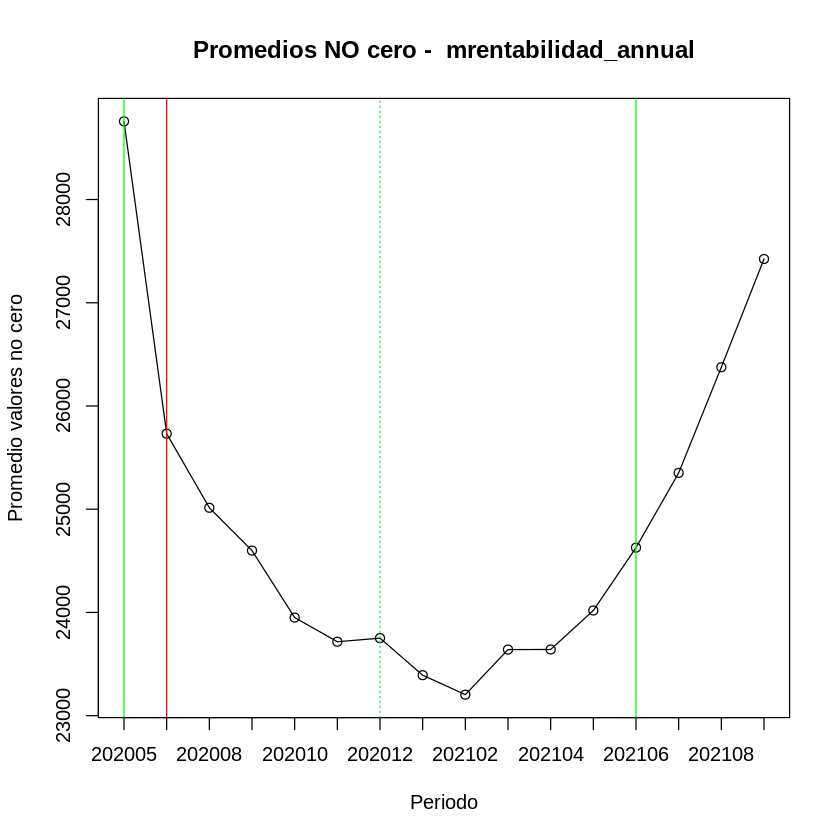

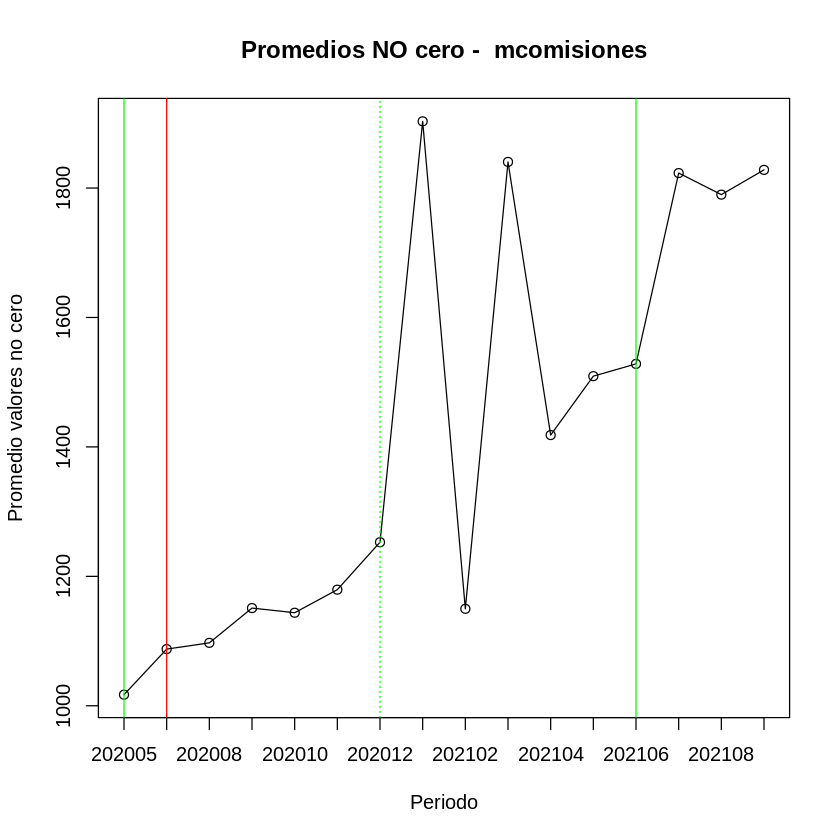

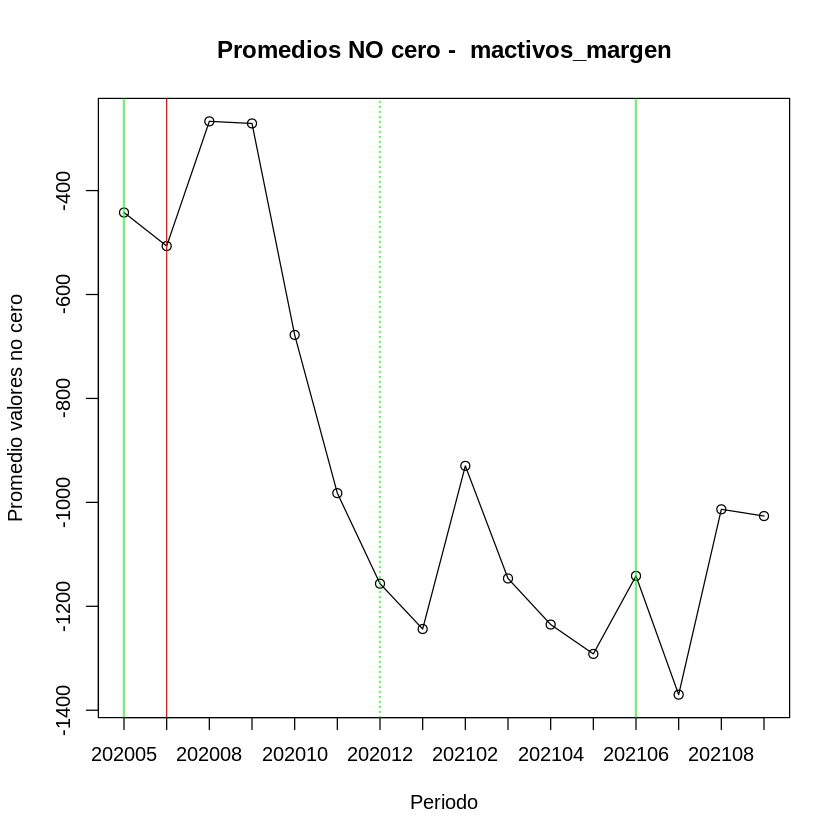

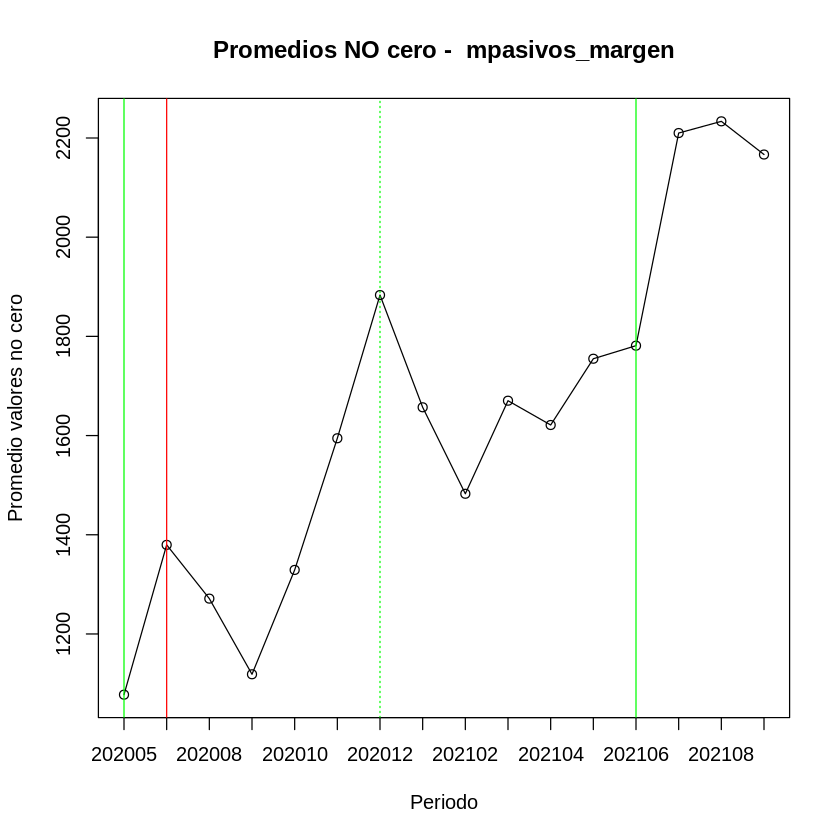

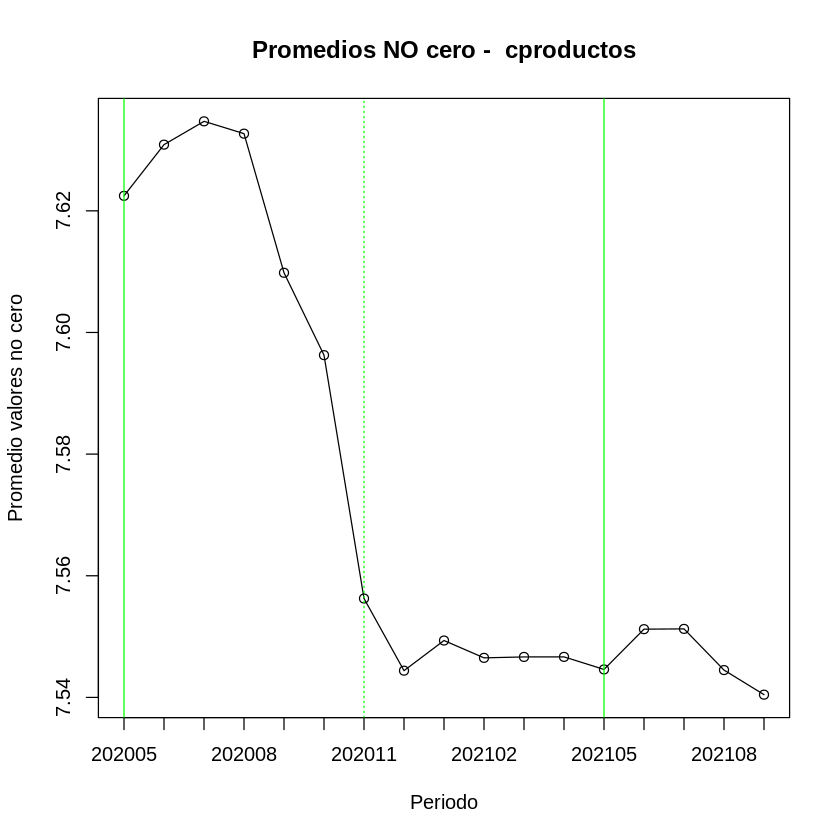

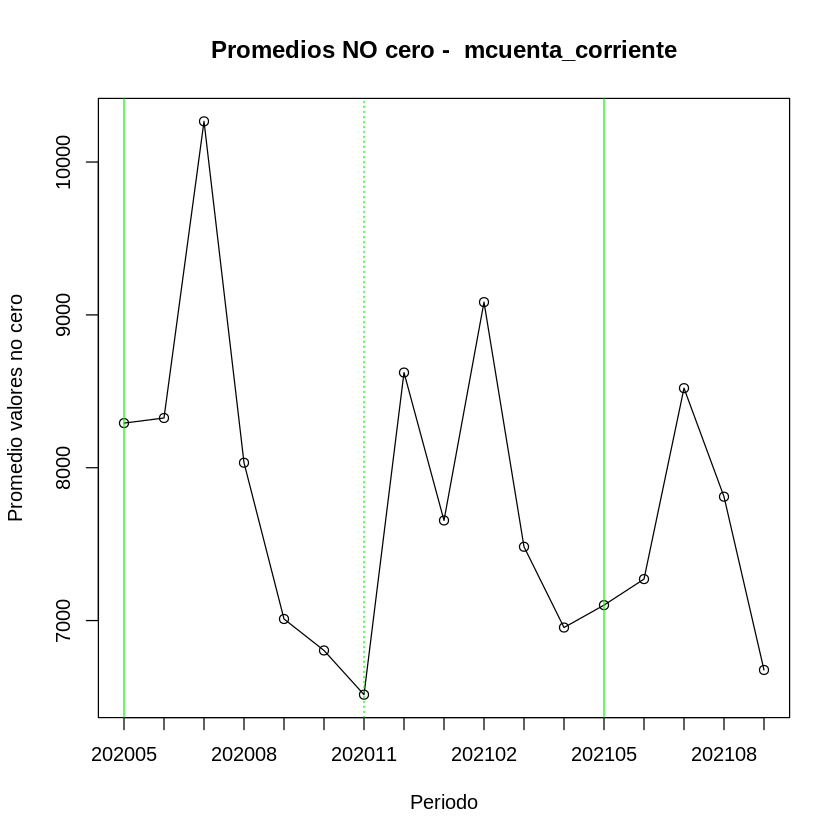

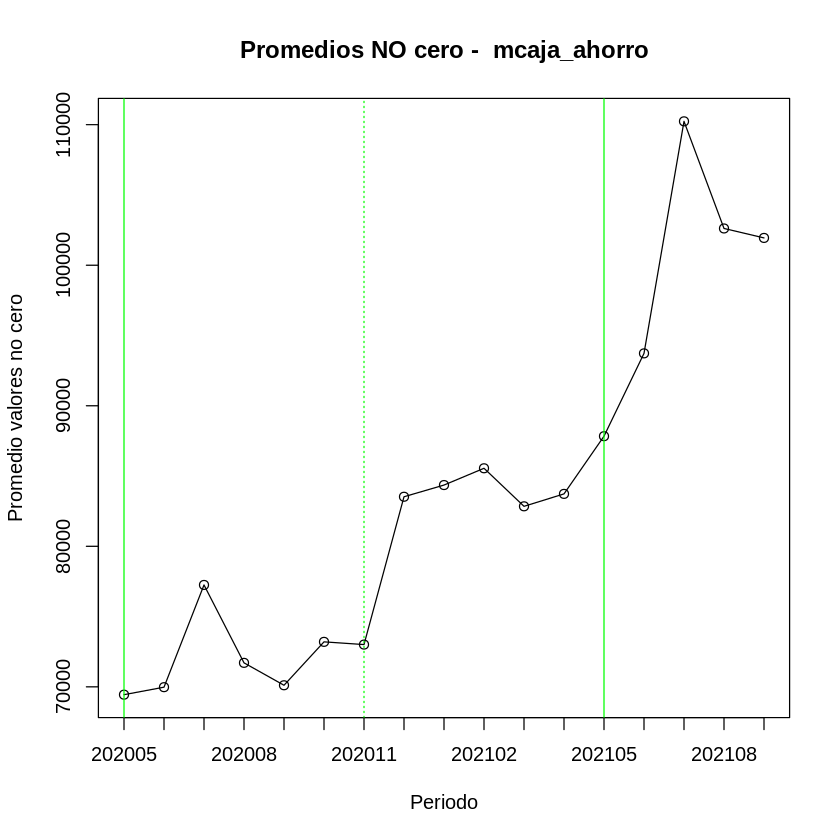

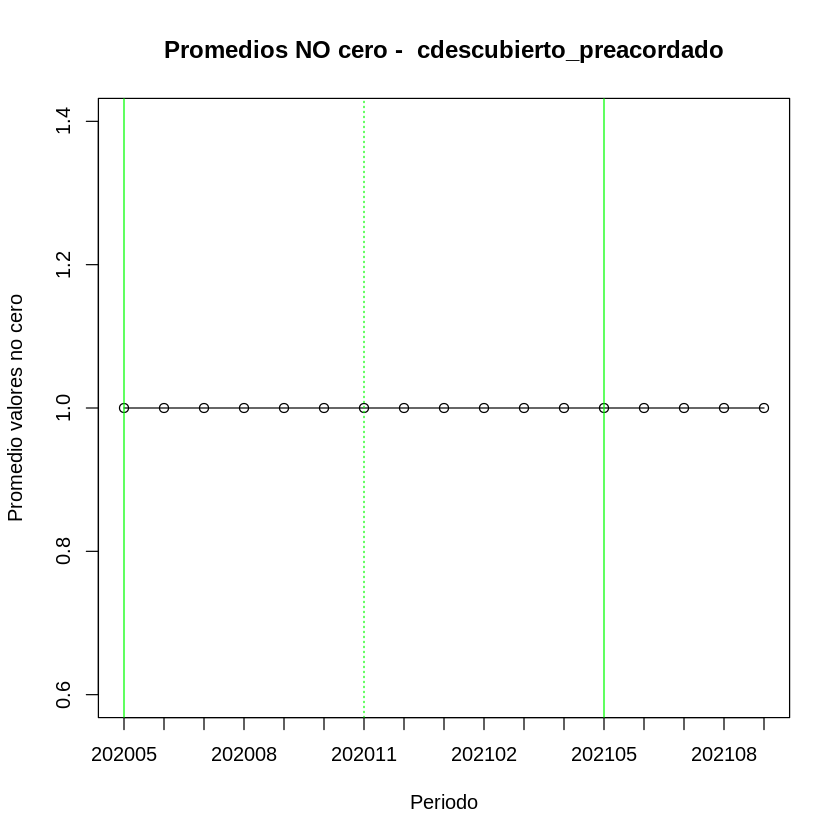

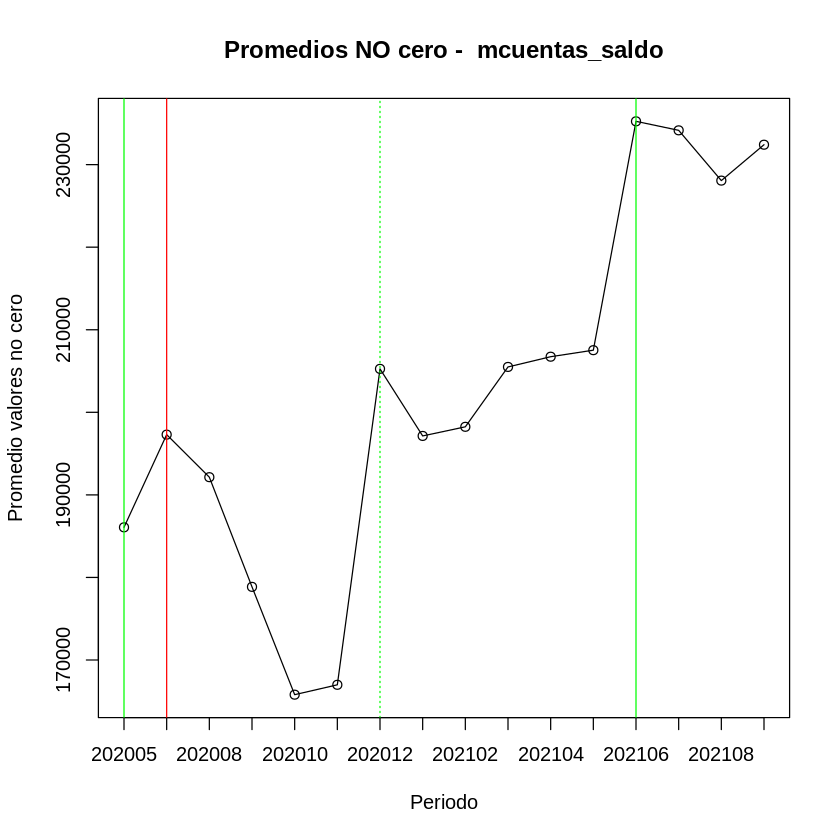

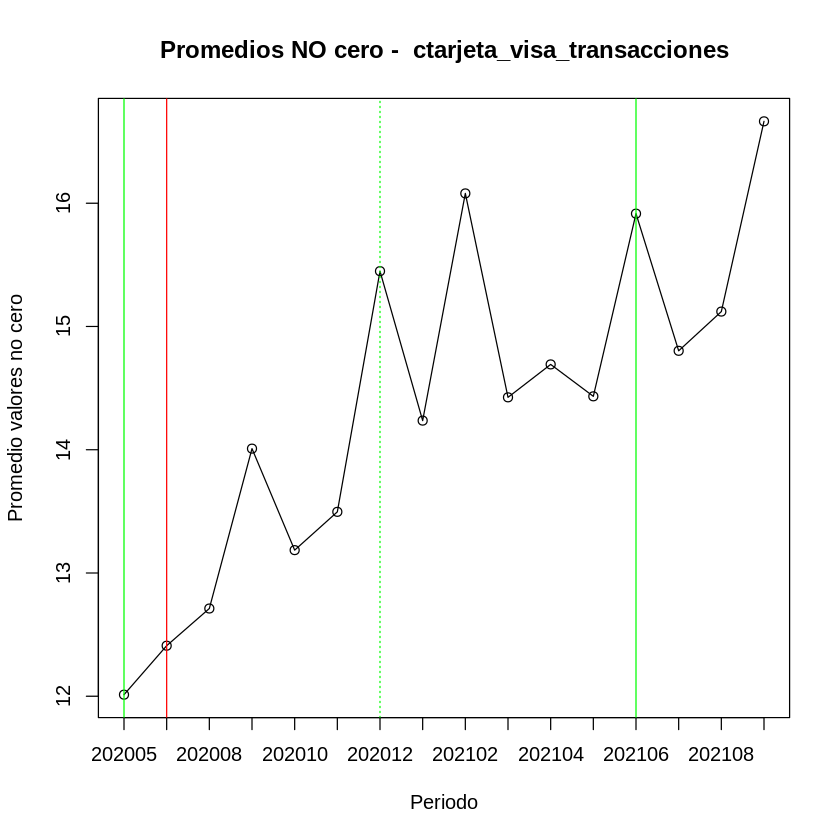

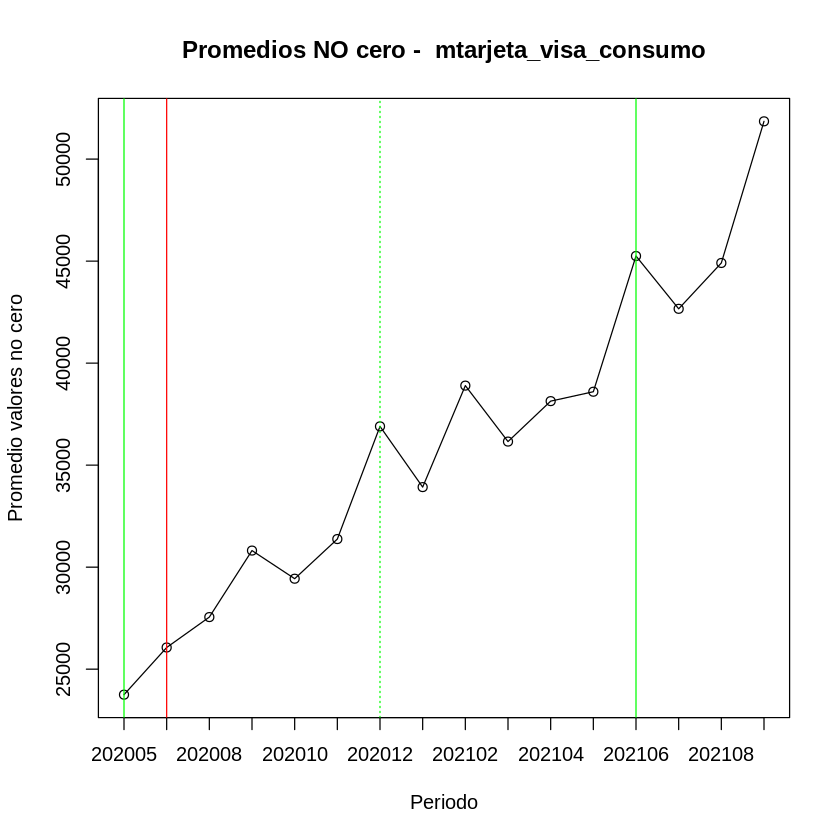

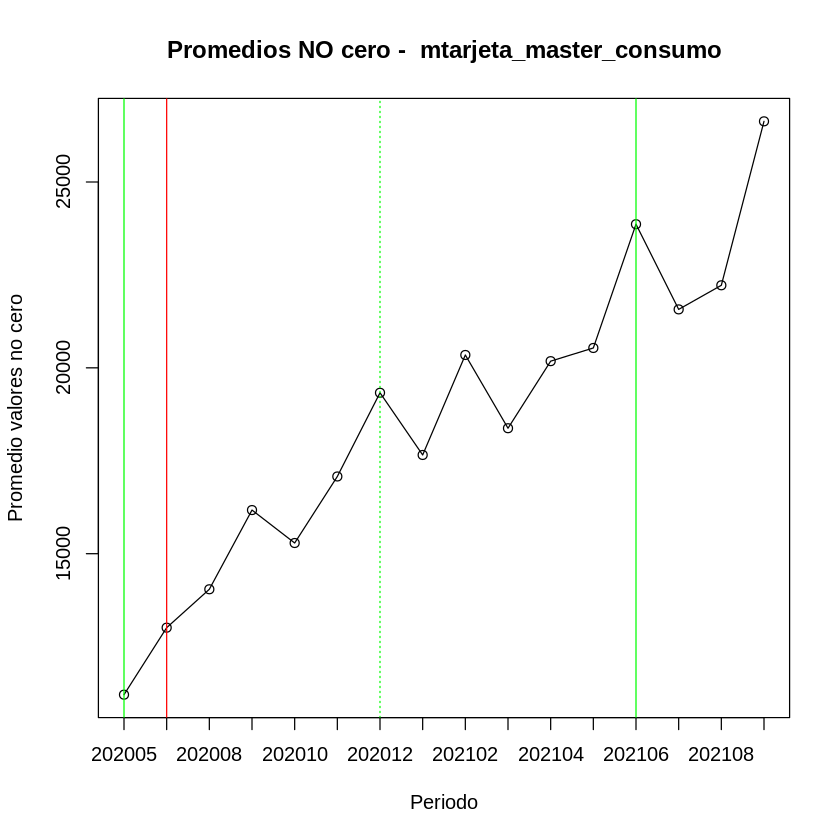

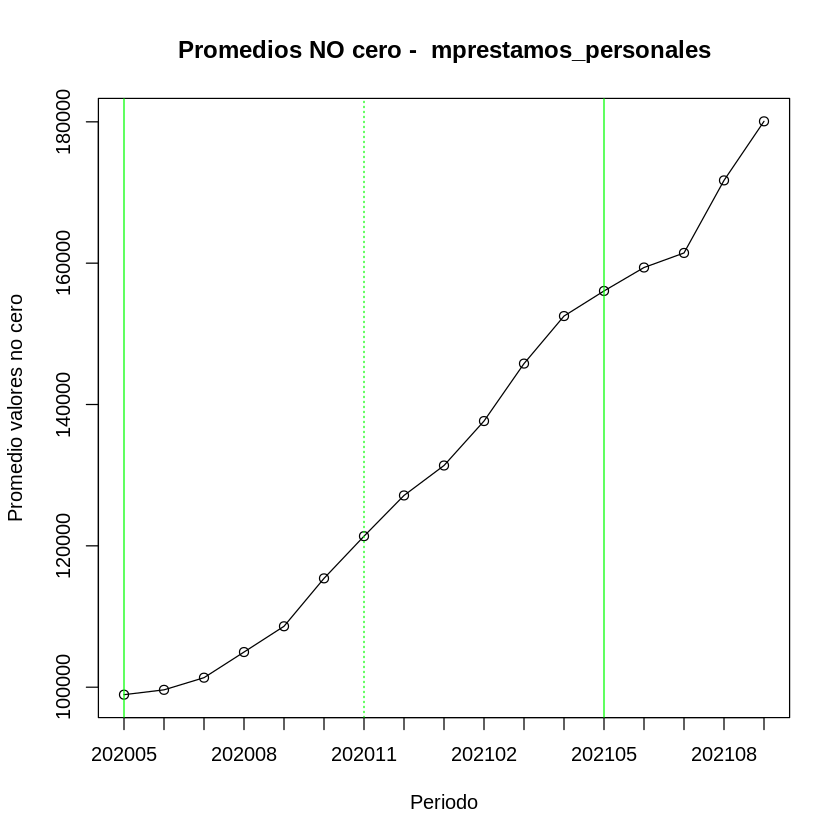

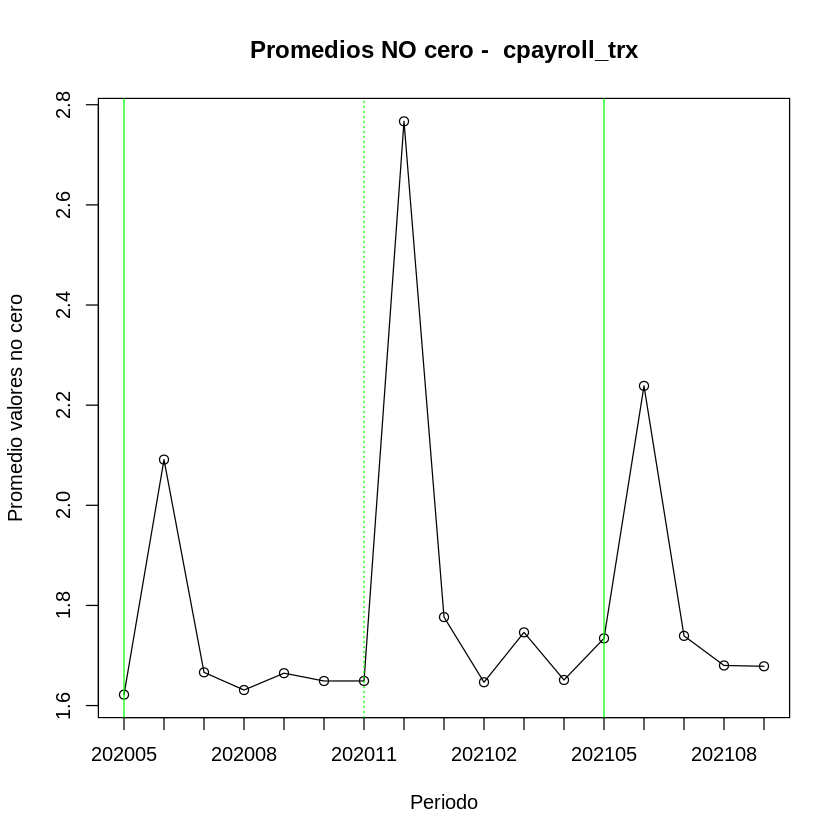

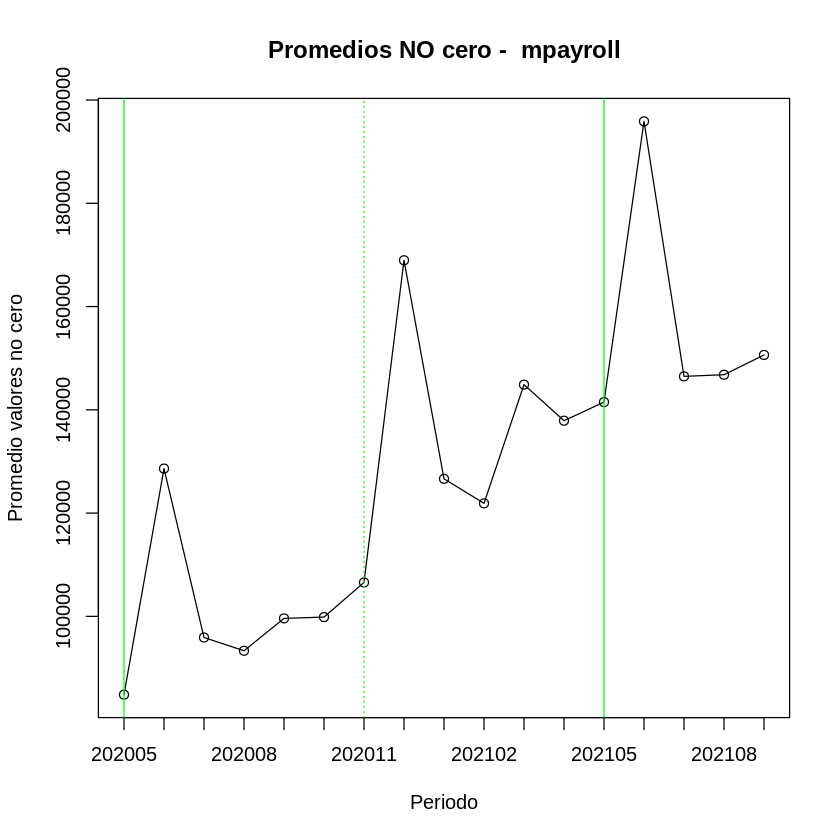

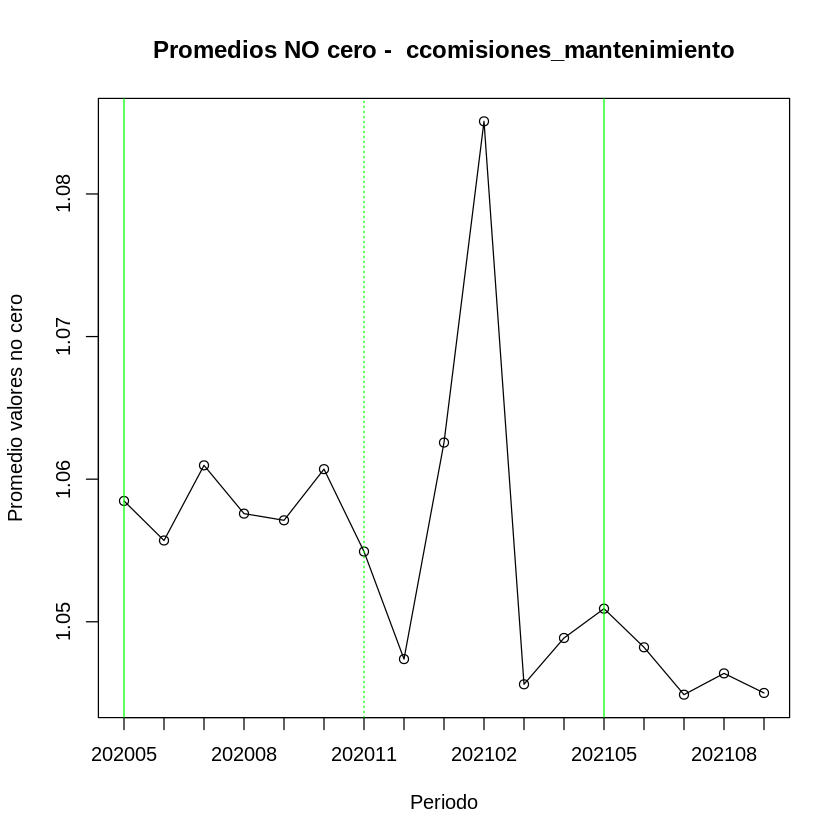

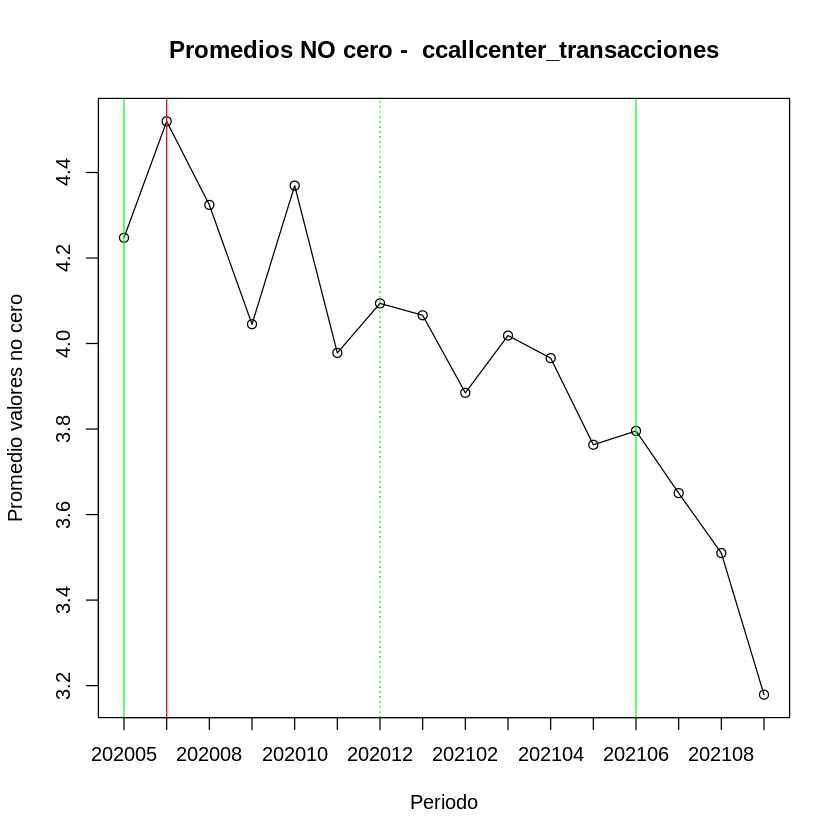

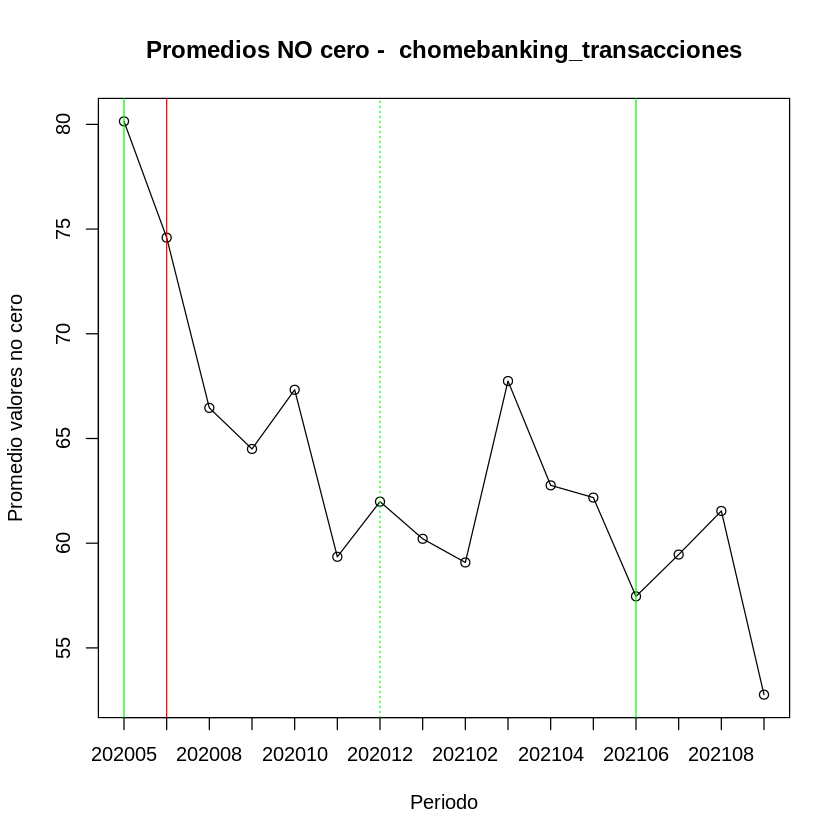

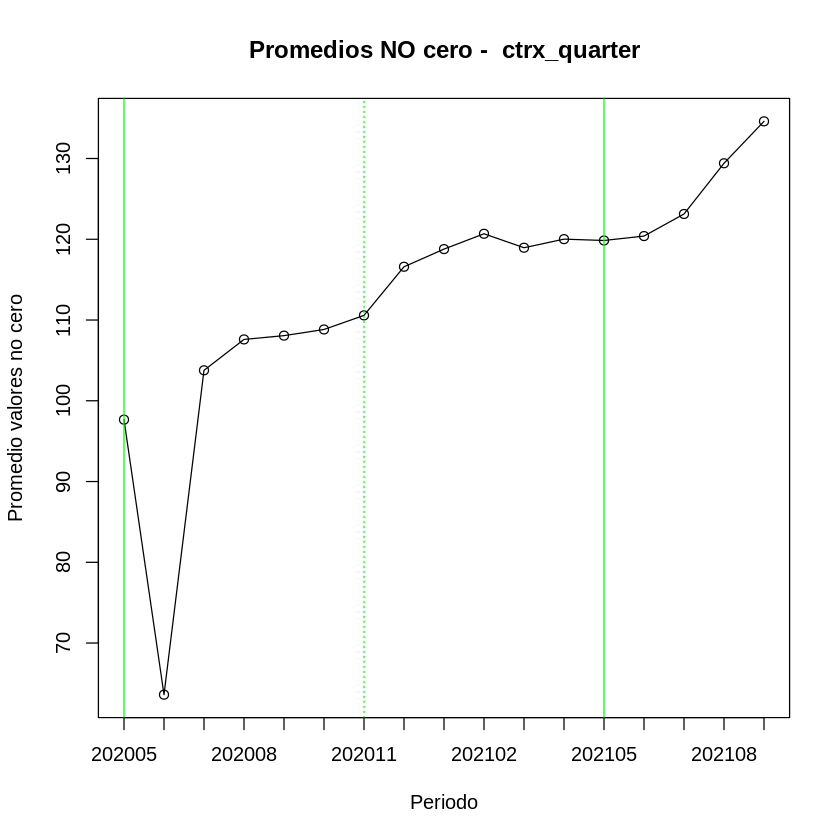

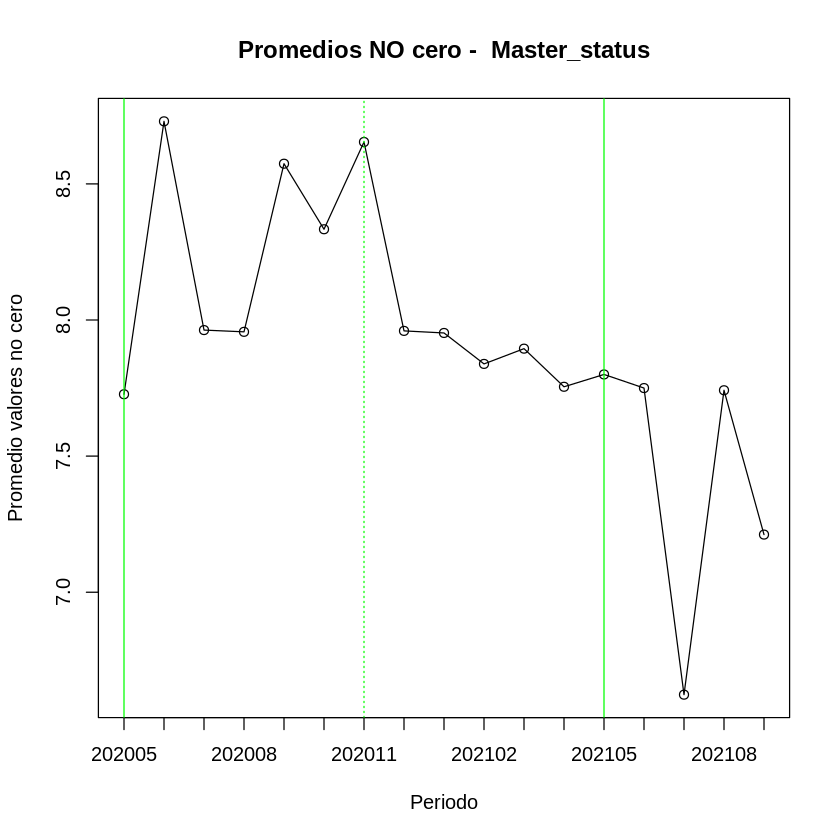

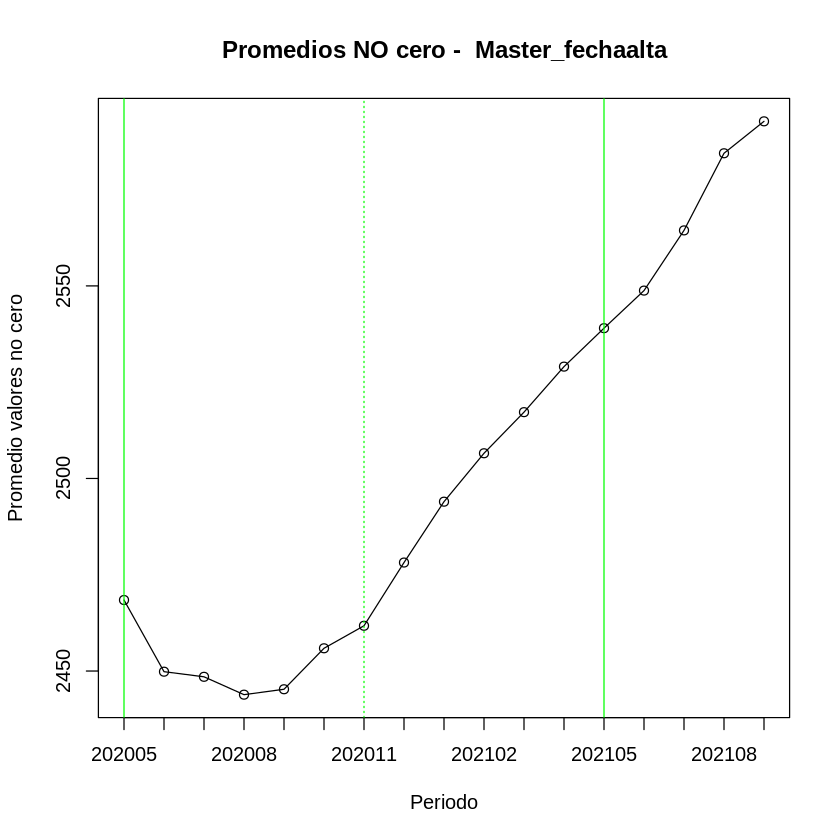

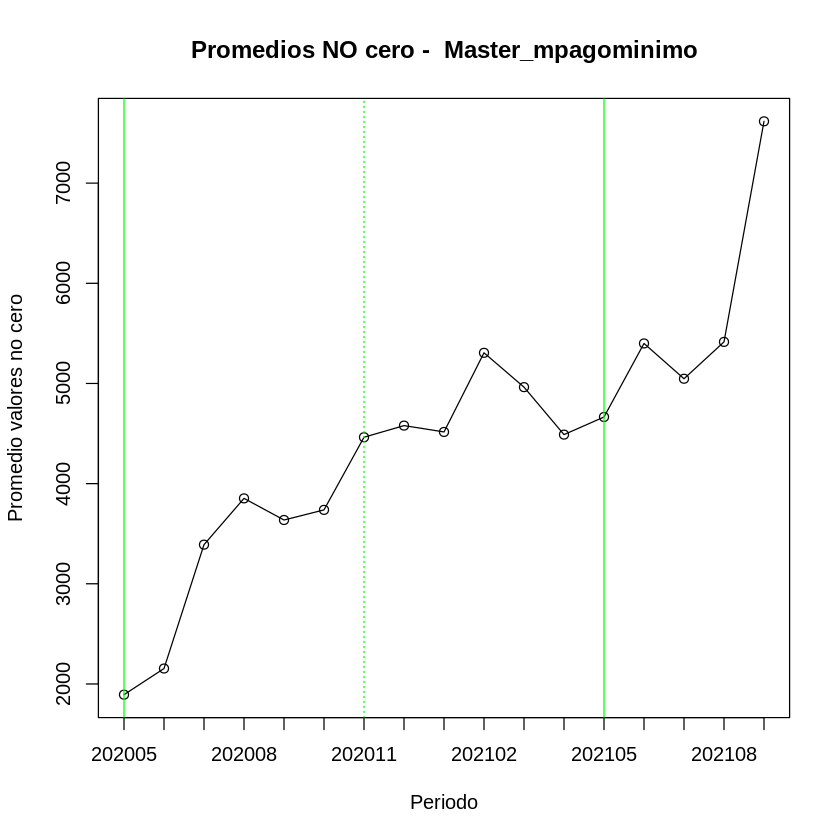

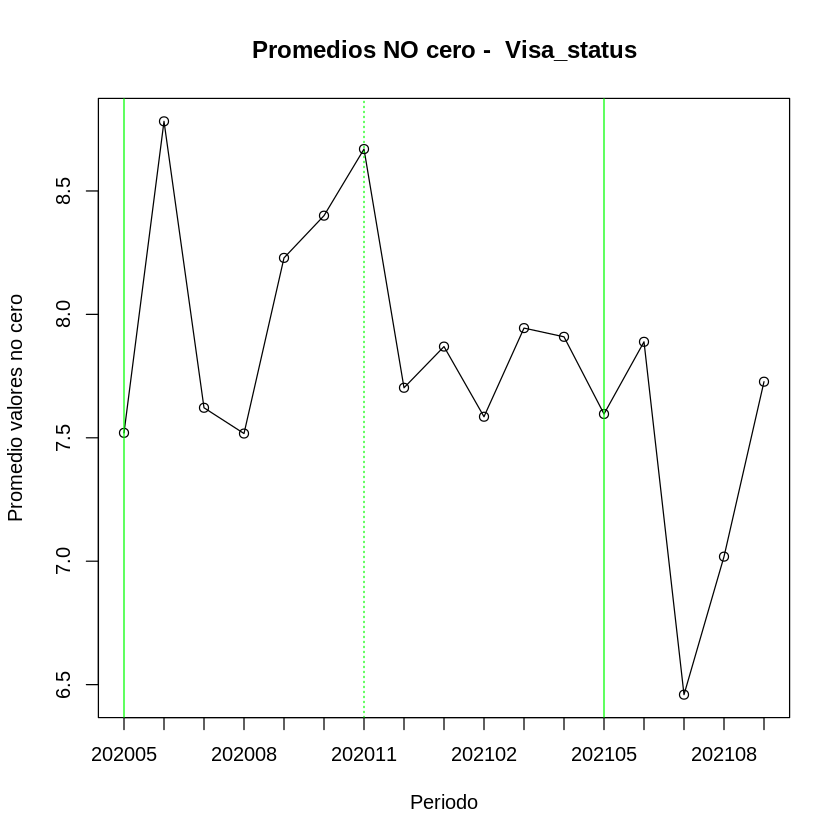

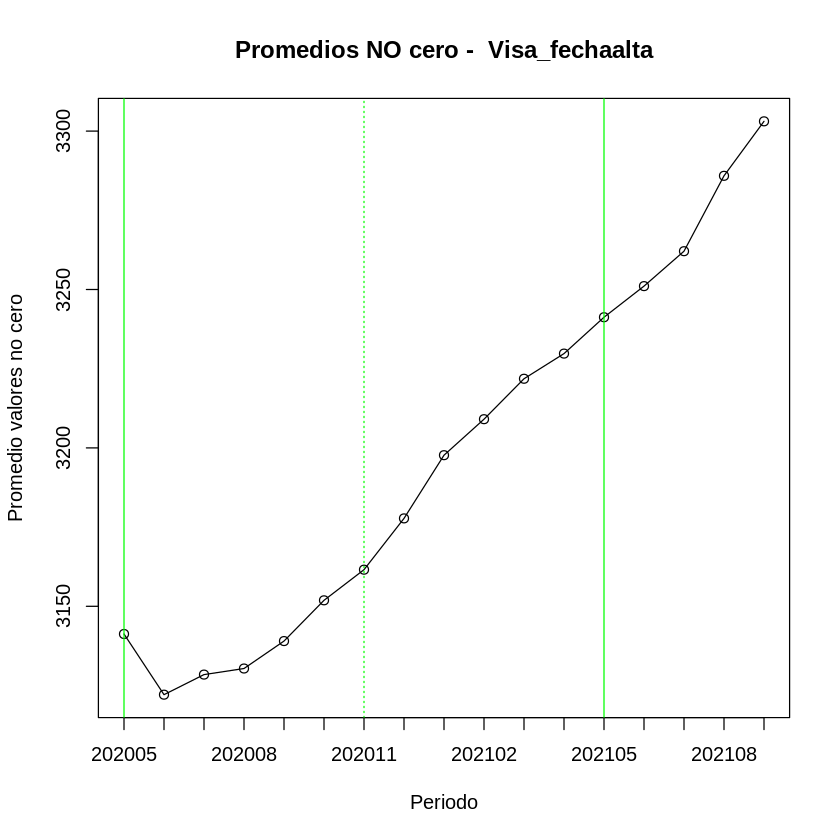

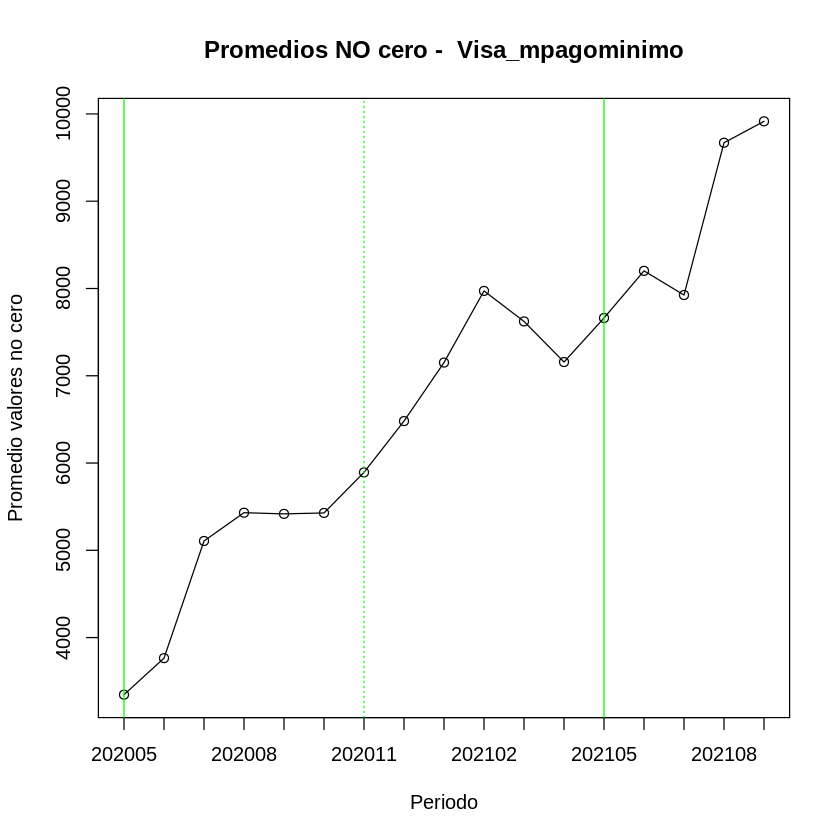

In [11]:
# Para cada variable ,
#  grafico para cada mes el promedio de esa variable
#   cuando la variable es DISTINTA de cero
# el promedio_nocero de una variable para un mes dado
# es el promedios del conjunto de valores de esa variable para ese mes
#   tales que no no son ni nulos ni tampoco valen cero

# pdf("promedios_nocero.pdf")

for (campo in campos_buenos) {
  tbl <- dataset[
    get(campo) != 0,
    list("promedio" = mean(get(campo), na.rm = TRUE)),
    foto_mes
  ]

  ceros <- dataset[
    ,
    list("zero_ratio" = sum(get(campo) == 0, na.rm = TRUE) / .N),
    foto_mes
  ]

  plot(
    x = 1:nrow(tbl),
    y = tbl$promedio,
    type = "o",
    main = paste0("Promedios NO cero -  ", campo),
    xlab = "Periodo",
    ylab = "Promedio valores no cero",
    xaxt = "n"
  )

  axis(1, at = 1:nrow(tbl), labels = tbl$foto_mes)

  abline(
    v = c(1, 13, 25),
    col = c("green", "green", "green"),
    lty = c(1, 1, 1),
    lwd = c(1, 1, 1)
  )

  abline(
    v = c(7, 19, 31),
    col = c("green", "green", "green"),
    lty = c(3, 3, 3),
    lwd = c(1, 1, 1)
  )

  for (i in 1:nrow(tbl)) {
    if (ceros[i, zero_ratio] > 0.99 & median(ceros[, zero_ratio]) < 0.99) {
      abline(v = c(i), col = c("red"), lty = c(1), lwd = c(1))
    }
  }
}

# dev.off()





---

